# Setting

## Library

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random
import os
from tqdm.notebook import tqdm

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix

## Seed

In [6]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    print(f'고정된 Seed : {seed}')

In [7]:
my_seed_everywhere(42)

고정된 Seed : 42


# Data Set

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

In [78]:
def preprocessing(data, used=None):
  # 'DATE'를 칼럼 대신 인덱스로 사용
  data.index = data['DATE']
  data = data.drop(columns='DATE')
  print("'DATE'를 칼럼 대신 인덱스로 사용")

  # 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
  data = data.dropna()
  data = data.drop(columns=['winner', 'loser', 'form_date'])
  print("결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')")

  if used != None:
    used += ['wml']
    D = ', '.join(used)
    data = data[used]
    print(f"훈련에 사용되는 변수 들 : {D}")

  return data

In [79]:
df = preprocessing(df,
                   used=['cum_winner_t_2_4', 'cum_winner_t_5_8', 'cum_winner_t_9_12'])

'DATE'를 칼럼 대신 인덱스로 사용
결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')
훈련에 사용되는 변수 들 : cum_winner_t_2_4, cum_winner_t_5_8, cum_winner_t_9_12, wml


In [80]:
def normal_wml(df):
  print("'wml'이 양수면 1 & 음수면 0")
  print("Output : 'Preprocessed_Data' & 'WML'")
  print()

  cond_wml = (df['wml']>=0)
  df.loc[cond_wml, 'pos_wml'] = 1
  df.loc[~cond_wml, 'pos_wml'] = 0
  WML = df[['wml']]

  df.drop(columns=['wml'], inplace=True)

  POS_WML = df['pos_wml'].value_counts()
  print(f'Ratio : {POS_WML[0]/POS_WML[1]}')
  print(POS_WML)

  return df, WML

In [81]:
dynmom, WML = normal_wml(df)

'wml'이 양수면 1 & 음수면 0
Output : 'Preprocessed_Data' & 'WML'

Ratio : 0.5634379263301501
1.0    733
0.0    413
Name: pos_wml, dtype: int64


# Modeling

In [82]:
def Roling_Windows(data, window_size, method, model, model_name, plot=True, plot_feature=True):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_dict = {
    'TRAIN_START_DATE':[],
    'TRAIN_END_DATE':[],
    'TEST_DATE':[],
    'Actual_POS_WML':[],
    f'{model_name}_PRED_POS_WML':[],
    f'{model_name}_PROB_POS_WML':[]
  }

  df_feature = pd.DataFrame()

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size

  print('*'*50)
  print(f'\n{model_name} Model의 Rolling {method} Window를 실행합니다\n')
  print('설정된 Model의 하이퍼파리미터 : \n')
  for p, v in zip(model.get_params(deep=True).keys(), model.get_params(deep=True).values()):
    print(f'   {p} : {v}')
  print()
  print('*'*50)

  for i in tqdm(range(end)):

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break
    
    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+i]

    # Rolling Expanding Window
    elif method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+i]
    
    # 'method' 잘못입력한 경우
    else:
      print("Make sure to set the method to either 'Fixed' or 'Expanding'.")
      break
    
    # 테스트 데이터 설정
    test = data.iloc[[window_size+i]]

    # Features와 Target 구분
    X_train = train.drop(columns=['pos_wml'])
    y_train = train['pos_wml']

    X_test = test.drop(columns=['pos_wml'])
    y_test = test['pos_wml'] 

    # 모델 학습 및 추론
    MODEL.fit(X_train, y_train)
    pred_test = MODEL.predict(X_test)
    prob_test = MODEL.predict_proba(X_test)

    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(test.index[0])

    result_dict['Actual_POS_WML'].append(list(y_test)[0])
    result_dict[f'{model_name}_PRED_POS_WML'].append(pred_test[0])
    result_dict[f'{model_name}_PROB_POS_WML'].append(prob_test[0][-1])

    # 트리 기반 모델 (사이킷런)의 Feature Importance 정보 수집
    feature_importances = MODEL.feature_importances_
    df_ft_importance = pd.DataFrame(feature_importances, index = X_train.columns).T
    df_ft_importance.index = y_test.index
    df_feature = pd.concat([df_feature, df_ft_importance])

  result = pd.DataFrame(result_dict)
  result.index = df_feature.index

  result = pd.concat([result, df_feature], axis=1)
  result = result.set_index('TEST_DATE')
  
  # 모델 성능 시각화
  if plot == True:
    plot_result(result, method, model_name)
  
  # 모델의 변수 중요도 시각화
  if plot_feature == True:
    plot_feature_importances(result, model_name)
    print()

  # 학습 및 테스트 데이터 정보, 실제값과 예측값 정보, 변수 중요도 정보
  return result

In [83]:
def plot_result(data, method, model_name):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  precision = precision_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  recall = recall_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  F1_score = f1_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')
  
  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.title(f'Performance results {method} of the {model_name} model')
  
  plt.show()

In [84]:
def plot_feature_importances(data, model_name):

  data = data.drop(columns=['TRAIN_START_DATE', 'TRAIN_END_DATE', 'Actual_POS_WML',
                           f'{model_name}_PRED_POS_WML', f'{model_name}_PROB_POS_WML'])

  print('\nFeature Importance of the model\n')

  # 날짜 별 Feature Importance 변화 추이
  plt.figure(figsize=(15, 5))
  for col in data.columns:

    sns.lineplot(data=data,
                x=data.index,
                y=col,
                label=col,
                alpha=0.3)
    
    plt.title('Feature importances using MDI')
    plt.xlabel('DATE')
    plt.ylabel('Mean decrease in impurity')
    plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
    plt.tick_params(axis='x',
                      direction='out',
                      labelrotation=45,
                      length=1,
                      pad=10,
                      labelsize=5,
                      width=0.1)
  plt.show()

  # 각 변수 별 Feature Importance 통계값
  MEAN = display_feature_importance(data, method='mean')
  MAX = display_feature_importance(data, method='max')
  MIN = display_feature_importance(data, method='min')

  plt.figure(figsize=(15, 5))
  sns.barplot(data=MEAN,
              y=MEAN.index,
              x='mean_Feature_Importance')

  plt.show()
  print()

  FEATURE_IMPORTANCE = pd.concat([MEAN, MAX, MIN], axis=1)
  display(FEATURE_IMPORTANCE)

In [85]:
def display_feature_importance(data, method):
       
    feature_dict = {}
    for col in data.columns:
      if method=='mean':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].mean())

      if method=='max':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].max())
      
      if method=='min':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].min())
    
    feature_df = pd.DataFrame(feature_dict).T
    feature_df.columns = [method+'_'+'Feature_Importance']
    feature_df=feature_df.sort_values(by=method+'_'+'Feature_Importance', ascending=False)

    return feature_df

In [86]:
def slice_feature_importance(data, num, method, model_name):

  if type(num) != bool:
    division = int(data.shape[0]/num)
    
    for i in range(num):

      if i == num-1:
        sliced_data = data.iloc[i*division:]

      else:
        sliced_data = data.iloc[i*division:(i+1)*division]

      start = sliced_data.index[0]
      end = sliced_data.index[-1]

      print()
      print('*'*50)
      print(f'\nDATE : {start} ~ {end}\n')
      print('*'*50)
      print()
      
      plot_result(sliced_data, method, model_name)
      plot_feature_importances(sliced_data, model_name)
  
  else:
    start = input('Start Date (ex: 20200131): ')
    end = input('Start Date (ex: 20221230): ')
    print('*'*50)
    print(f'\nDate : {start} ~ {end}\n')
    print('*'*50)
    print()

    sliced_data = data.loc[start:end]
    plot_result(sliced_data, method, model_name)
    plot_feature_importances(sliced_data)

In [87]:
def cumm_return_by_dynamic(data, wml, weight, A0_P1, A1_P0,  plot=True):

  start_index = data.index[0]
  wml = wml.loc[start_index:]

  df = pd.DataFrame(wml['wml'] * data[weight])
  df.columns = ['cum_return']
  df['cum_return'] = (1 + df.cum_return).cumprod() - 1 
  
  S = df['cum_return'].mean()/df['cum_return'].std()

  print('Sharpe Ratio : {:0.5f}\n'.format(S))

  print('최근 누적 수익률\n')
  latly_10 = df.sort_index(ascending=False).head(5)
  for i, r in zip(latly_10.index, latly_10['cum_return']):
    i = str(i)
    print('  {}년-{}월 -> {:0.2f}'.format(i[:4], i[4:6], r))

  print('\n누적 수익률 가장 높았던 순간 Top 10\n')
  top_10 = df.sort_values(by='cum_return', ascending=False).head(10)
  rank = 1
  for i, r in zip(top_10.index, top_10['cum_return']):
    i = str(i)
    print('  {}등 : {}년-{}월 -> {:0.2f}'.format(rank, i[:4], i[4:6], r))
    rank += 1
  print()

  TEST_WML = wml.copy()
  TEST_WML['wml'] = (1 + TEST_WML.wml).cumprod() - 1
  TEST_WML.columns = ['cum_return'] 

  if plot == True:

    plt.figure(figsize=(13, 6))
    sns.lineplot(data=df, x=df.index, y=df['cum_return'], label='With_ML')
    sns.lineplot(data=TEST_WML, x=TEST_WML.index, y=TEST_WML['cum_return'], label='Original')
    plt.xticks([df.index[i] for i in range(0,len(df.index), 12)])
    plt.tick_params(axis='x',
                    direction='out',
                    labelrotation=45,
                    length=1,
                    pad=10,
                    labelsize=5,
                    width=5)
    for i in A0_P1:
      plt.vlines(i, -80000, 0, color='pink', linewidth=0.4, alpha=1)

    for i in A1_P0:
      plt.vlines(i, 80000, 0, color='pink', linewidth=0.4, alpha=1)

    plt.legend(fontsize=10)
    plt.show() 

  return df

In [88]:
def What_Pred(data, WML, model_name):

  start_index = data.index[0]
  WML = WML.loc[start_index:]
  WML.index.name = 'TEST_DATE'

  Q1 = WML.quantile(0.25)
  Q3 = WML.quantile(0.75)
  IQR = Q3 - Q1

  Upper = Q3 + (1.5*IQR)
  Lower = Q1 - (1.5*IQR)

  print('\nIQR 기준 WML 이상치 (Maximum 미만) 개수\n')

  cond_U = (WML['wml']>Upper[0])  
  WML_U = WML.loc[cond_U]
  
  print(f'Number of Outlier by IQR (Maximum) : {WML_U.shape[0]}')
  print(f'Maximum by IQR : {Upper[0]}')
  print(f"Max Outlier : {WML_U['wml'].max()}")
  print(f"Min Outlier : {WML_U['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_1 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_1 = Result.loc[cond_1]
  print('\nACTUAL = PRED = 1\n')
  sns.boxplot(data=R_1, x='wml')
  plt.show()
  display(R_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  print('\nIQR 기준 WML 이상치 (Minimum 미만) 개수\n')

  cond_L = (WML['wml']<Lower[0])  
  WML_L = WML.loc[cond_L]
  
  print(f'Number of Outlier by IQR (Minimum) : {WML_L.shape[0]}')
  print(f'Minimun by IQR : {Lower[0]}')
  print(f"Max Outlier : {WML_L['wml'].max()}")
  print(f"Min Outlier : {WML_L['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_0 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_0 = Result.loc[cond_0]
  print('\nACTUAL = PRED = 0\n')
  sns.boxplot(data=R_0, x='wml')
  plt.show()
  display(R_0[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  cond_0_1 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_0_1 = Result.loc[cond_0_1]
  print('\nACTUAL = 0 &  PRED = 1\n')
  sns.boxplot(data=R_0_1, x='wml')
  plt.show()
  sns.barplot(data=R_0_1.sort_values(by='wml', ascending=True), x=R_0_1.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  display(R_0_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  cond_1_0 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_1_0 = Result.loc[cond_1_0]
  print('\nACTUAL = 1 &  PRED = 0\n')
  sns.boxplot(data=R_1_0, x='wml')
  plt.show()
  sns.barplot(data=R_1_0.sort_values(by='wml', ascending=True), x=R_1_0.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  display(R_1_0[['wml']].describe().T)

  return list(R_0_1.index), list(R_1_0.index)

## Rolling Fixed Windows

### Random Forest

In [89]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

**************************************************

RDF Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.21      0.26       316
         1.0       0.65      0.80      0.72       590

    accuracy                           0.59       906
   macro avg       0.50      0.50      0.49       906
weighted avg       0.55      0.59      0.56       906


accuracy : 0.5927152317880795

precision : 0.65283540802213

recall : 0.8

F1-Score : 0.7189642041127189



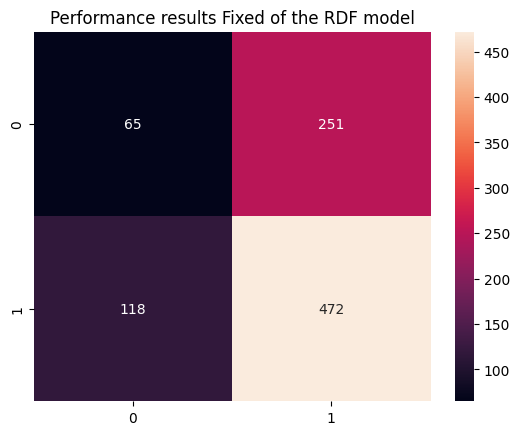


Feature Importance of the model



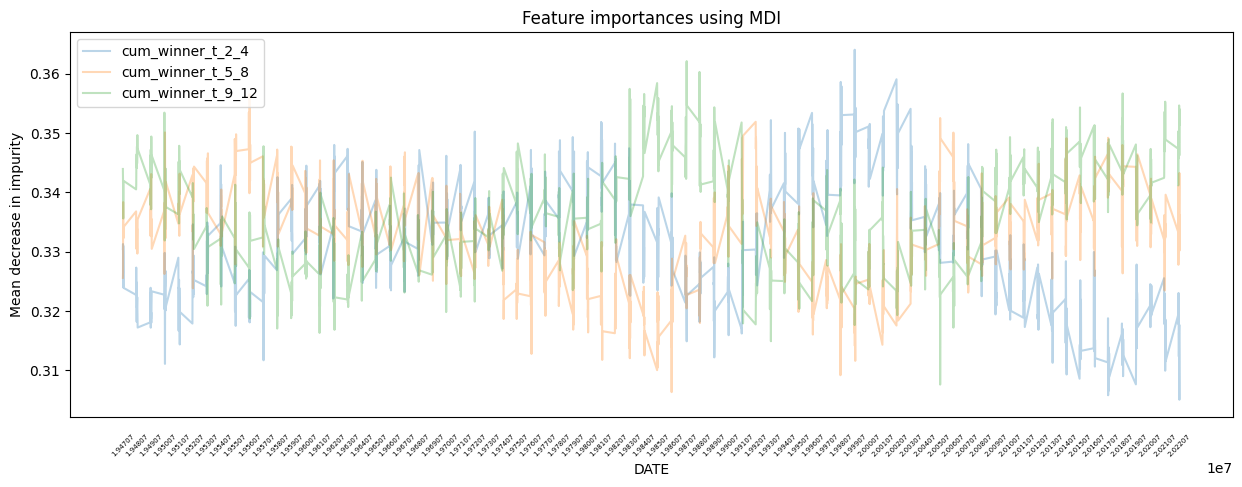

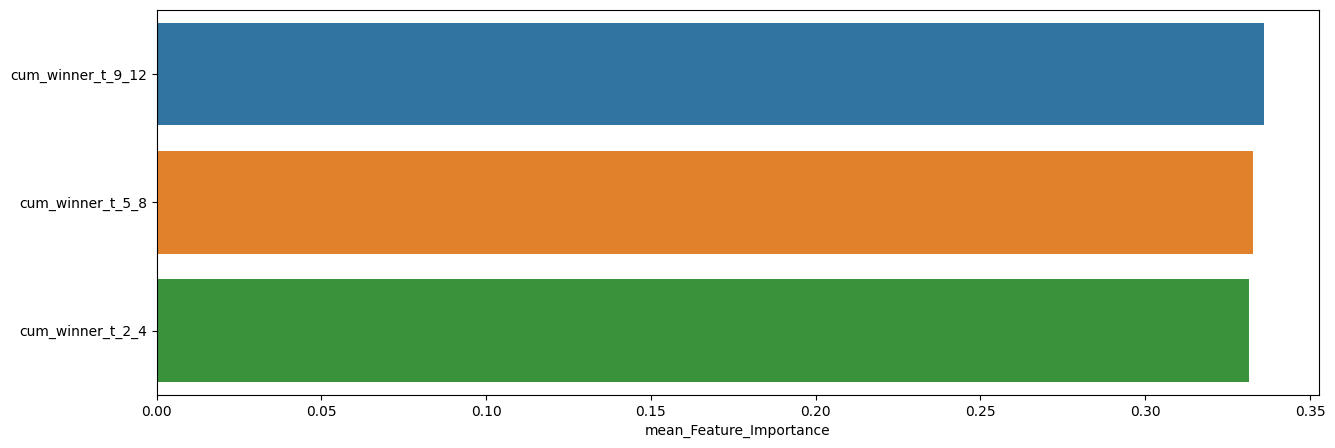

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12                 0.335947                0.362097   
cum_winner_t_5_8                  0.332597                0.356505   
cum_winner_t_2_4                  0.331456                0.364018   

                   min_Feature_Importance  
cum_winner_t_9_12                0.307612  
cum_winner_t_5_8                 0.306344  
cum_winner_t_2_4                 0.305059

In [90]:
Fixed_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=RDF, # 사용할 모델
                                  model_name='RDF', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.24      0.28        75
         1.0       0.67      0.77      0.72       151

    accuracy                           0.60       226
   macro avg       0.51      0.51      0.50       226
weighted avg       0.56      0.60      0.58       226


accuracy : 0.5973451327433629

precision : 0.6724137931034483

recall : 0.7748344370860927

F1-Score : 0.7200000000000001



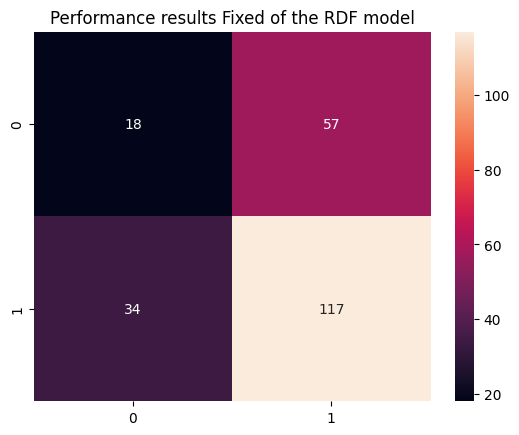


Feature Importance of the model



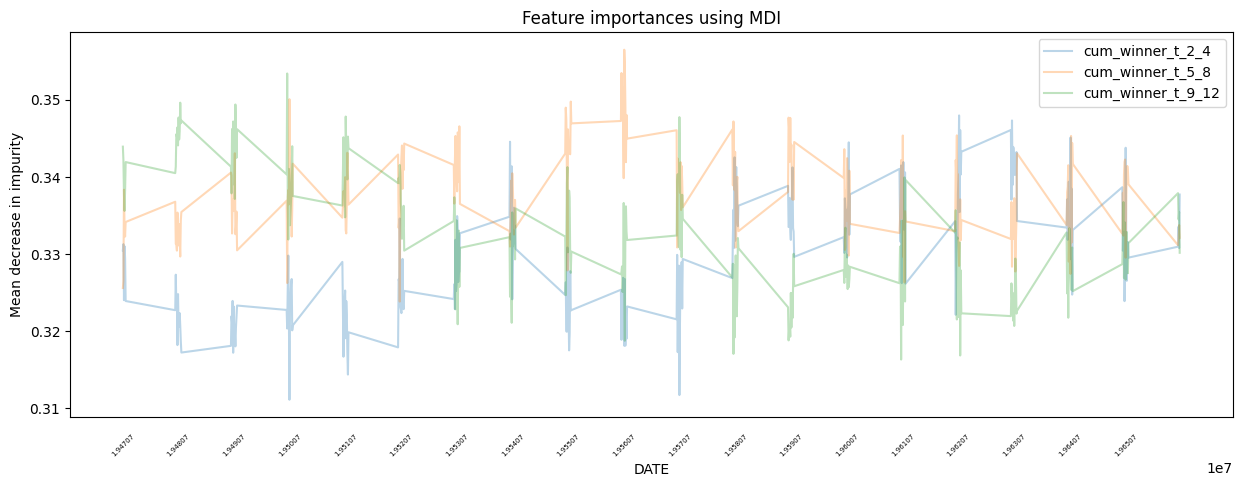

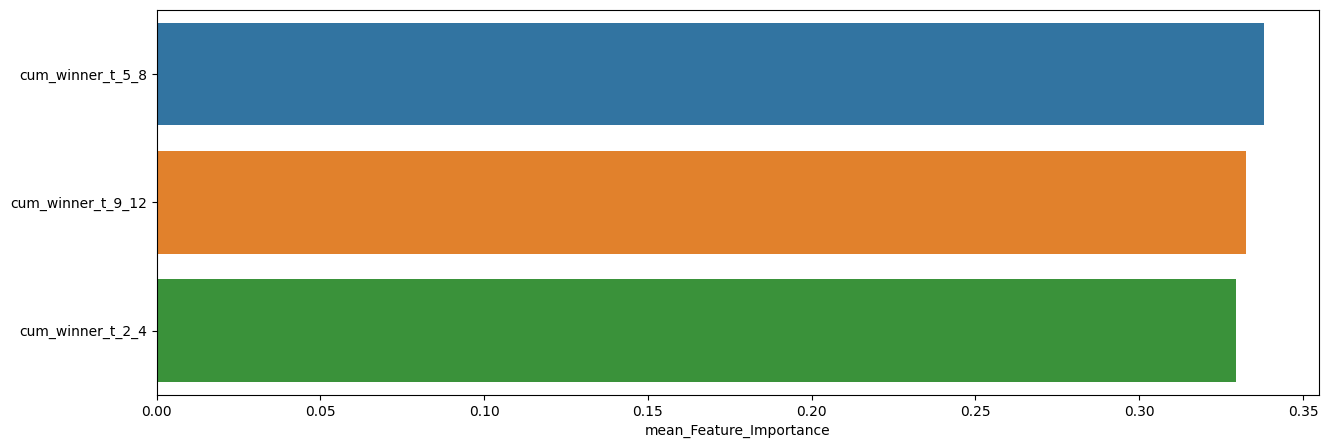

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                  0.338007                0.356505   
cum_winner_t_9_12                 0.332534                0.353423   
cum_winner_t_2_4                  0.329459                0.347981   

                   min_Feature_Importance  
cum_winner_t_5_8                 0.323831  
cum_winner_t_9_12                0.316315  
cum_winner_t_2_4                 0.311100


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.28      0.15      0.19        75
         1.0       0.66      0.81      0.72       151

    accuracy                           0.59       226
   macro avg       0.47      0.48      0.46       226
weighted avg       0.53      0.59      0.55       226


accuracy : 0.588495575221239

precision : 0.6559139784946236

recall : 0.8079470198675497

F1-Score : 0.7240356083086052



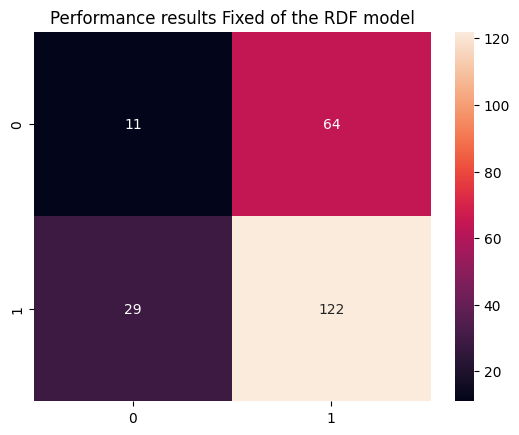


Feature Importance of the model



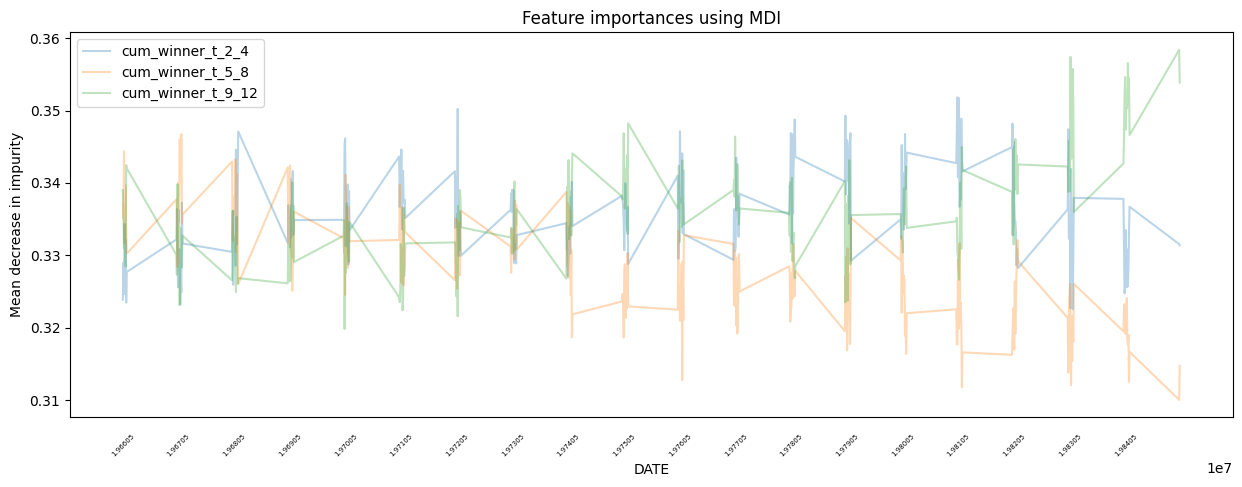

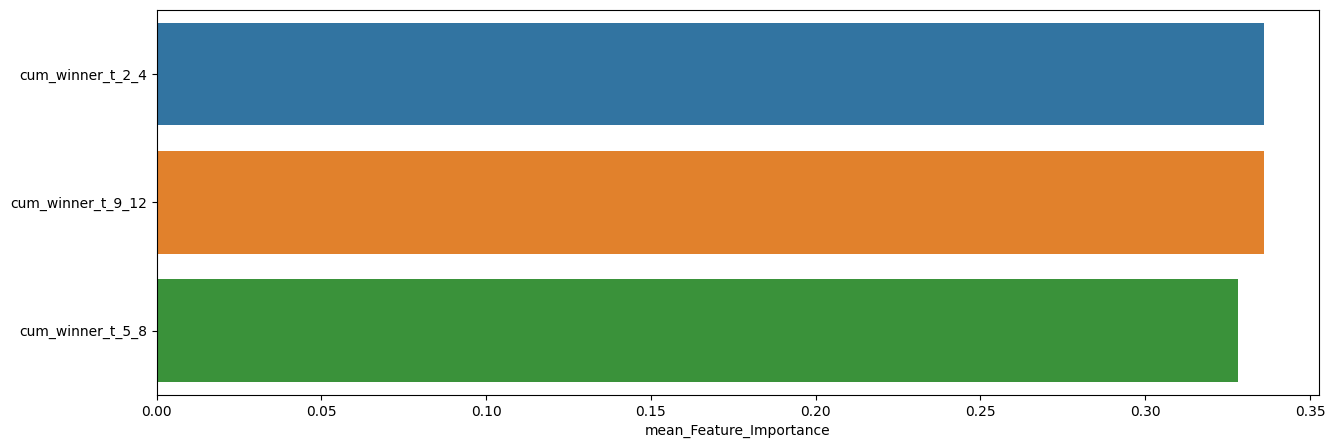

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_2_4                  0.335972                0.351820   
cum_winner_t_9_12                 0.335923                0.358395   
cum_winner_t_5_8                  0.328105                0.346739   

                   min_Feature_Importance  
cum_winner_t_2_4                 0.322564  
cum_winner_t_9_12                0.319830  
cum_winner_t_5_8                 0.310045


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.20      0.26        70
         1.0       0.70      0.85      0.77       156

    accuracy                           0.65       226
   macro avg       0.54      0.53      0.52       226
weighted avg       0.60      0.65      0.61       226


accuracy : 0.6504424778761062

precision : 0.7037037037037037

recall : 0.8525641025641025

F1-Score : 0.7710144927536231



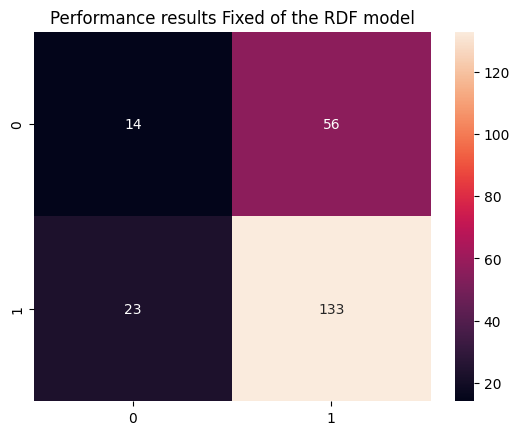


Feature Importance of the model



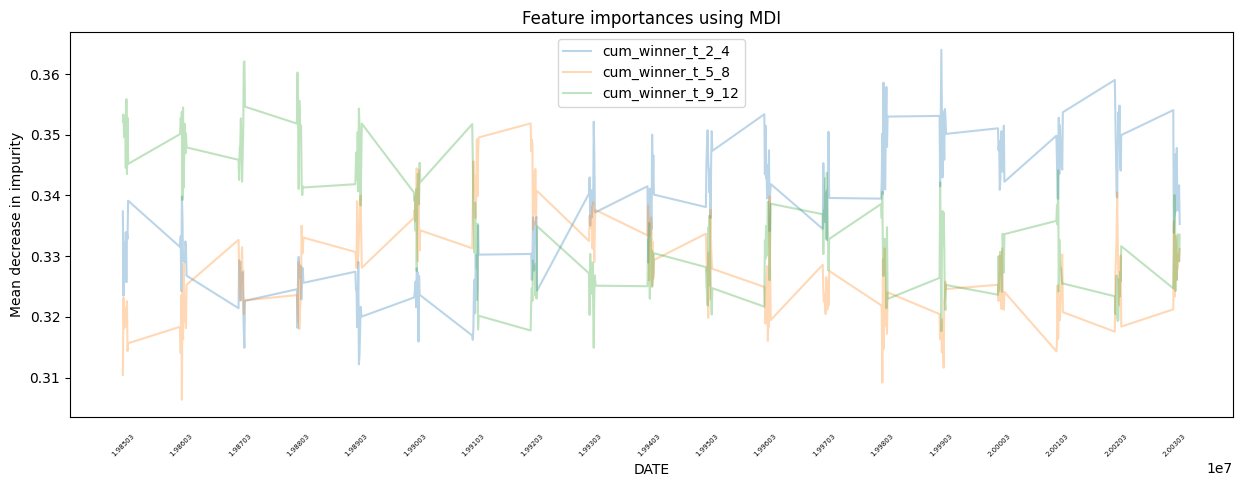

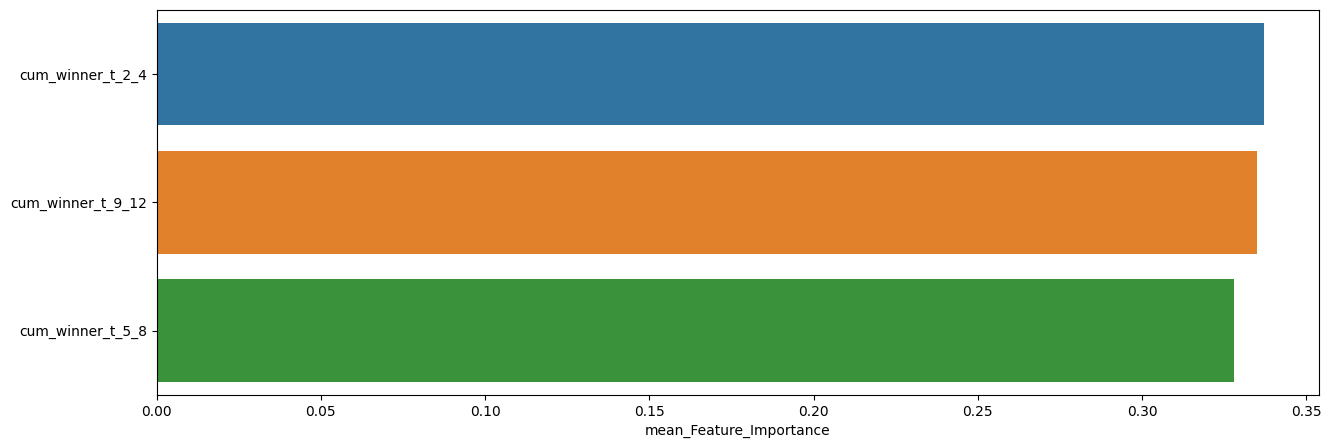

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_2_4                  0.337045                0.364018   
cum_winner_t_9_12                 0.334937                0.362097   
cum_winner_t_5_8                  0.328018                0.351882   

                   min_Feature_Importance  
cum_winner_t_2_4                 0.312195  
cum_winner_t_9_12                0.314917  
cum_winner_t_5_8                 0.306344


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.41      0.23      0.29        96
         1.0       0.57      0.76      0.65       132

    accuracy                           0.54       228
   macro avg       0.49      0.49      0.47       228
weighted avg       0.50      0.54      0.50       228


accuracy : 0.5350877192982456

precision : 0.5747126436781609

recall : 0.7575757575757576

F1-Score : 0.6535947712418301



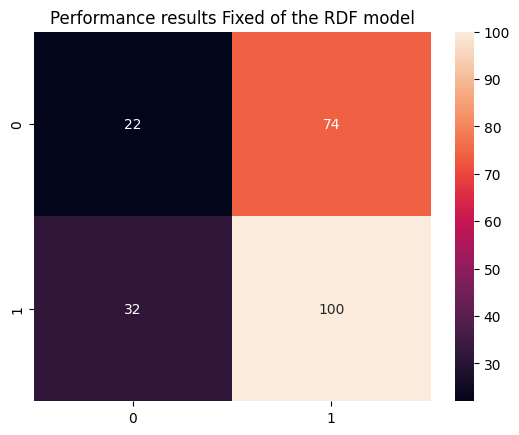


Feature Importance of the model



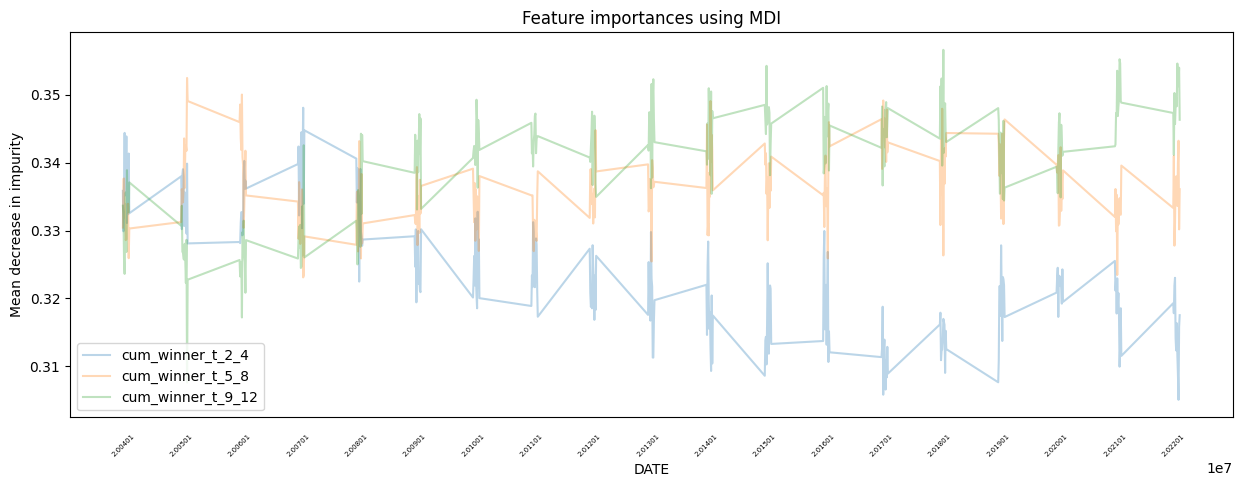

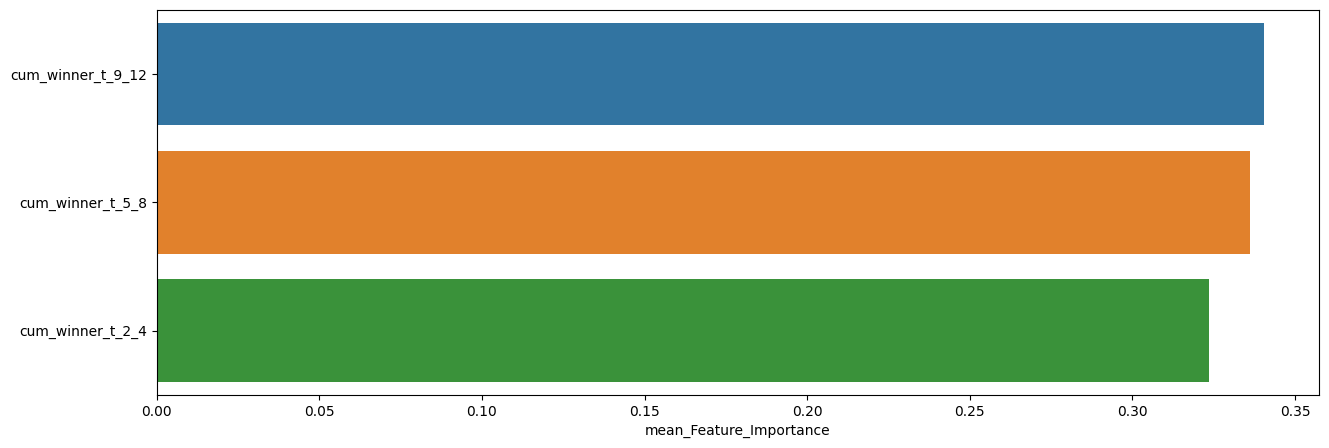

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12                 0.340356                0.356658   
cum_winner_t_5_8                  0.336225                0.352510   
cum_winner_t_2_4                  0.323419                0.348120   

                   min_Feature_Importance  
cum_winner_t_9_12                0.307612  
cum_winner_t_5_8                 0.323113  
cum_winner_t_2_4                 0.305059

In [91]:
slice_feature_importance(Fixed_RDF_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'RDF') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



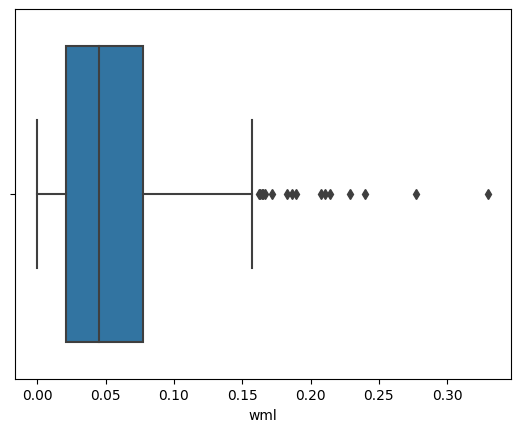

count      mean       std       min       25%       50%       75%  \
wml  472.0  0.054603  0.046097  0.000007  0.020888  0.044985  0.077301   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



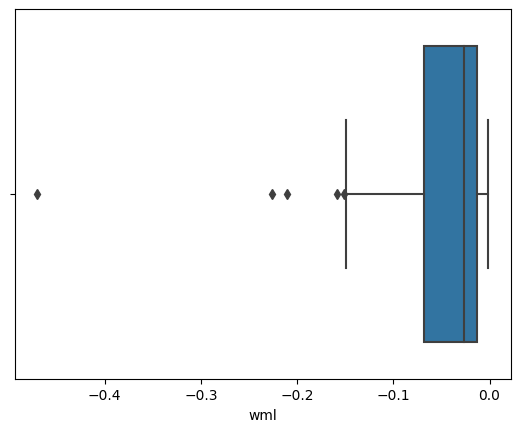

count      mean       std       min       25%       50%       75%  \
wml   65.0 -0.055618  0.073119 -0.469903 -0.067845 -0.026922 -0.013339   

         max  
wml -0.00129


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



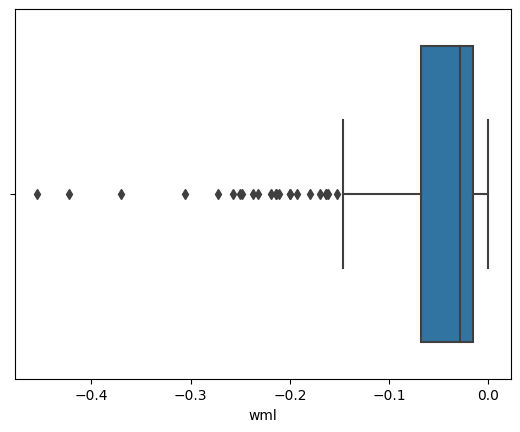

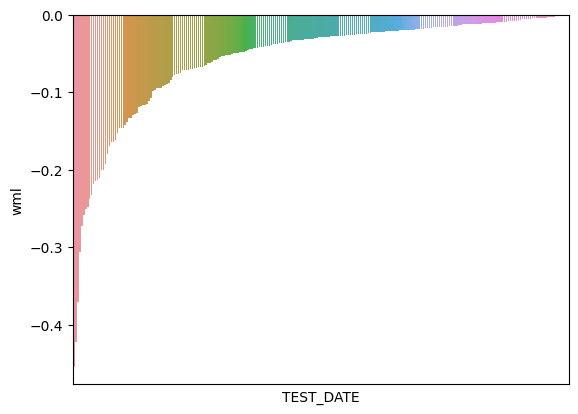

count     mean       std       min       25%       50%       75%  \
wml  251.0 -0.05649  0.070887 -0.454349 -0.068077 -0.028769 -0.015299   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



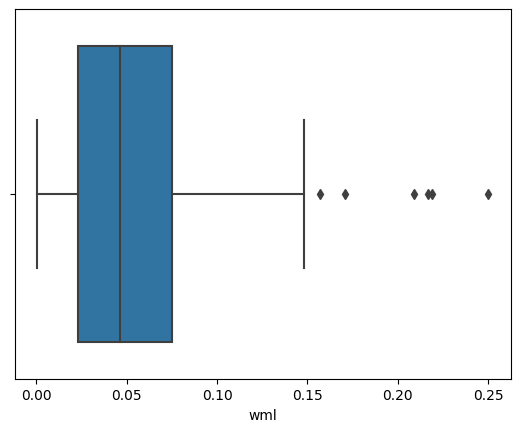

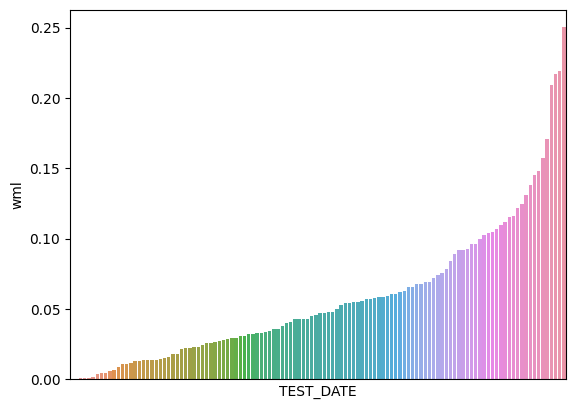

count      mean       std       min       25%       50%       75%  \
wml  118.0  0.057839  0.049686  0.000577  0.022965  0.046484  0.075262   

          max  
wml  0.250175

In [92]:
RDF_A0_P1, RDF_A1_P0 = What_Pred(Fixed_RDF_Result, WML, 'RDF')

Sharpe Ratio : 0.63506

최근 누적 수익률

  2022년-12월 -> 10290.10
  2022년-11월 -> 10290.10
  2022년-10월 -> 9788.01
  2022년-09월 -> 8667.04
  2022년-08월 -> 7879.54

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 28886.62
  2등 : 2008년-06월 -> 27635.43
  3등 : 2009년-02월 -> 26416.57
  4등 : 2001년-09월 -> 26243.67
  5등 : 2002년-07월 -> 25154.01
  6등 : 2002년-08월 -> 24425.24
  7등 : 2007년-12월 -> 24360.66
  8등 : 2008년-10월 -> 24092.35
  9등 : 2008년-11월 -> 24092.35
  10등 : 2002년-06월 -> 23849.32



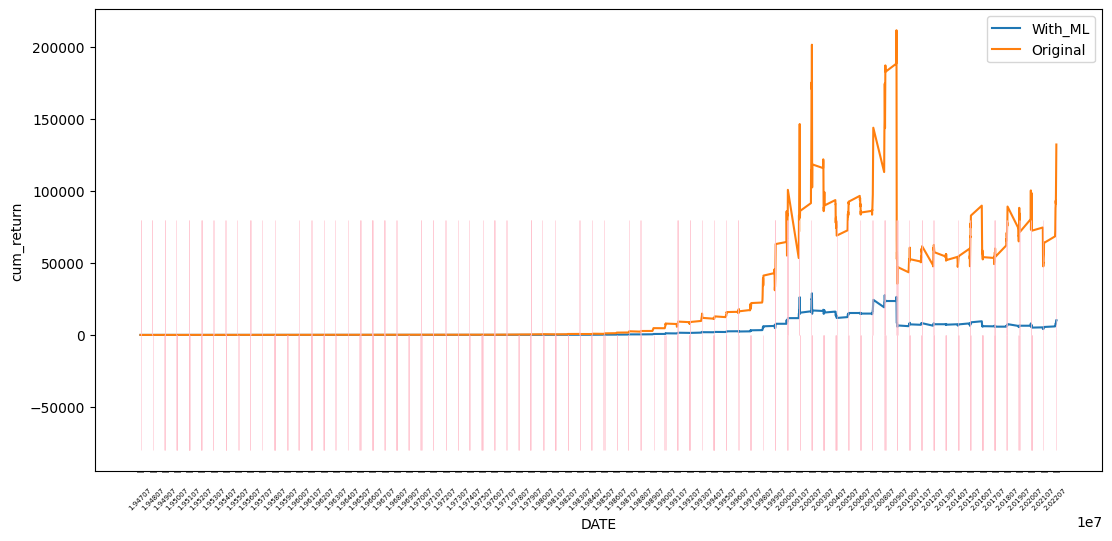

In [93]:
RDF_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_RDF_Result,
                                                 WML,
                                                 'RDF_PRED_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.73193

최근 누적 수익률

  2022년-12월 -> 6216.90
  2022년-11월 -> 5917.69
  2022년-10월 -> 5763.93
  2022년-09월 -> 5272.87
  2022년-08월 -> 5012.36

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 6216.90
  2등 : 2002년-09월 -> 5955.96
  3등 : 2022년-11월 -> 5917.69
  4등 : 2009년-02월 -> 5883.81
  5등 : 2022년-10월 -> 5763.93
  6등 : 2008년-06월 -> 5694.75
  7등 : 2008년-11월 -> 5514.65
  8등 : 2009년-01월 -> 5498.11
  9등 : 2008년-12월 -> 5444.16
  10등 : 2002년-07월 -> 5417.99



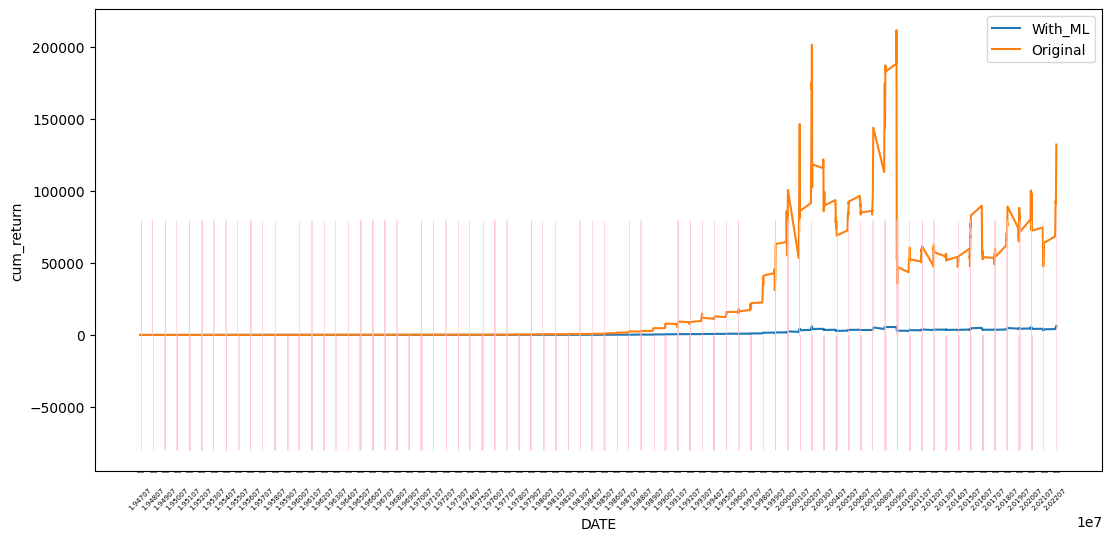

In [94]:
RDF_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_RDF_Result,
                                                 WML,
                                                 'RDF_PROB_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

### Grdient Boosting

In [95]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

**************************************************

GBC Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.22      0.27       316
         1.0       0.65      0.79      0.71       590

    accuracy                           0.59       906
   macro avg       0.50      0.50      0.49       906
weighted avg       0.55      0.59      0.56       906


accuracy : 0.58719646799117

precision : 0.651685393258427

recall : 0.7864406779661017

F1-Score : 0.7127496159754225



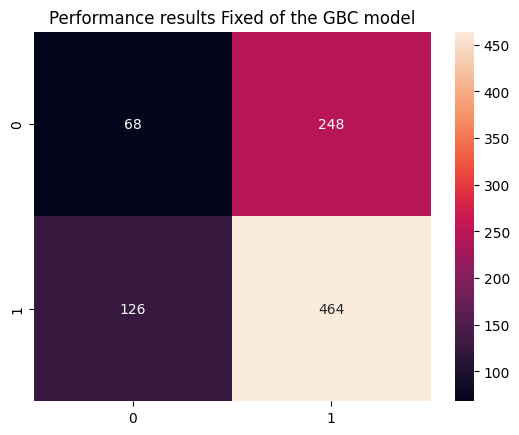


Feature Importance of the model



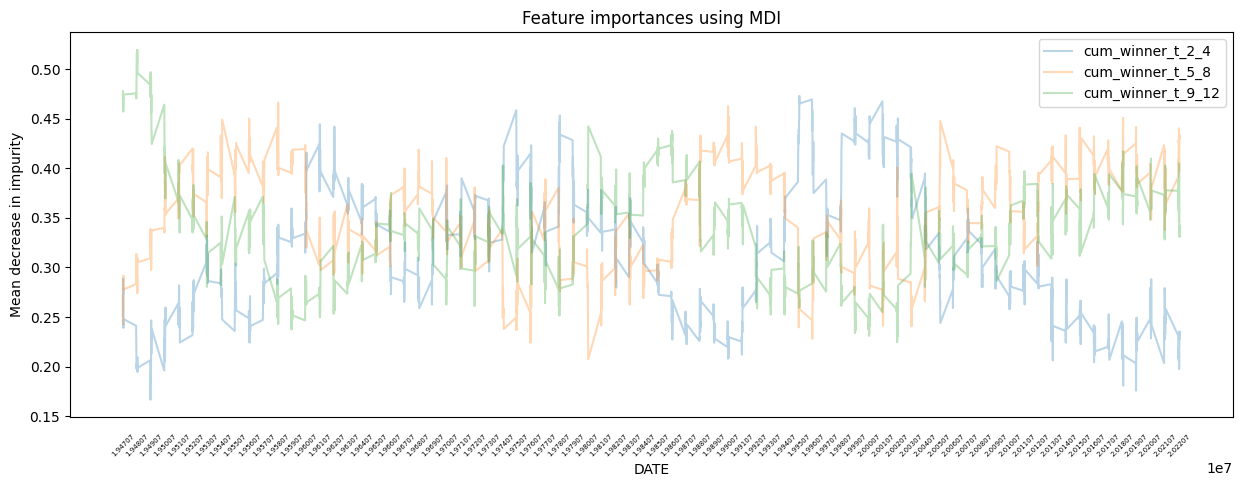

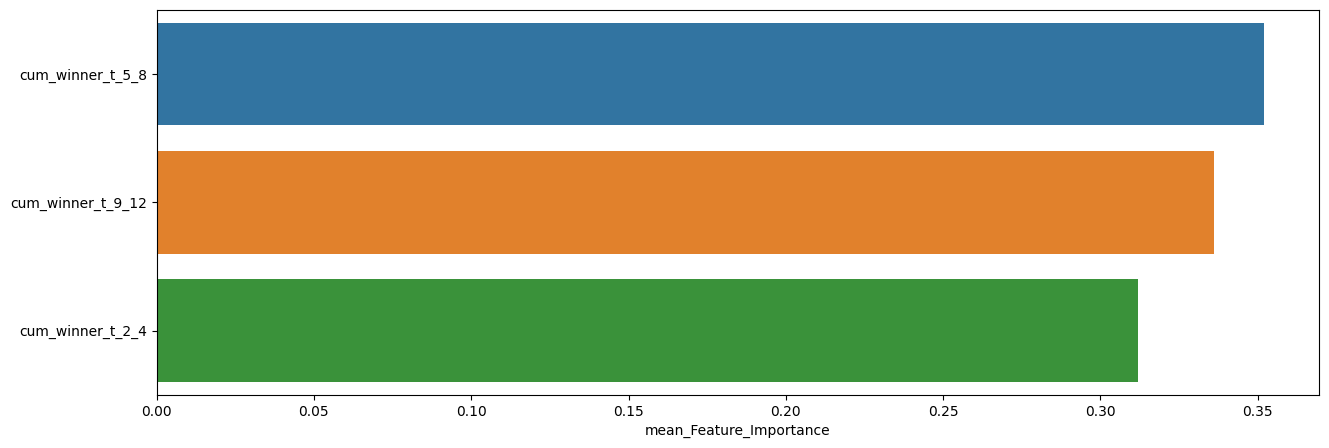

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                  0.351892                0.466344   
cum_winner_t_9_12                 0.336153                0.519310   
cum_winner_t_2_4                  0.311956                0.472864   

                   min_Feature_Importance  
cum_winner_t_5_8                 0.207787  
cum_winner_t_9_12                0.224731  
cum_winner_t_2_4                 0.166815

In [96]:
Fixed_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=GBC, # 사용할 모델
                                  model_name='GBC', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.20      0.24        75
         1.0       0.66      0.77      0.71       151

    accuracy                           0.58       226
   macro avg       0.48      0.48      0.47       226
weighted avg       0.54      0.58      0.55       226


accuracy : 0.5796460176991151

precision : 0.6590909090909091

recall : 0.7682119205298014

F1-Score : 0.7094801223241591



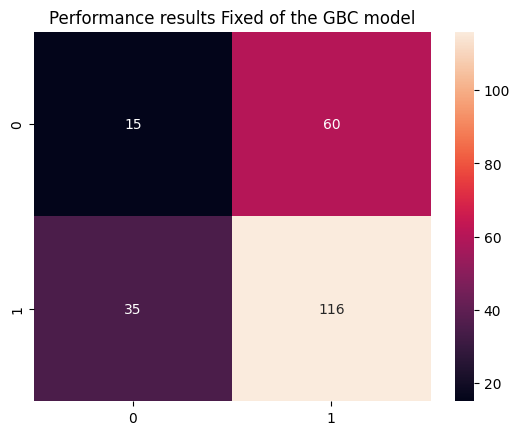


Feature Importance of the model



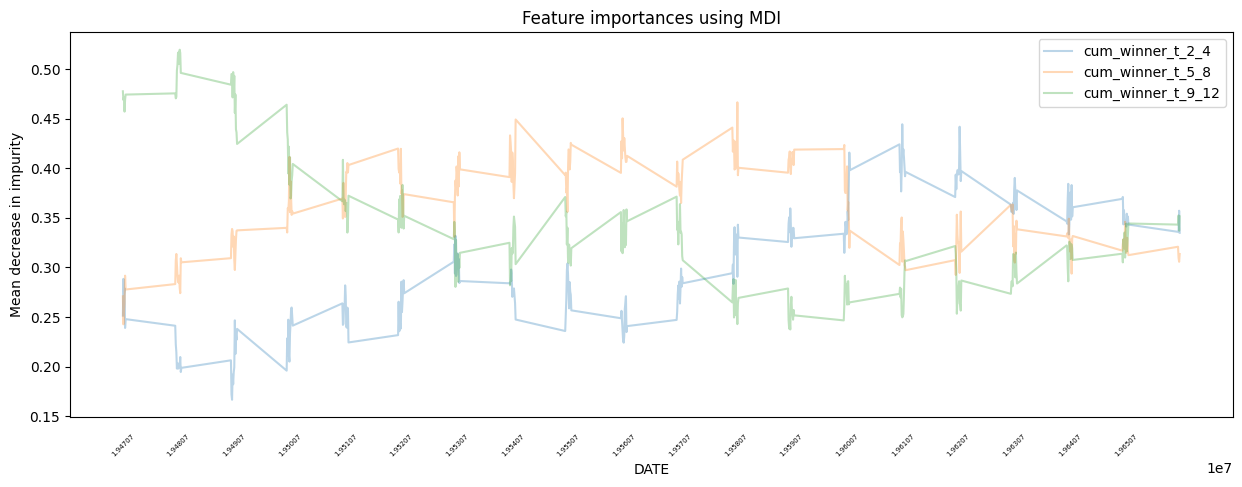

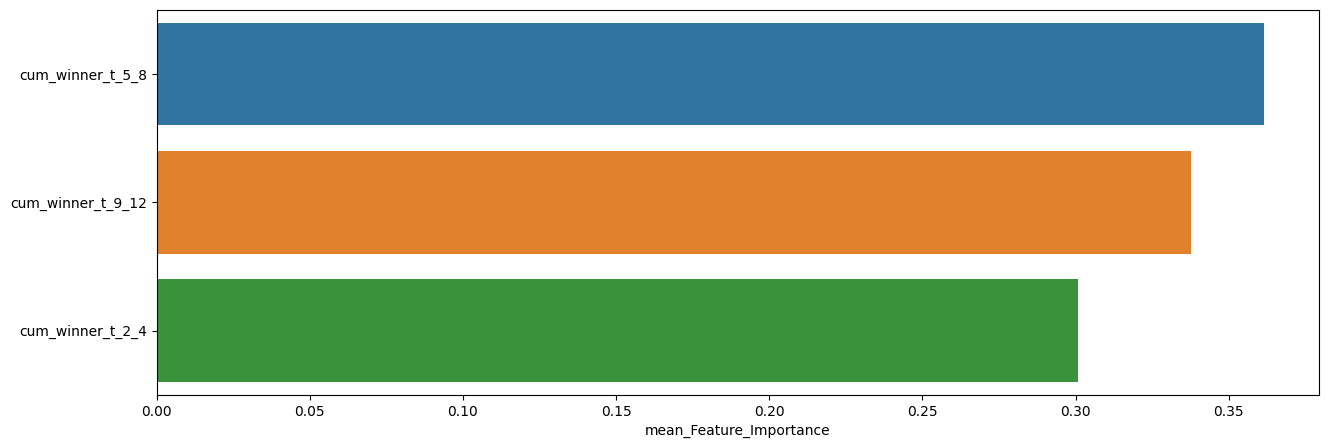

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                  0.361431                0.466344   
cum_winner_t_9_12                 0.337704                0.519310   
cum_winner_t_2_4                  0.300865                0.444254   

                   min_Feature_Importance  
cum_winner_t_5_8                 0.242760  
cum_winner_t_9_12                0.237591  
cum_winner_t_2_4                 0.166815


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.27      0.17      0.21        75
         1.0       0.65      0.77      0.71       151

    accuracy                           0.57       226
   macro avg       0.46      0.47      0.46       226
weighted avg       0.53      0.57      0.54       226


accuracy : 0.5707964601769911

precision : 0.651685393258427

recall : 0.7682119205298014

F1-Score : 0.7051671732522796



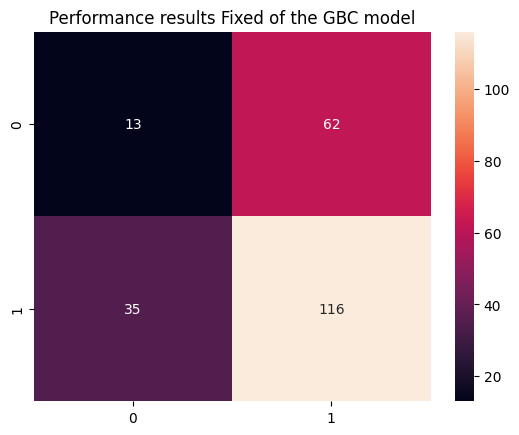


Feature Importance of the model



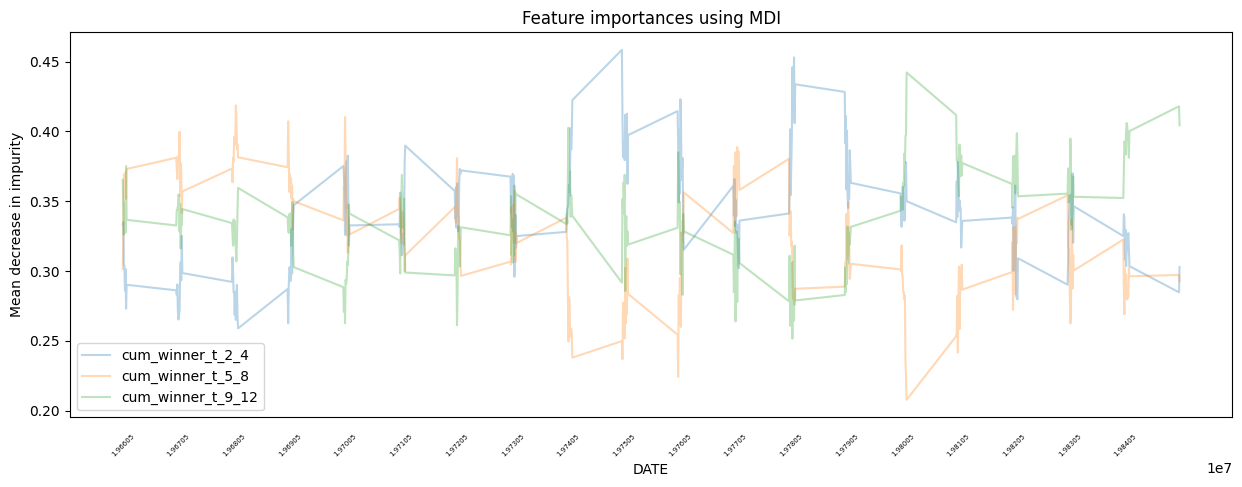

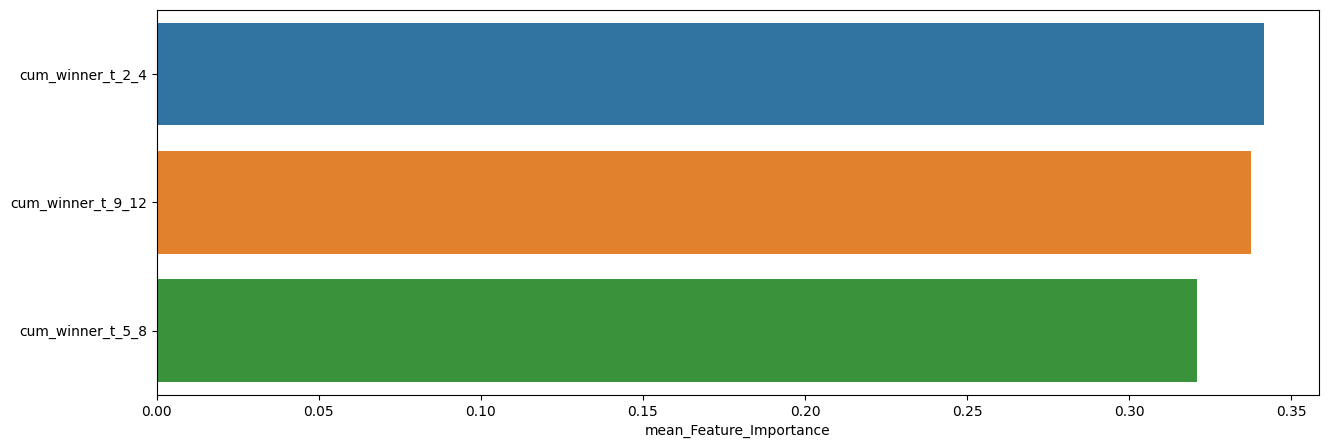

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_2_4                  0.341469                0.458441   
cum_winner_t_9_12                 0.337650                0.442201   
cum_winner_t_5_8                  0.320881                0.418644   

                   min_Feature_Importance  
cum_winner_t_2_4                 0.258968  
cum_winner_t_9_12                0.251624  
cum_winner_t_5_8                 0.207787


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.21      0.26        70
         1.0       0.70      0.81      0.75       156

    accuracy                           0.63       226
   macro avg       0.52      0.51      0.51       226
weighted avg       0.59      0.63      0.60       226


accuracy : 0.6283185840707964

precision : 0.6978021978021978

recall : 0.8141025641025641

F1-Score : 0.7514792899408284



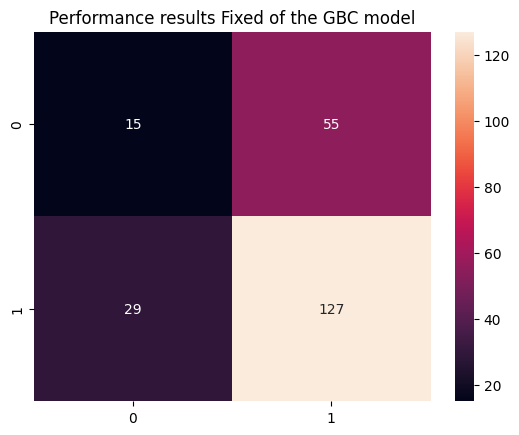


Feature Importance of the model



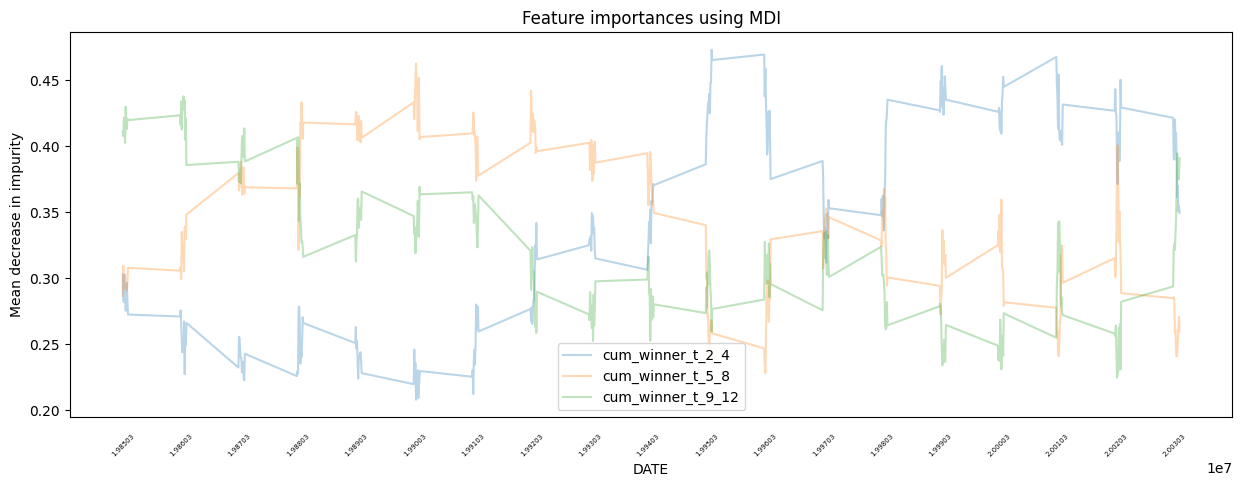

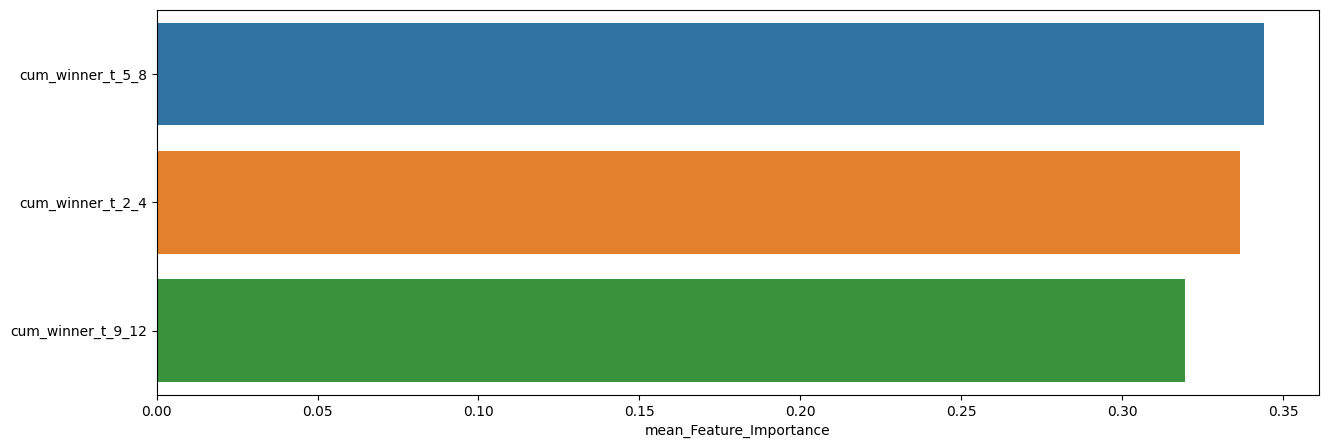

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                  0.344012                0.462519   
cum_winner_t_2_4                  0.336569                0.472864   
cum_winner_t_9_12                 0.319419                0.437600   

                   min_Feature_Importance  
cum_winner_t_5_8                 0.228143  
cum_winner_t_2_4                 0.208034  
cum_winner_t_9_12                0.224731


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.48      0.26      0.34        96
         1.0       0.60      0.80      0.68       132

    accuracy                           0.57       228
   macro avg       0.54      0.53      0.51       228
weighted avg       0.55      0.57      0.54       228


accuracy : 0.5701754385964912

precision : 0.5965909090909091

recall : 0.7954545454545454

F1-Score : 0.6818181818181818



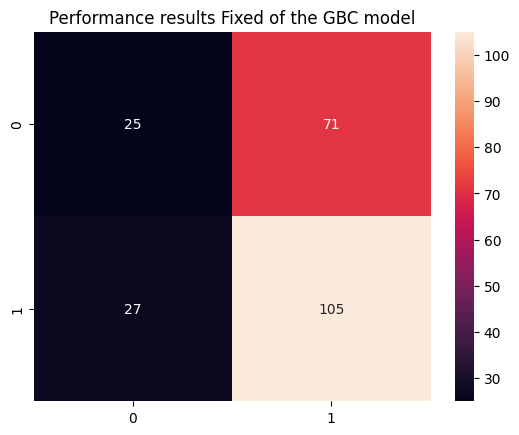


Feature Importance of the model



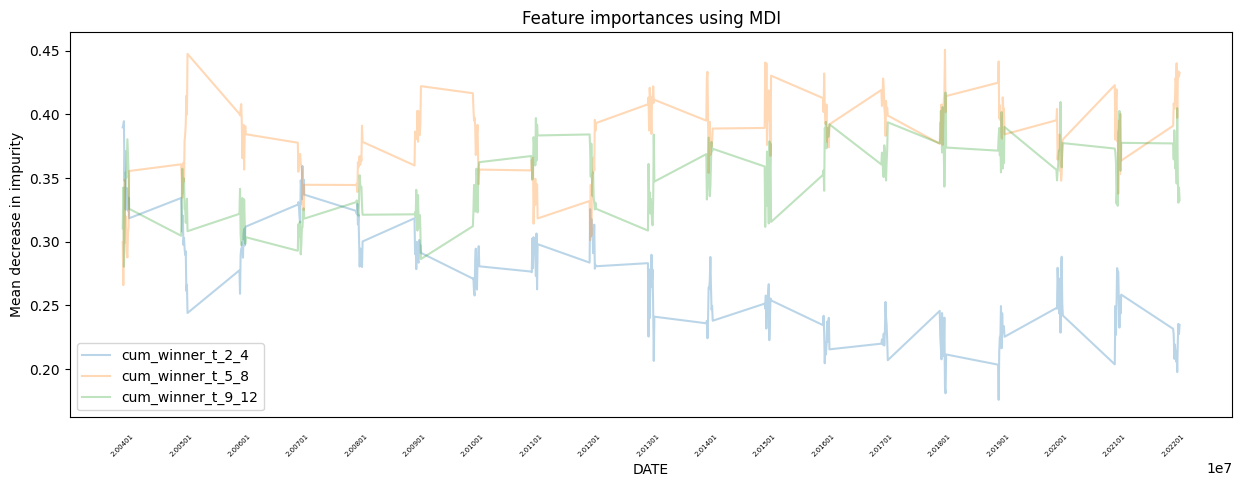

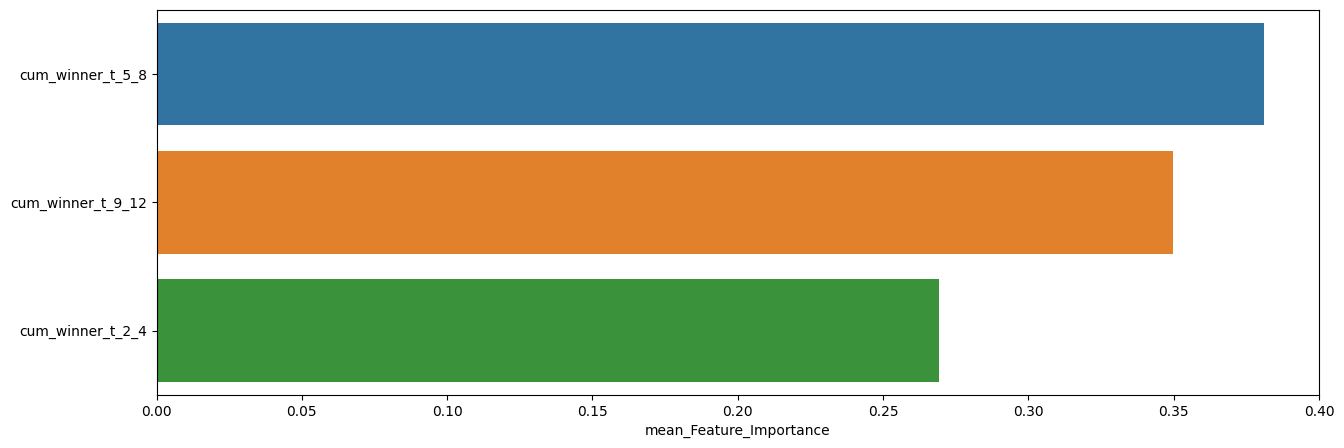

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                  0.380985                0.450715   
cum_winner_t_9_12                 0.349717                0.417168   
cum_winner_t_2_4                  0.269297                0.394714   

                   min_Feature_Importance  
cum_winner_t_5_8                 0.265970  
cum_winner_t_9_12                0.280420  
cum_winner_t_2_4                 0.175944

In [97]:
slice_feature_importance(Fixed_GBC_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'GBC') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



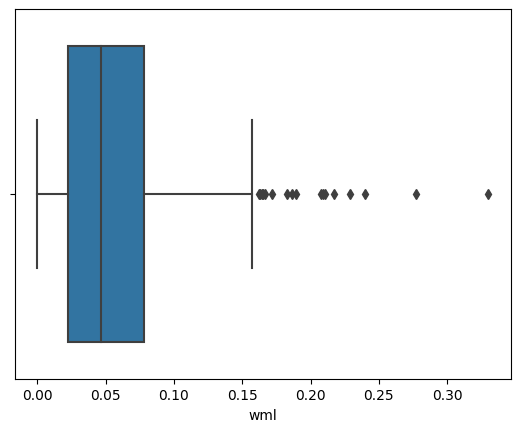

count      mean       std       min       25%      50%       75%  \
wml  464.0  0.055908  0.046692  0.000007  0.022171  0.04627  0.078041   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



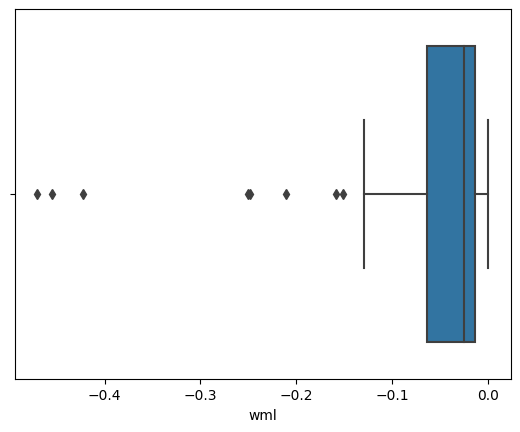

count      mean       std       min       25%       50%       75%  \
wml   68.0 -0.064001  0.099428 -0.469903 -0.063792 -0.025577 -0.013501   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



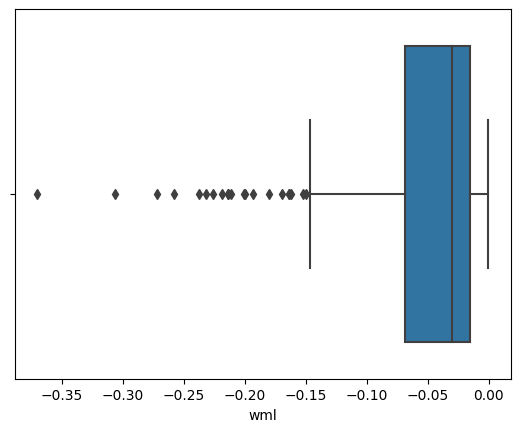

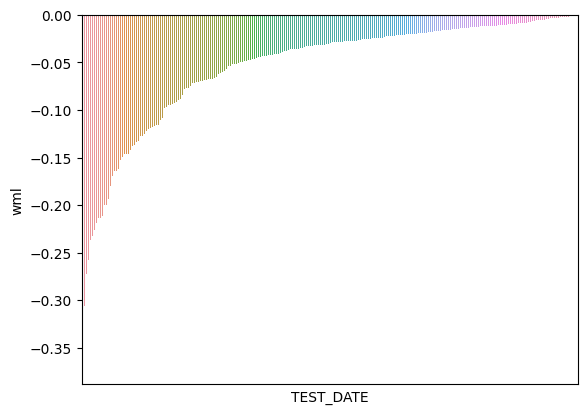

count      mean       std       min       25%       50%       75%  \
wml  248.0 -0.054203  0.061393 -0.370041 -0.068483 -0.029971 -0.015258   

          max  
wml -0.000183


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



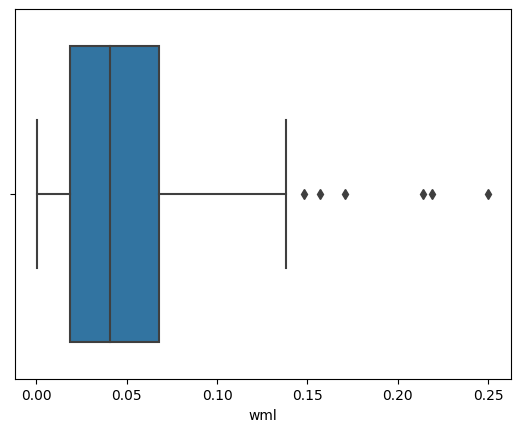

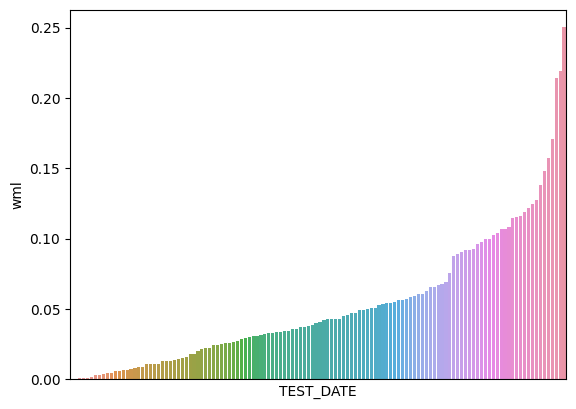

count      mean       std       min       25%       50%       75%  \
wml  126.0  0.052826  0.047356  0.000577  0.018665  0.040671  0.067839   

          max  
wml  0.250175

In [98]:
GBC_A0_P1, GBC_A1_P0 = What_Pred(Fixed_GBC_Result, WML, 'GBC')

Sharpe Ratio : 0.64873

최근 누적 수익률

  2022년-12월 -> 33234.68
  2022년-11월 -> 29943.77
  2022년-10월 -> 28482.80
  2022년-09월 -> 25221.04
  2022년-08월 -> 25221.04

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 33234.68
  2등 : 2022년-11월 -> 29943.77
  3등 : 2022년-10월 -> 28482.80
  4등 : 2022년-07월 -> 25784.60
  5등 : 2022년-09월 -> 25221.04
  6등 : 2022년-08월 -> 25221.04
  7등 : 2022년-06월 -> 24704.64
  8등 : 2022년-05월 -> 24391.86
  9등 : 2022년-04월 -> 22879.03
  10등 : 2016년-01월 -> 22842.88



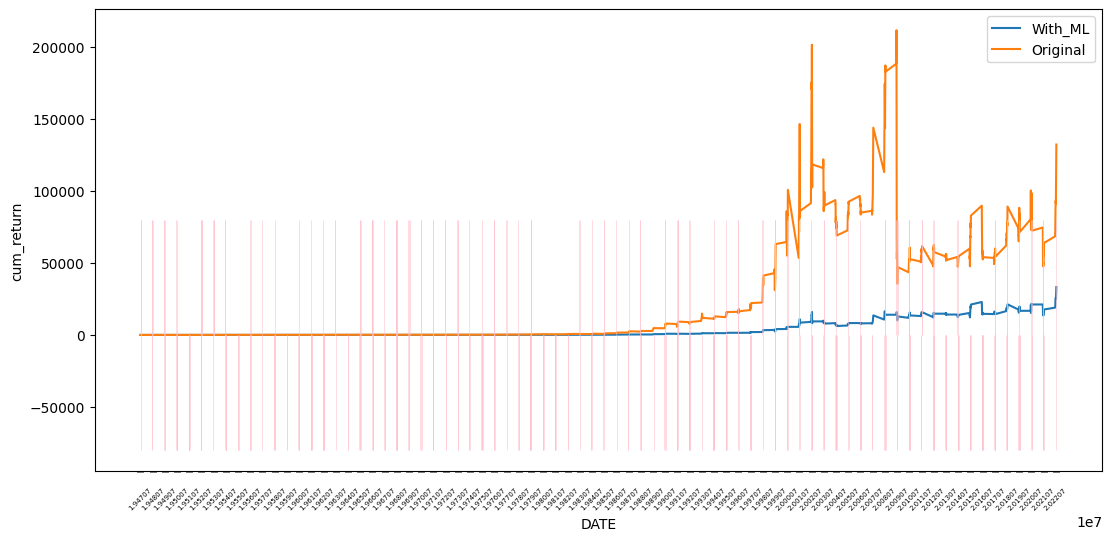

In [99]:
GBC_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_GBC_Result,
                                                 WML,
                                                 'GBC_PRED_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.72675

최근 누적 수익률

  2022년-12월 -> 7121.33
  2022년-11월 -> 6572.63
  2022년-10월 -> 6366.01
  2022년-09월 -> 5938.24
  2022년-08월 -> 5710.27

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 7121.33
  2등 : 2022년-11월 -> 6572.63
  3등 : 2022년-10월 -> 6366.01
  4등 : 2002년-09월 -> 6066.73
  5등 : 2022년-09월 -> 5938.24
  6등 : 2022년-07월 -> 5818.17
  7등 : 2022년-08월 -> 5710.27
  8등 : 2020년-09월 -> 5677.66
  9등 : 2020년-10월 -> 5660.50
  10등 : 2020년-08월 -> 5655.30



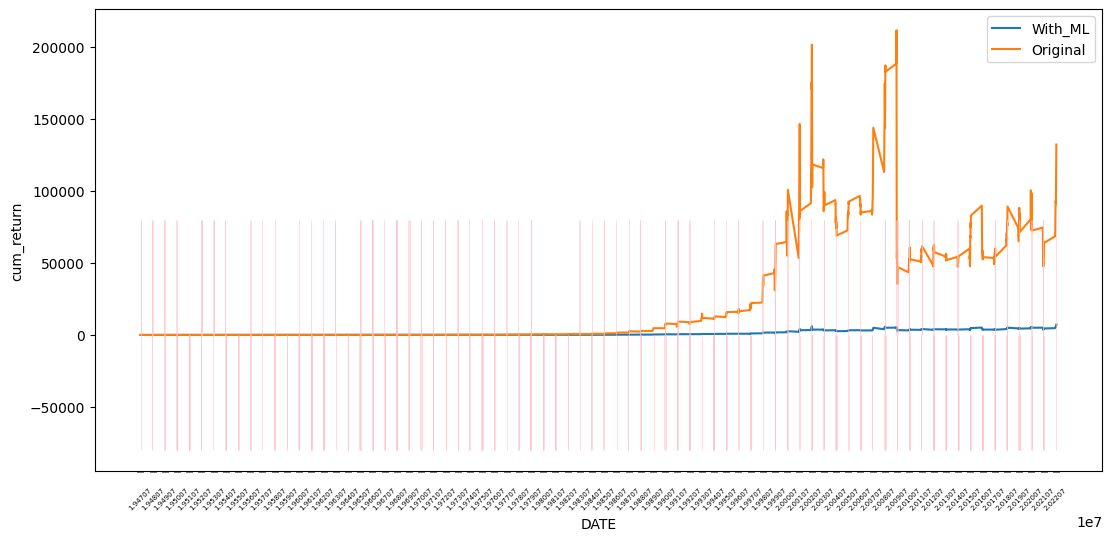

In [100]:
GBC_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_GBC_Result,
                                                 WML,
                                                 'GBC_PROB_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

### XGB

In [101]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

**************************************************

XGB Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : None
 

  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.32      0.35       316
         1.0       0.67      0.74      0.70       590

    accuracy                           0.59       906
   macro avg       0.53      0.53      0.53       906
weighted avg       0.57      0.59      0.58       906


accuracy : 0.5916114790286976

precision : 0.6687116564417178

recall : 0.7389830508474576

F1-Score : 0.7020933977455717



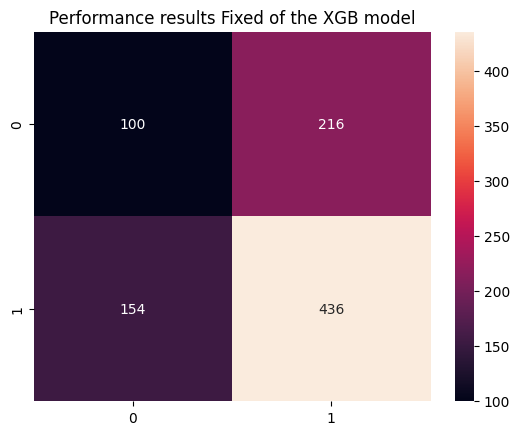


Feature Importance of the model



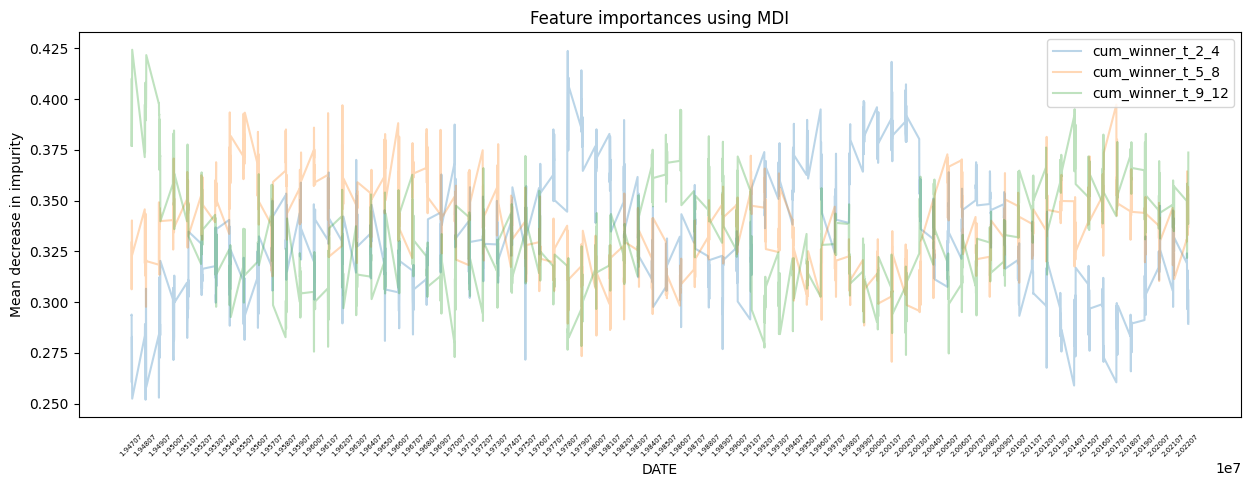

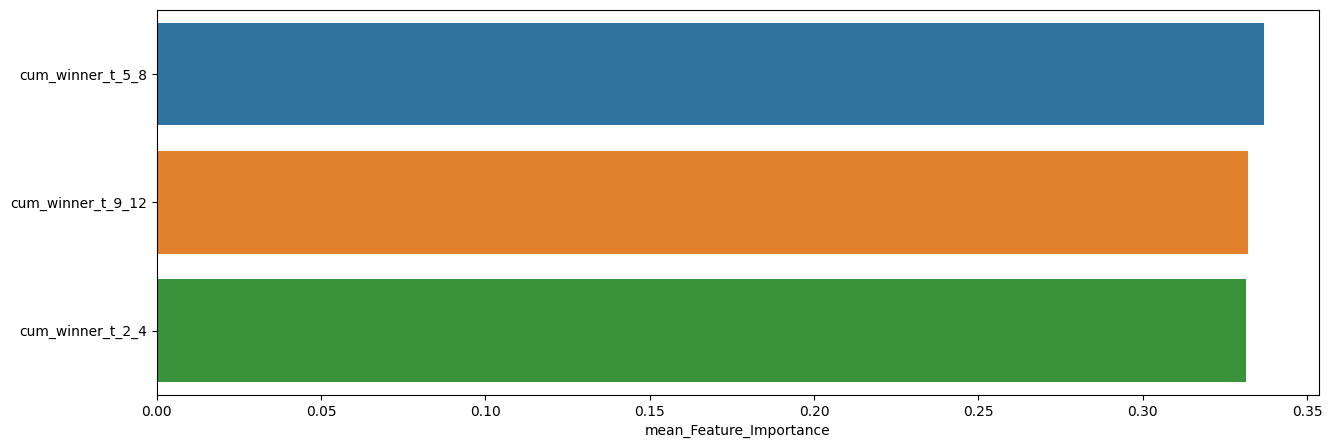

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                  0.336768                0.397237   
cum_winner_t_9_12                 0.331998                0.424306   
cum_winner_t_2_4                  0.331234                0.423714   

                   min_Feature_Importance  
cum_winner_t_5_8                 0.270590  
cum_winner_t_9_12                0.272903  
cum_winner_t_2_4                 0.251888

In [102]:
Fixed_XGB_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=XGB, # 사용할 모델
                                  model_name='XGB', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.37      0.38        75
         1.0       0.69      0.70      0.69       151

    accuracy                           0.59       226
   macro avg       0.53      0.53      0.53       226
weighted avg       0.59      0.59      0.59       226


accuracy : 0.588495575221239

precision : 0.6907894736842105

recall : 0.695364238410596

F1-Score : 0.6930693069306931



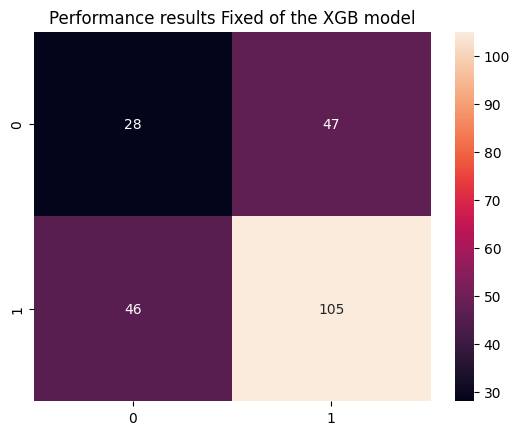


Feature Importance of the model



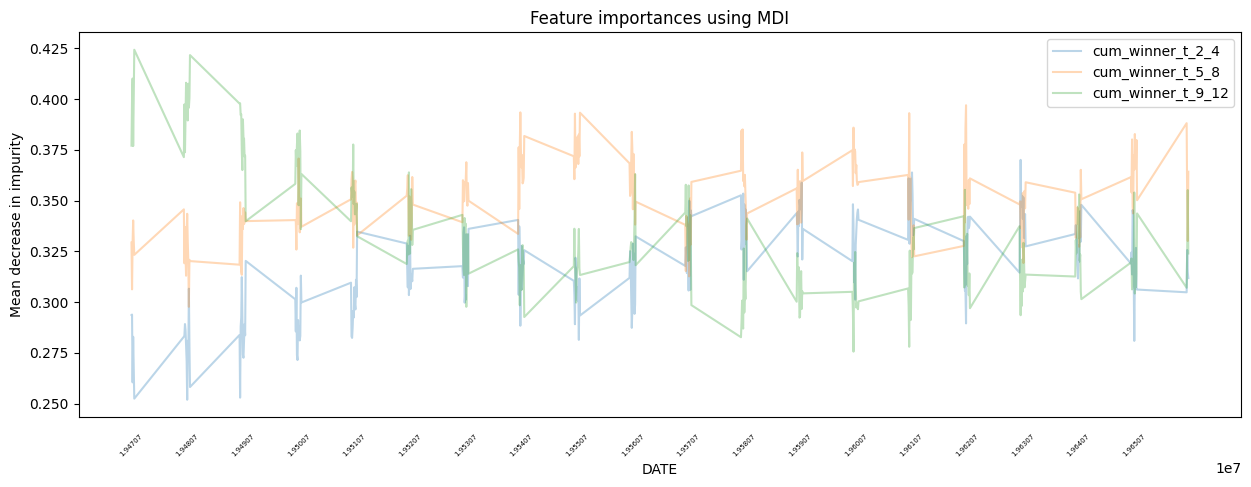

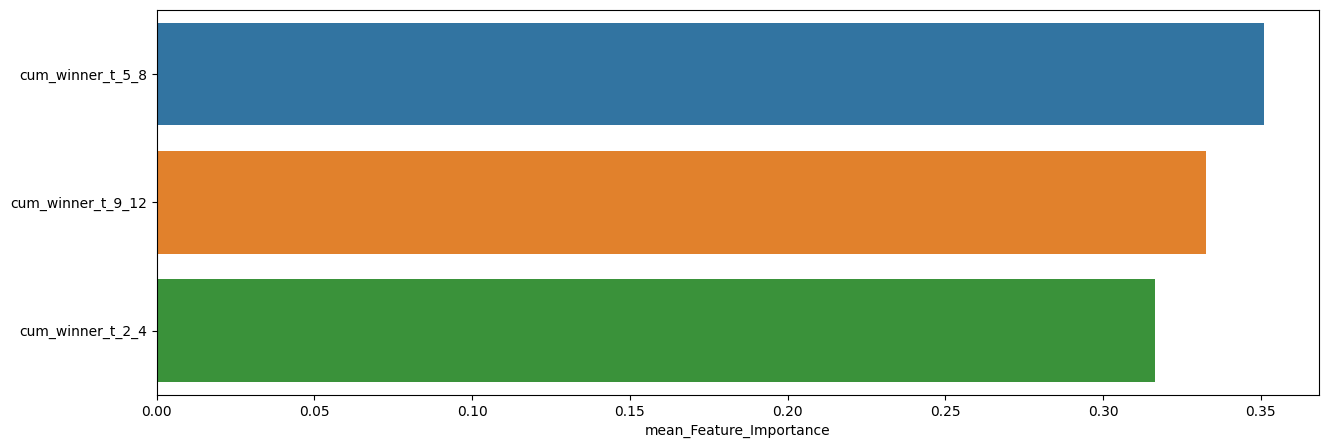

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                  0.350942                0.396968   
cum_winner_t_9_12                 0.332530                0.424306   
cum_winner_t_2_4                  0.316527                0.370048   

                   min_Feature_Importance  
cum_winner_t_5_8                 0.297664  
cum_winner_t_9_12                0.275586  
cum_winner_t_2_4                 0.251888


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.27      0.30        75
         1.0       0.67      0.75      0.71       151

    accuracy                           0.59       226
   macro avg       0.51      0.51      0.50       226
weighted avg       0.56      0.59      0.57       226


accuracy : 0.588495575221239

precision : 0.6726190476190477

recall : 0.7483443708609272

F1-Score : 0.7084639498432602



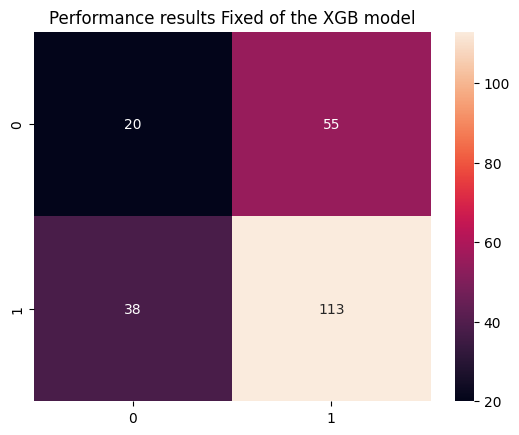


Feature Importance of the model



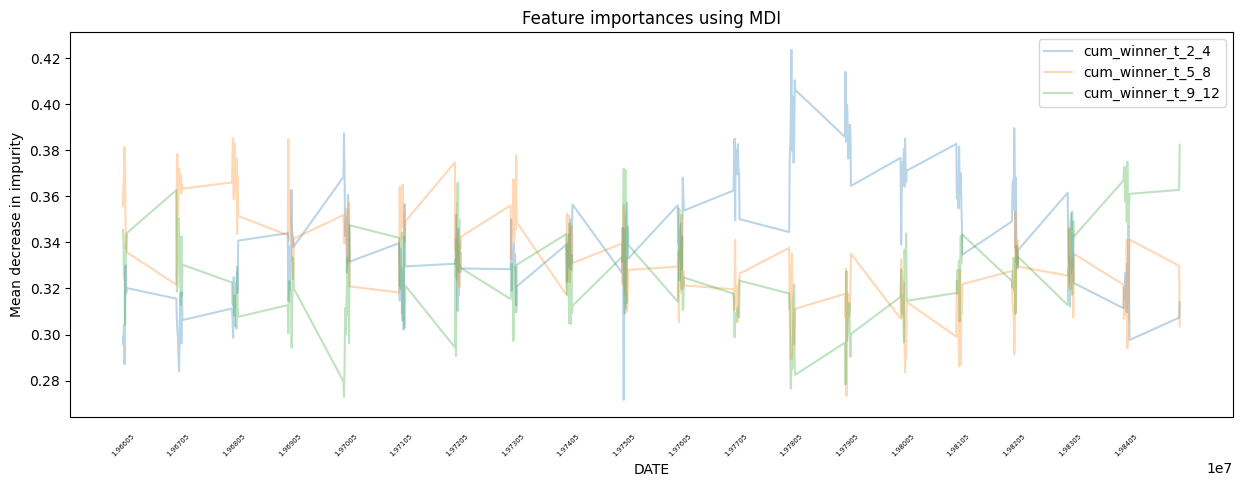

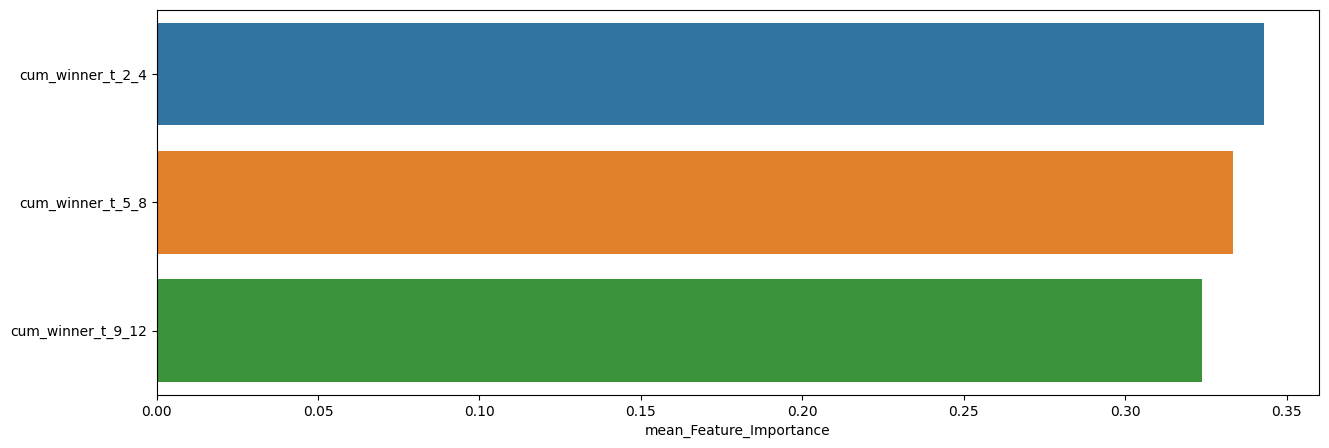

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_2_4                  0.342879                0.423714   
cum_winner_t_5_8                  0.333282                0.385255   
cum_winner_t_9_12                 0.323839                0.382464   

                   min_Feature_Importance  
cum_winner_t_2_4                 0.271619  
cum_winner_t_5_8                 0.273369  
cum_winner_t_9_12                0.272903


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.29      0.32        70
         1.0       0.71      0.77      0.74       156

    accuracy                           0.62       226
   macro avg       0.53      0.53      0.53       226
weighted avg       0.60      0.62      0.61       226


accuracy : 0.6194690265486725

precision : 0.7058823529411765

recall : 0.7692307692307693

F1-Score : 0.736196319018405



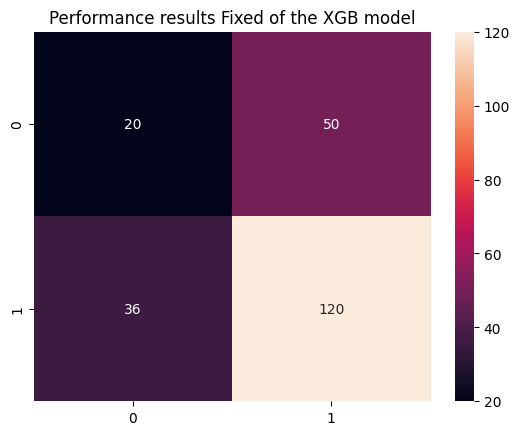


Feature Importance of the model



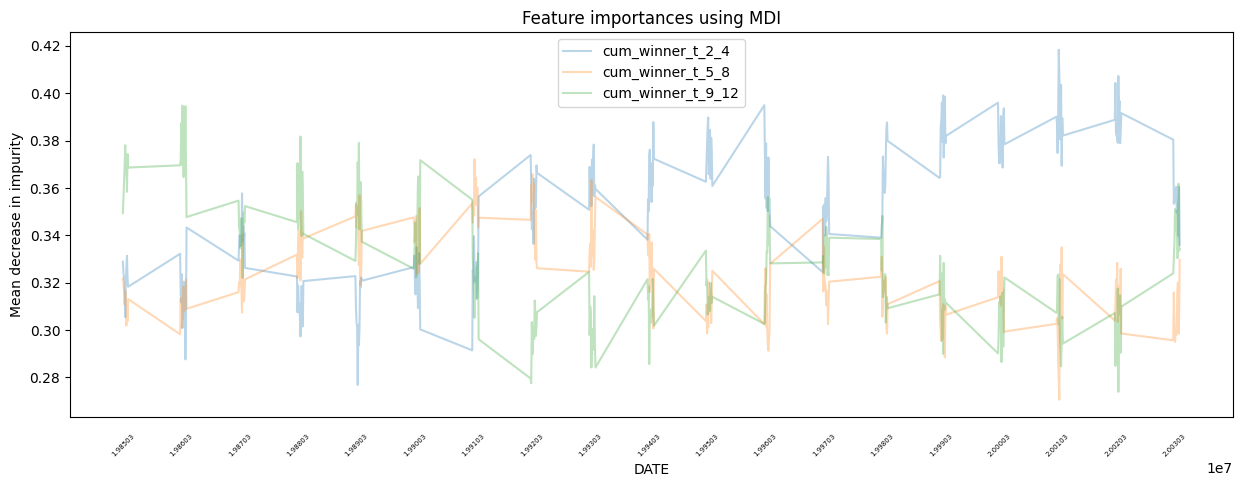

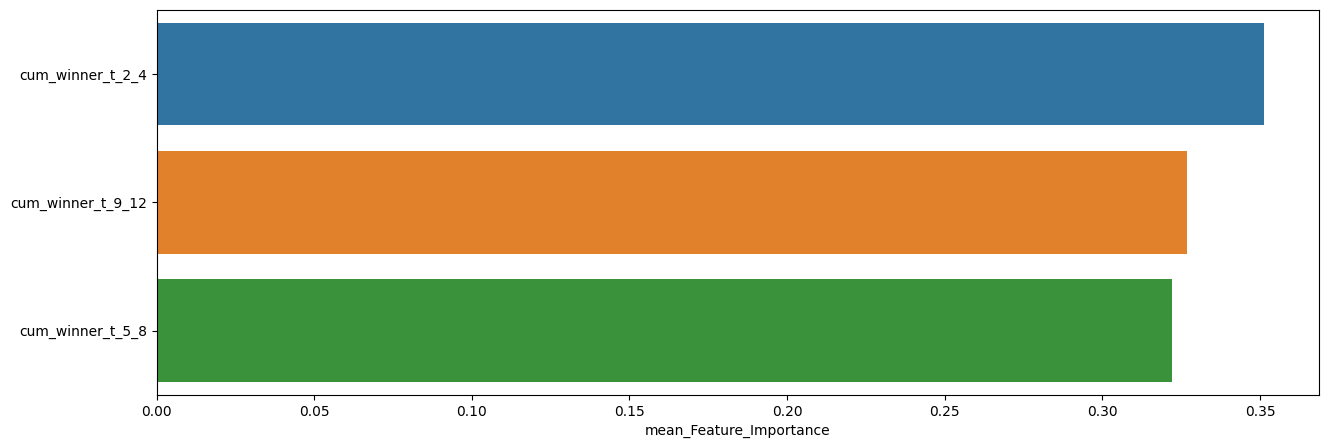

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_2_4                  0.351204                0.418345   
cum_winner_t_9_12                 0.326747                0.394750   
cum_winner_t_5_8                  0.322049                0.372119   

                   min_Feature_Importance  
cum_winner_t_2_4                 0.276823  
cum_winner_t_9_12                0.273941  
cum_winner_t_5_8                 0.270590


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.48      0.33      0.40        96
         1.0       0.60      0.74      0.67       132

    accuracy                           0.57       228
   macro avg       0.54      0.54      0.53       228
weighted avg       0.55      0.57      0.55       228


accuracy : 0.5701754385964912

precision : 0.6049382716049383

recall : 0.7424242424242424

F1-Score : 0.6666666666666666



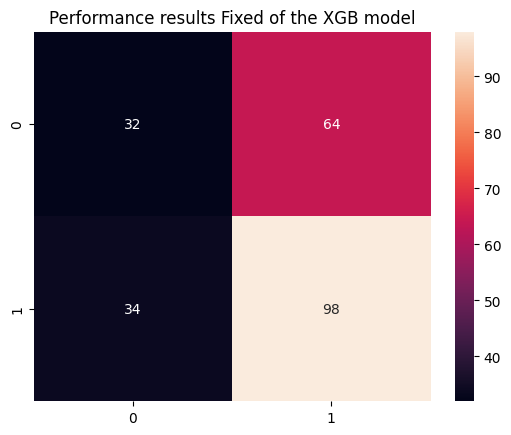


Feature Importance of the model



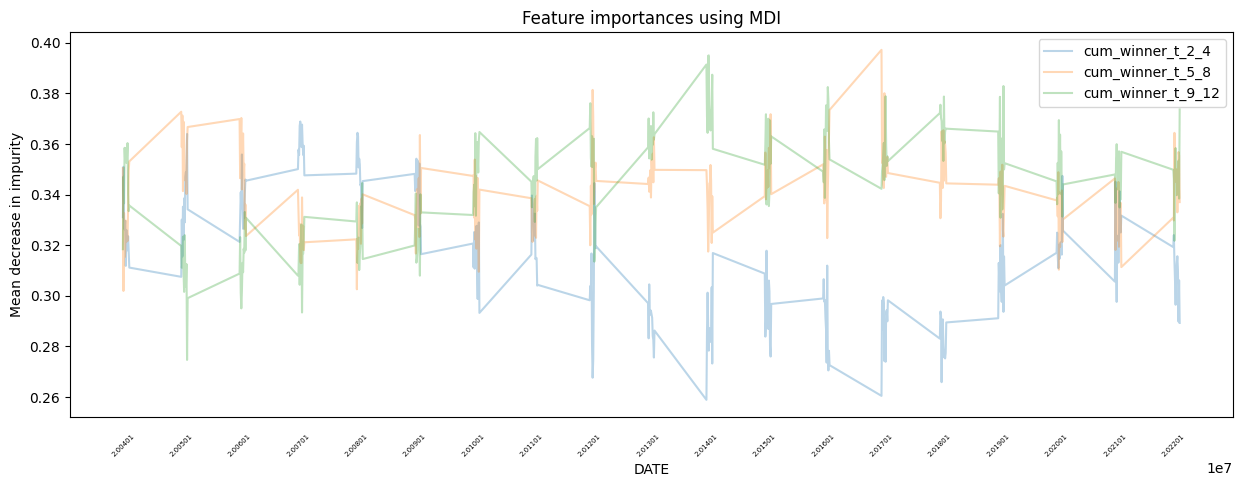

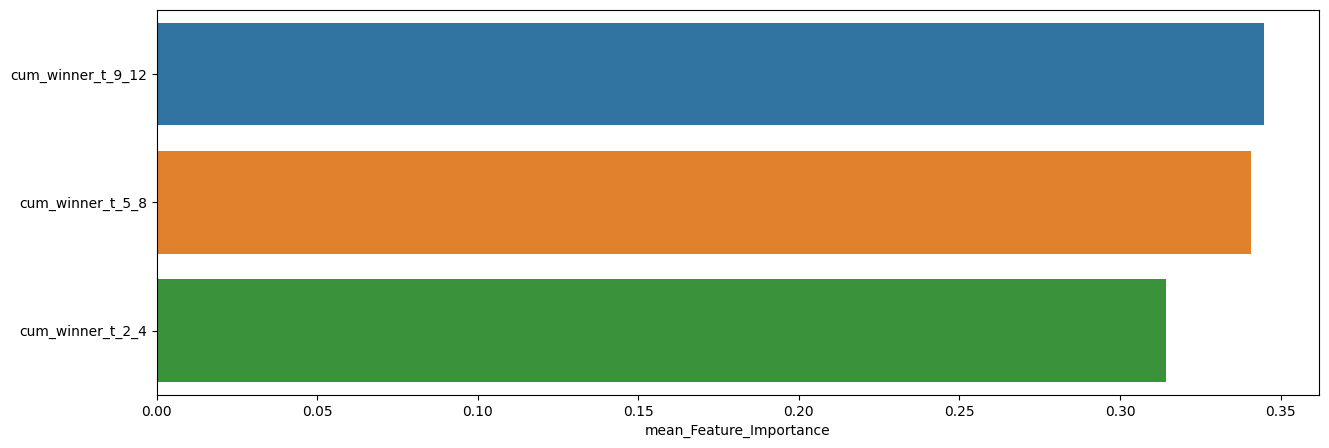

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12                 0.344763                0.395038   
cum_winner_t_5_8                  0.340763                0.397237   
cum_winner_t_2_4                  0.314474                0.368891   

                   min_Feature_Importance  
cum_winner_t_9_12                0.274672  
cum_winner_t_5_8                 0.301935  
cum_winner_t_2_4                 0.258894

In [103]:
slice_feature_importance(Fixed_XGB_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'XGB') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



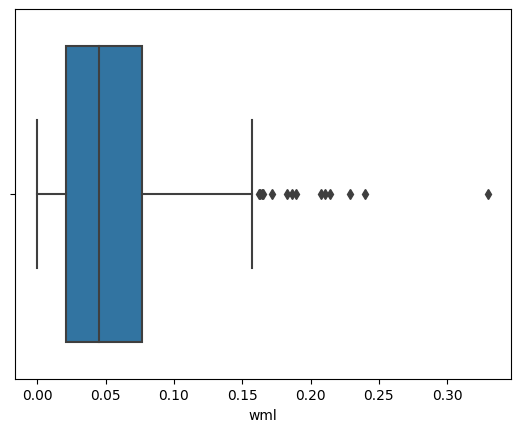

count      mean       std       min       25%       50%       75%  \
wml  436.0  0.054526  0.045545  0.000007  0.021166  0.045208  0.076751   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



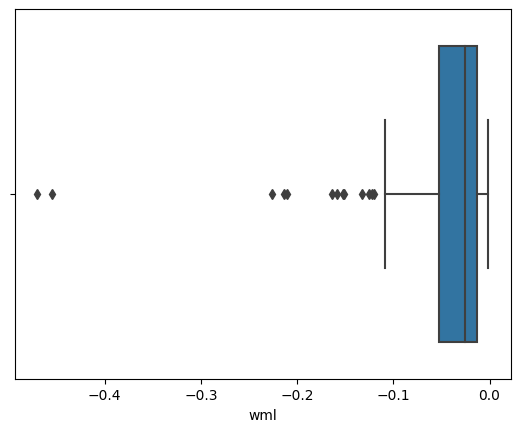

count      mean       std       min       25%       50%      75%      max
wml  100.0 -0.053056  0.076246 -0.469903 -0.052441 -0.025577 -0.01352 -0.00129


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



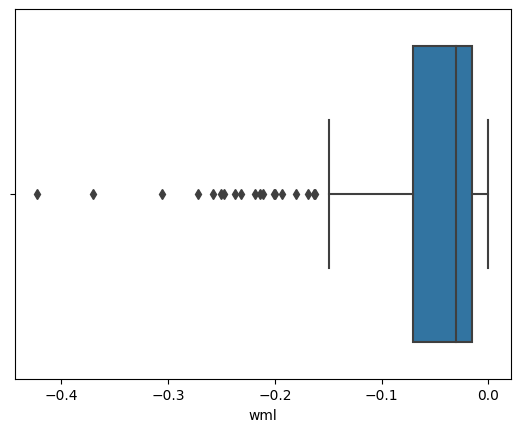

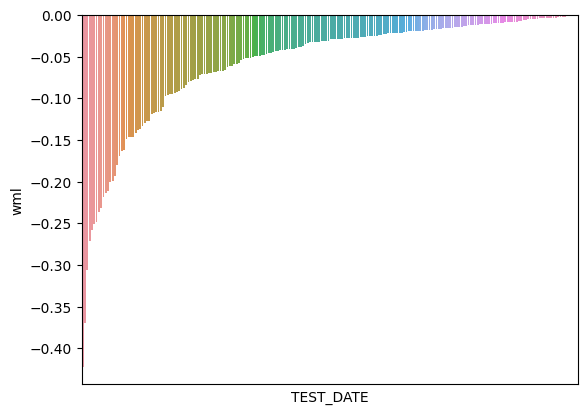

count      mean       std     min       25%       50%       75%       max
wml  216.0 -0.057818  0.068924 -0.4224 -0.070805 -0.030143 -0.015258 -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



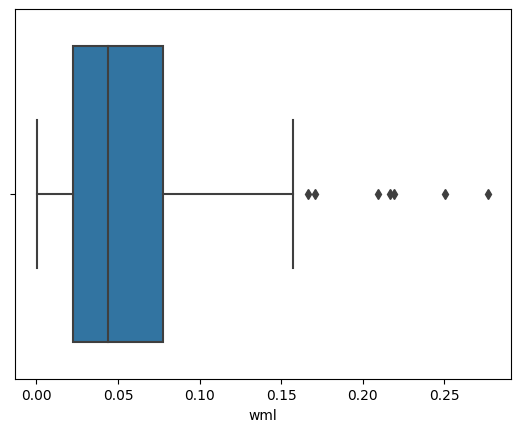

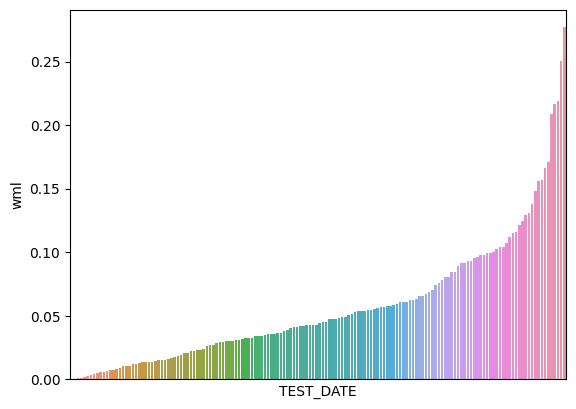

count      mean       std       min       25%       50%       75%  \
wml  154.0  0.057298  0.050322  0.000577  0.022313  0.043656  0.077506   

          max  
wml  0.276912

In [104]:
XGB_A0_P1, XGB_A1_P0 = What_Pred(Fixed_XGB_Result, WML, 'XGB')

Sharpe Ratio : 0.72307

최근 누적 수익률

  2022년-12월 -> 10264.45
  2022년-11월 -> 9247.99
  2022년-10월 -> 9247.99
  2022년-09월 -> 8188.86
  2022년-08월 -> 8188.86

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2001년-09월 -> 14607.81
  2등 : 2002년-09월 -> 14028.51
  3등 : 2008년-06월 -> 12890.75
  4등 : 2009년-02월 -> 12620.92
  5등 : 2002년-07월 -> 12215.73
  6등 : 2001년-08월 -> 12098.70
  7등 : 2002년-08월 -> 11861.80
  8등 : 2002년-06월 -> 11582.10
  9등 : 2002년-10월 -> 11318.76
  10등 : 2016년-01월 -> 11261.46



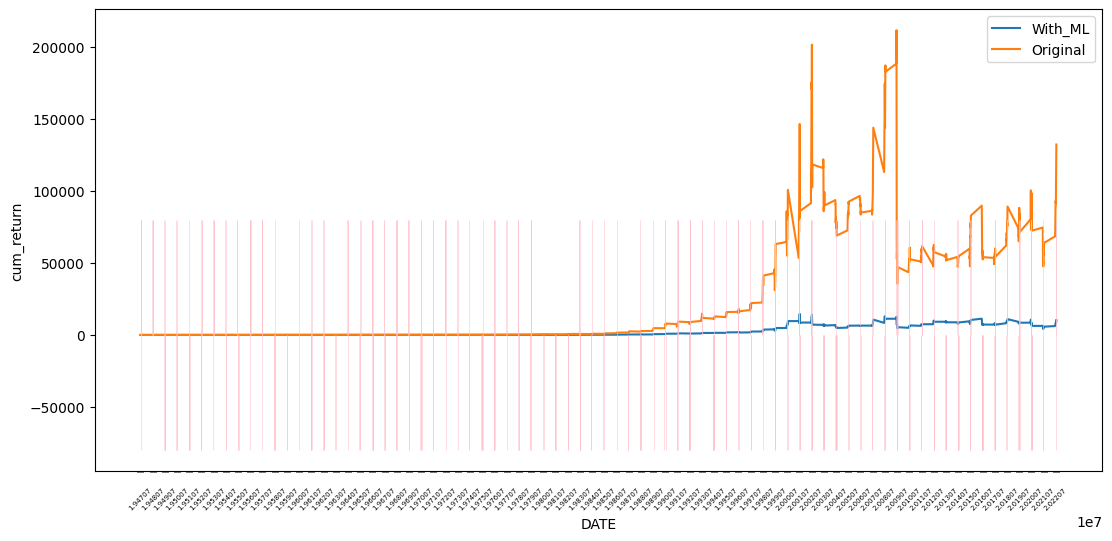

In [105]:
XGB_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_XGB_Result,
                                                 WML,
                                                 'XGB_PRED_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.71449

최근 누적 수익률

  2022년-12월 -> 9486.43
  2022년-11월 -> 8587.50
  2022년-10월 -> 8535.63
  2022년-09월 -> 7672.83
  2022년-08월 -> 7387.79

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 9486.43
  2등 : 2022년-11월 -> 8587.50
  3등 : 2022년-10월 -> 8535.63
  4등 : 2009년-02월 -> 7958.36
  5등 : 2020년-03월 -> 7838.48
  6등 : 2018년-12월 -> 7725.75
  7등 : 2022년-09월 -> 7672.83
  8등 : 2008년-06월 -> 7584.45
  9등 : 2020년-09월 -> 7521.77
  10등 : 2002년-09월 -> 7521.39



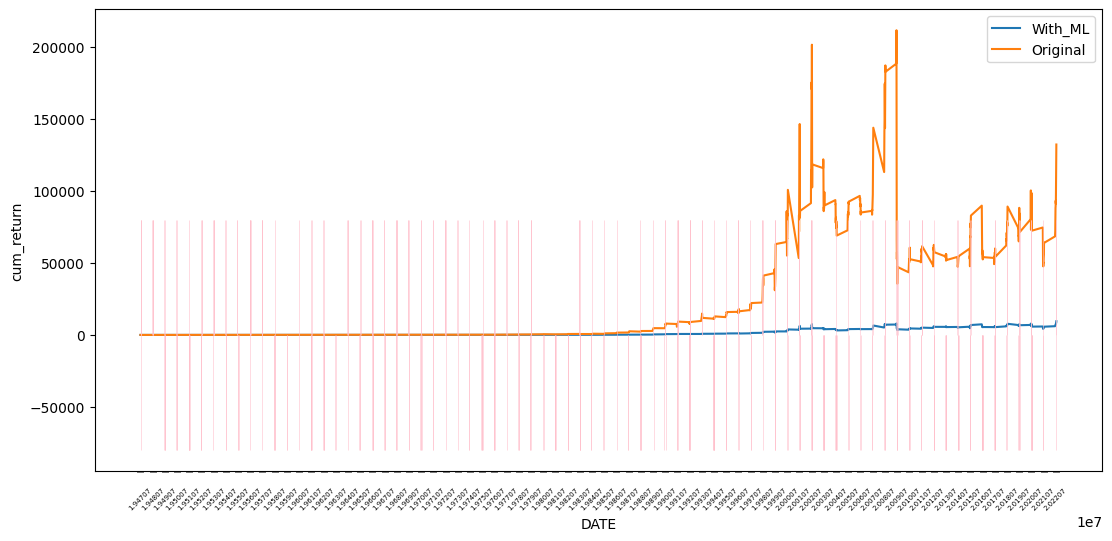

In [106]:
XGB_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_XGB_Result,
                                                 WML,
                                                 'XGB_PROB_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

### LGBM

In [107]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

**************************************************

LGBM Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.26      0.31       316
         1.0       0.66      0.77      0.71       590

    accuracy                           0.59       906
   macro avg       0.52      0.51      0.51       906
weighted avg       0.56      0.59      0.57       906


accuracy : 0.5916114790286976

precision : 0.6598837209302325

recall : 0.7694915254237288

F1-Score : 0.7104851330203442



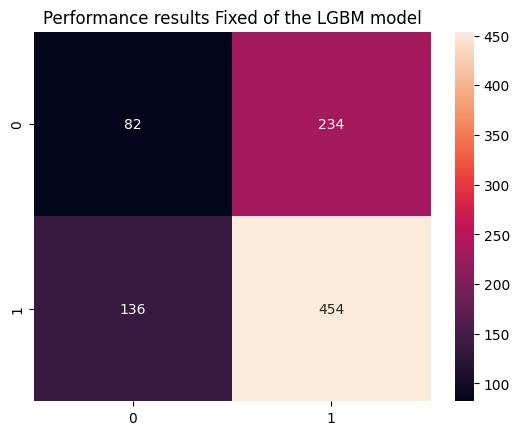


Feature Importance of the model



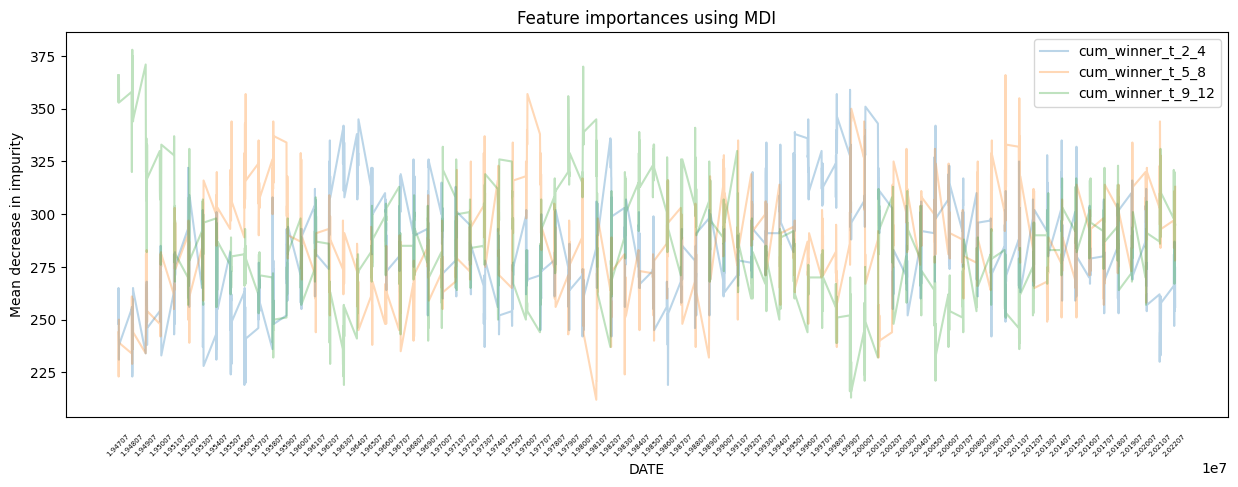

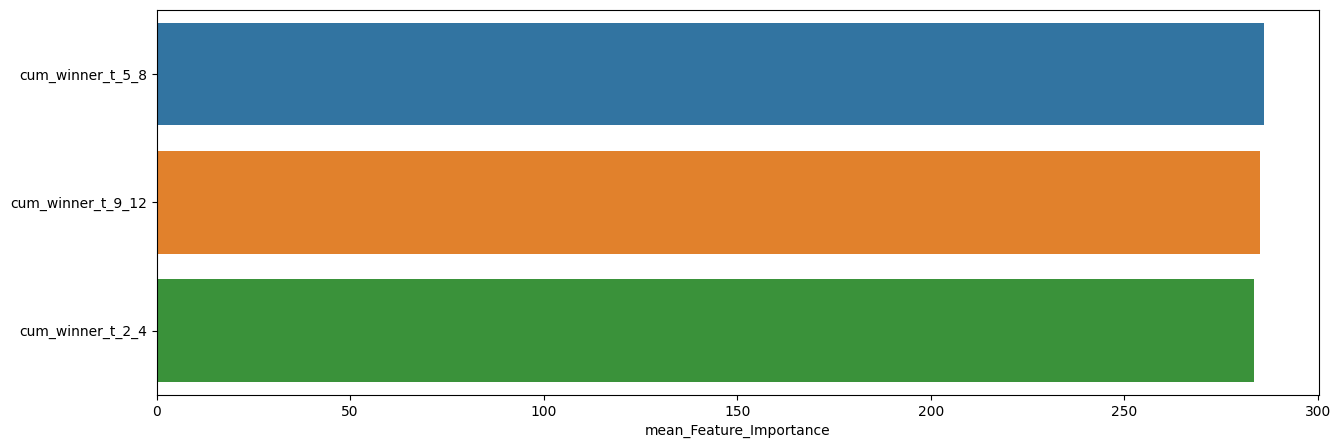

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                286.000000                     366   
cum_winner_t_9_12               285.080574                     378   
cum_winner_t_2_4                283.569536                     359   

                   min_Feature_Importance  
cum_winner_t_5_8                      212  
cum_winner_t_9_12                     213  
cum_winner_t_2_4                      219

In [108]:
Fixed_LGBM_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                    window_size=240, # window size (훈련 데이터 셋 크기)
                                    method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                    model=LGBM, # 사용할 모델
                                    model_name='LGBM', # 사용한 모델 명
                                    plot=True, # 모델 성능 지표 시각화 여부
                                    plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.32      0.35        75
         1.0       0.69      0.74      0.71       151

    accuracy                           0.60       226
   macro avg       0.53      0.53      0.53       226
weighted avg       0.58      0.60      0.59       226


accuracy : 0.5973451327433629

precision : 0.6851851851851852

recall : 0.7350993377483444

F1-Score : 0.7092651757188498



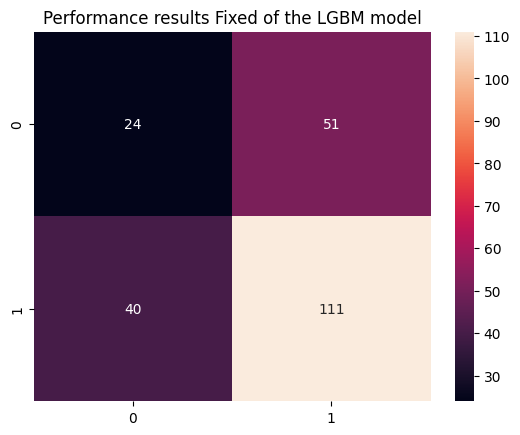


Feature Importance of the model



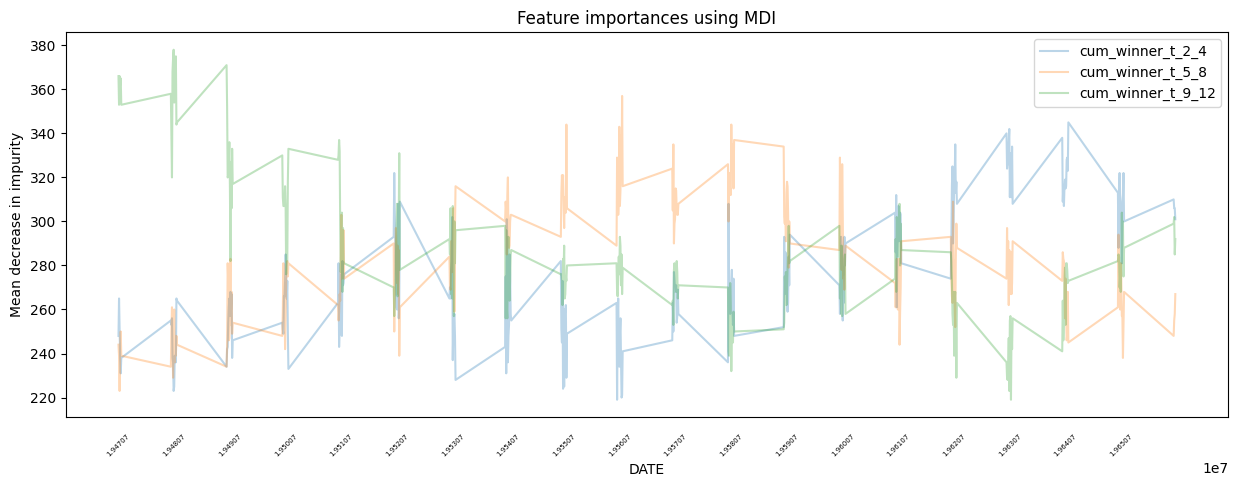

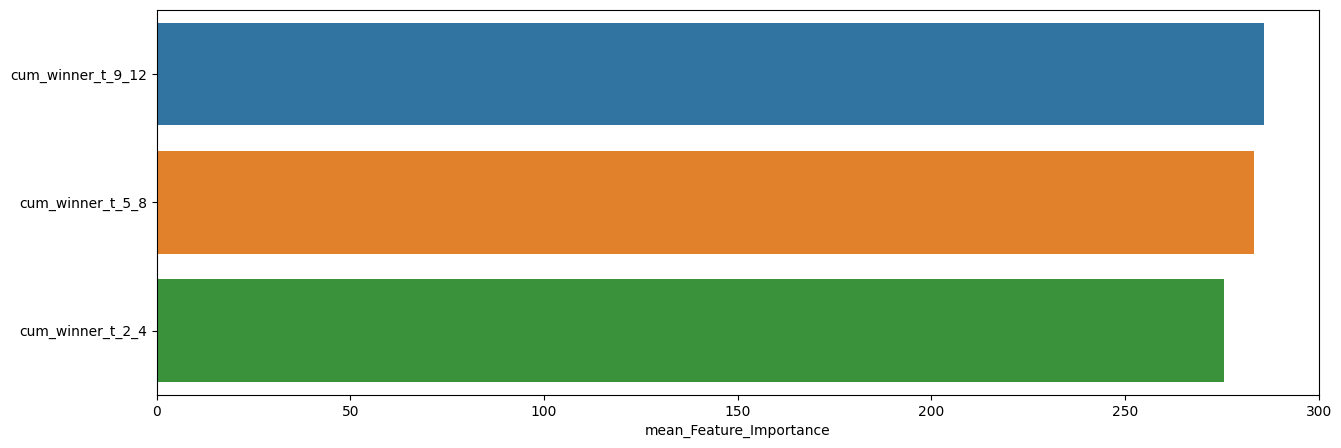

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12               285.778761                     378   
cum_winner_t_5_8                283.261062                     357   
cum_winner_t_2_4                275.460177                     345   

                   min_Feature_Importance  
cum_winner_t_9_12                     219  
cum_winner_t_5_8                      223  
cum_winner_t_2_4                      219


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.23      0.27        75
         1.0       0.67      0.79      0.73       151

    accuracy                           0.60       226
   macro avg       0.51      0.51      0.50       226
weighted avg       0.56      0.60      0.58       226


accuracy : 0.6017699115044248

precision : 0.672316384180791

recall : 0.7880794701986755

F1-Score : 0.7256097560975611



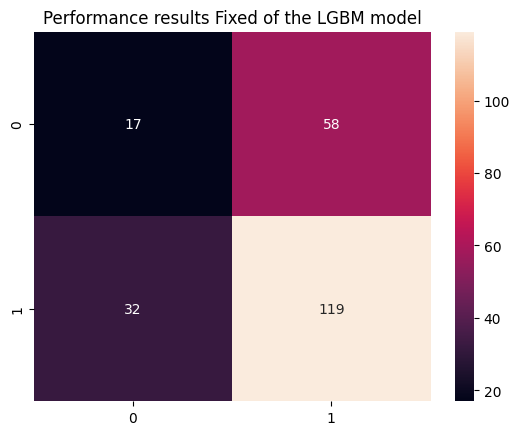


Feature Importance of the model



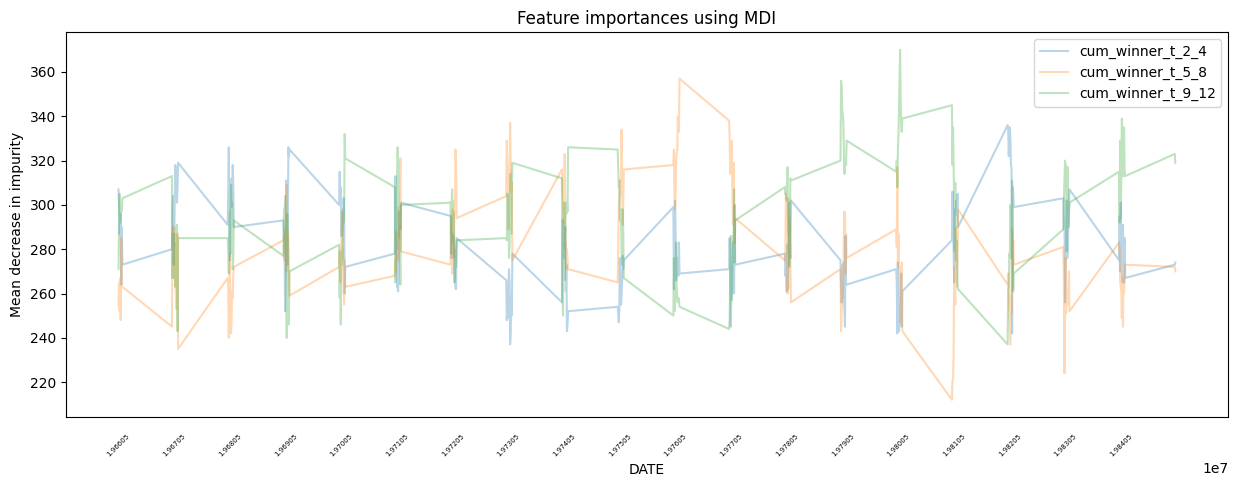

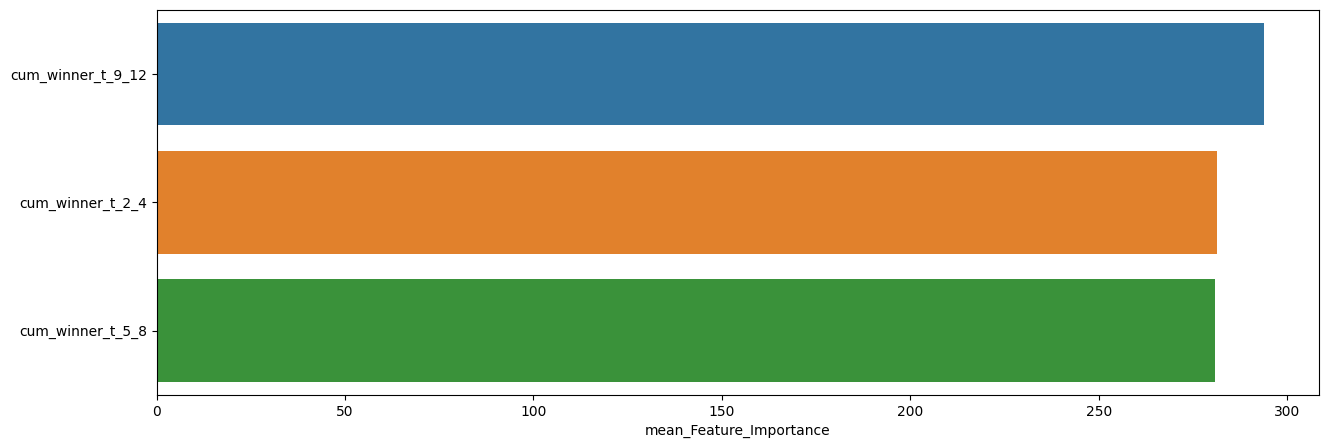

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12               293.796460                     370   
cum_winner_t_2_4                281.491150                     336   
cum_winner_t_5_8                280.756637                     357   

                   min_Feature_Importance  
cum_winner_t_9_12                     237  
cum_winner_t_2_4                      237  
cum_winner_t_5_8                      212


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.21      0.26        70
         1.0       0.70      0.81      0.75       156

    accuracy                           0.62       226
   macro avg       0.51      0.51      0.50       226
weighted avg       0.58      0.62      0.60       226


accuracy : 0.6238938053097345

precision : 0.6961325966850829

recall : 0.8076923076923077

F1-Score : 0.7477744807121661



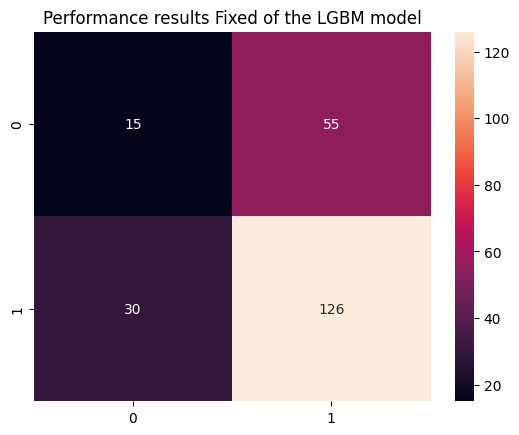


Feature Importance of the model



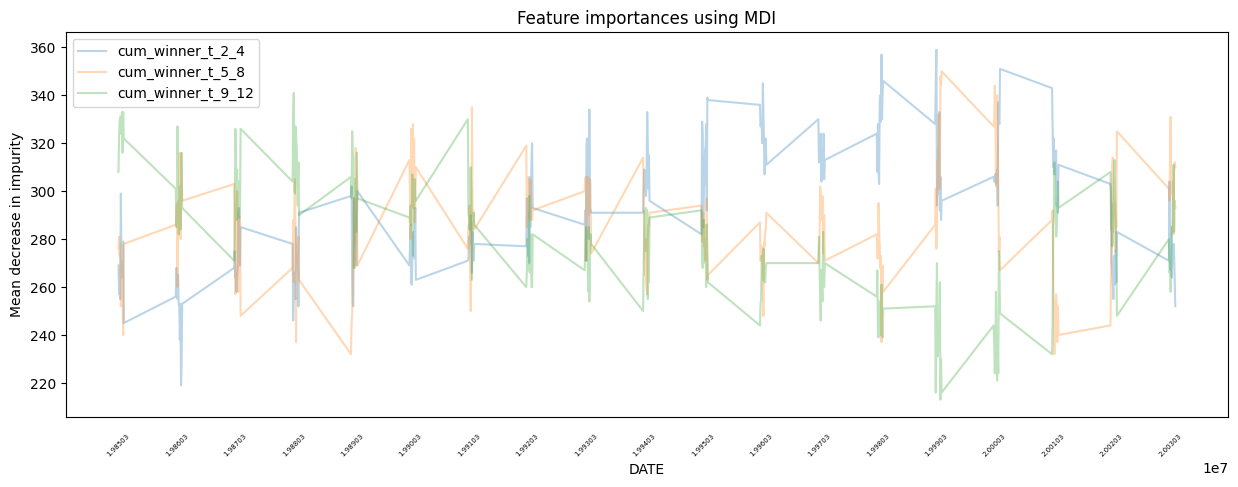

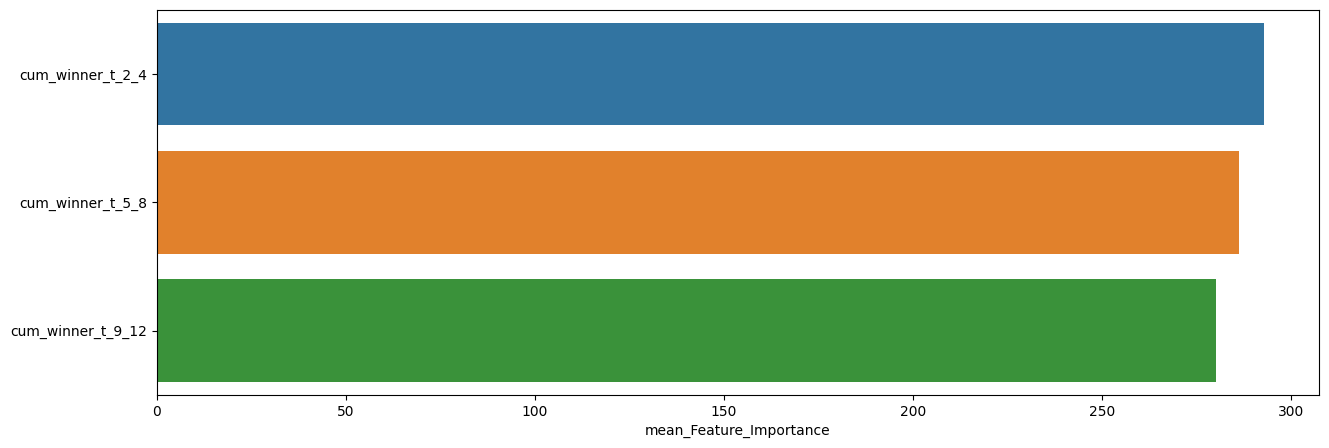

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_2_4                292.716814                     359   
cum_winner_t_5_8                286.181416                     350   
cum_winner_t_9_12               280.176991                     341   

                   min_Feature_Importance  
cum_winner_t_2_4                      219  
cum_winner_t_5_8                      232  
cum_winner_t_9_12                     213


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.43      0.27      0.33        96
         1.0       0.58      0.74      0.65       132

    accuracy                           0.54       228
   macro avg       0.51      0.51      0.49       228
weighted avg       0.52      0.54      0.52       228


accuracy : 0.543859649122807

precision : 0.5833333333333334

recall : 0.7424242424242424

F1-Score : 0.6533333333333334



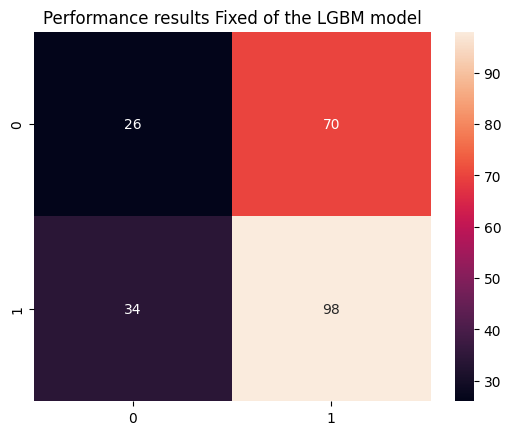


Feature Importance of the model



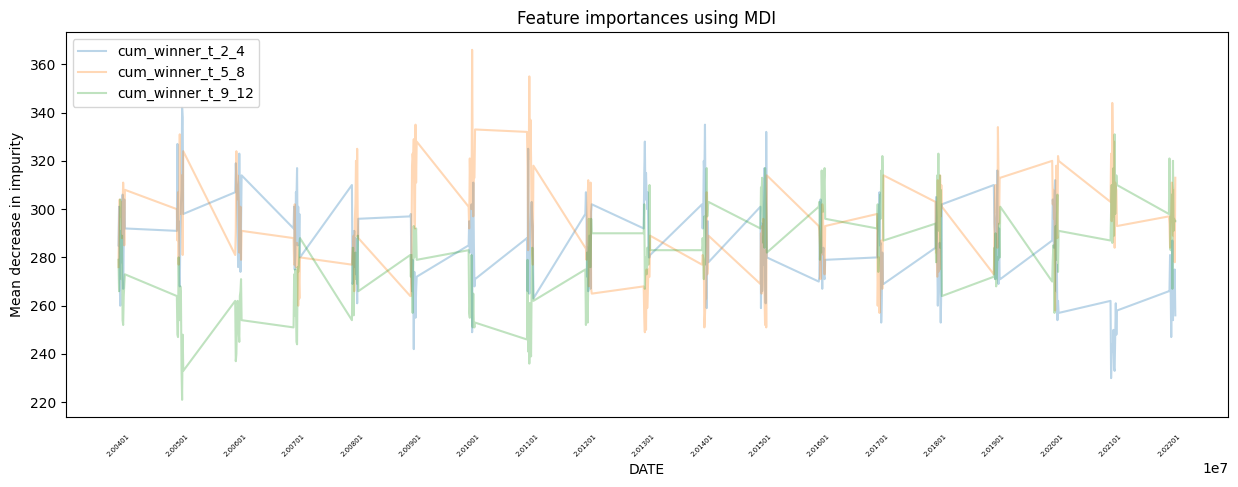

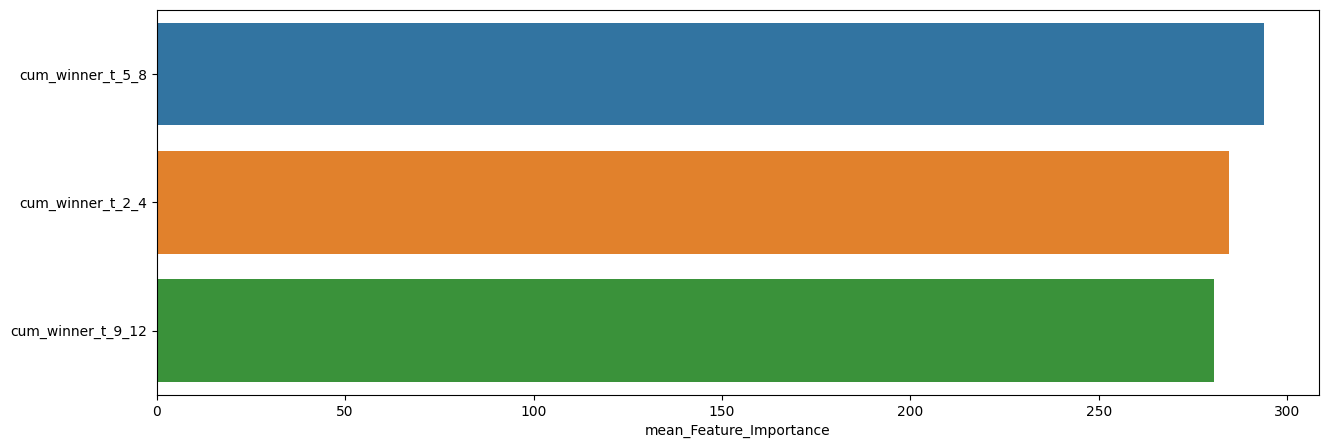

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                293.732456                     366   
cum_winner_t_2_4                284.600877                     342   
cum_winner_t_9_12               280.609649                     331   

                   min_Feature_Importance  
cum_winner_t_5_8                      249  
cum_winner_t_2_4                      230  
cum_winner_t_9_12                     221

In [109]:
slice_feature_importance(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                        4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                        'Fixed', # Rolling Windows Method
                        'LGBM') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



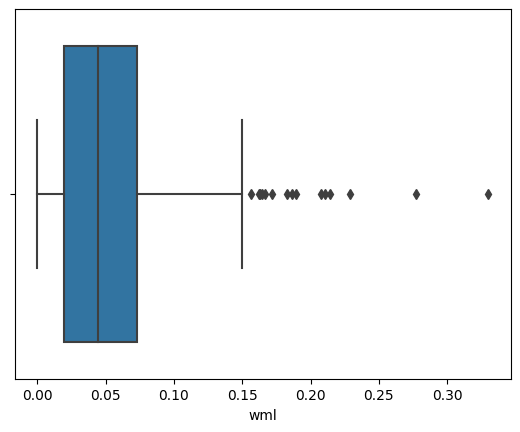

count      mean      std       min       25%       50%       75%  \
wml  454.0  0.053269  0.04529  0.000007  0.019464  0.044367  0.073142   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



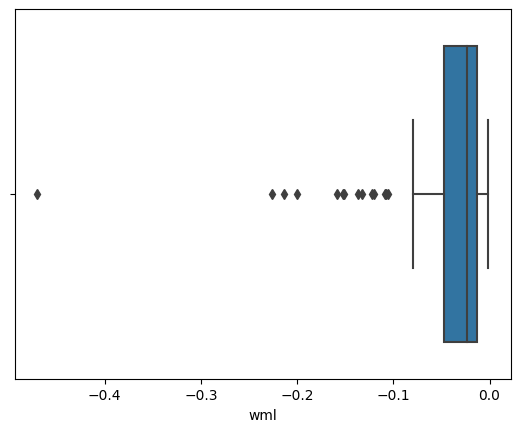

count      mean       std       min       25%       50%       75%  \
wml   82.0 -0.049457  0.069461 -0.469903 -0.047326 -0.023584 -0.013323   

         max  
wml -0.00129


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



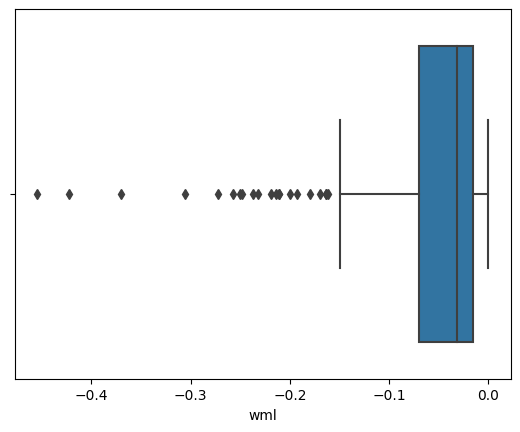

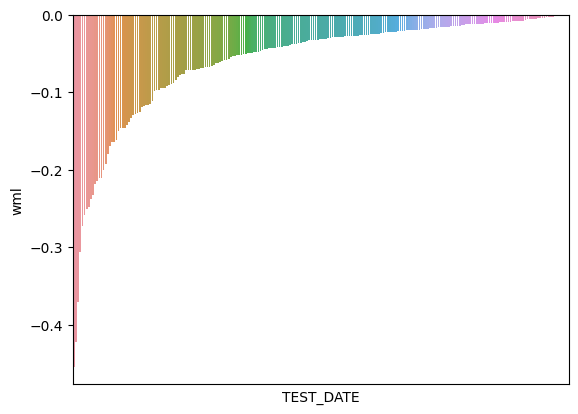

count      mean       std       min       25%       50%       75%  \
wml  234.0 -0.058713  0.071838 -0.454349 -0.069478 -0.031713 -0.015464   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



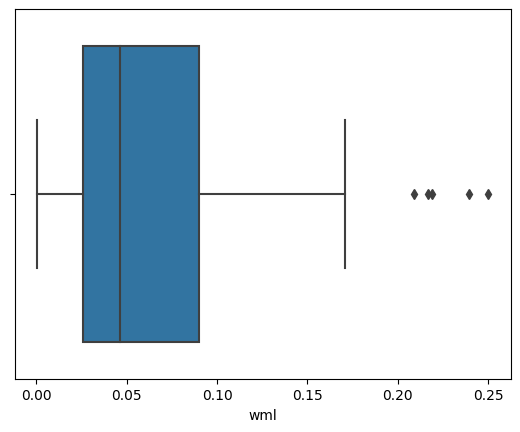

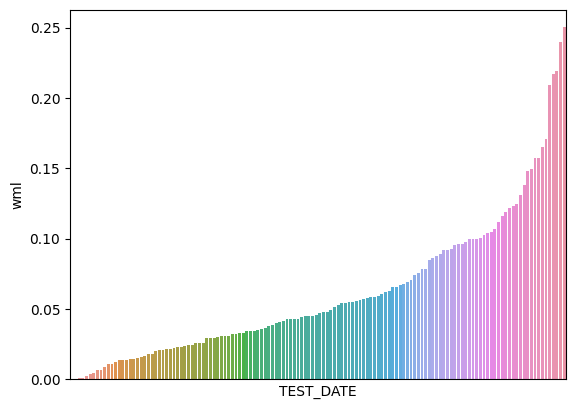

count      mean       std       min       25%       50%       75%  \
wml  136.0  0.061863  0.051188  0.000577  0.025555  0.046484  0.089867   

          max  
wml  0.250175

In [110]:
LGBM_A0_P1, LGBM_A1_P0 = What_Pred(Fixed_LGBM_Result,
                                   WML,
                                   'LGBM')

Sharpe Ratio : 0.64683

최근 누적 수익률

  2022년-12월 -> 3658.81
  2022년-11월 -> 3296.43
  2022년-10월 -> 3296.43
  2022년-09월 -> 2918.83
  2022년-08월 -> 2918.83

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 16807.94
  2등 : 2001년-09월 -> 16463.64
  3등 : 2008년-06월 -> 16422.63
  4등 : 2002년-07월 -> 14636.03
  5등 : 2008년-11월 -> 14546.62
  6등 : 2008년-10월 -> 14546.62
  7등 : 2002년-08월 -> 14211.99
  8등 : 2009년-02월 -> 14202.29
  9등 : 2008년-12월 -> 14202.29
  10등 : 2009년-01월 -> 14202.29



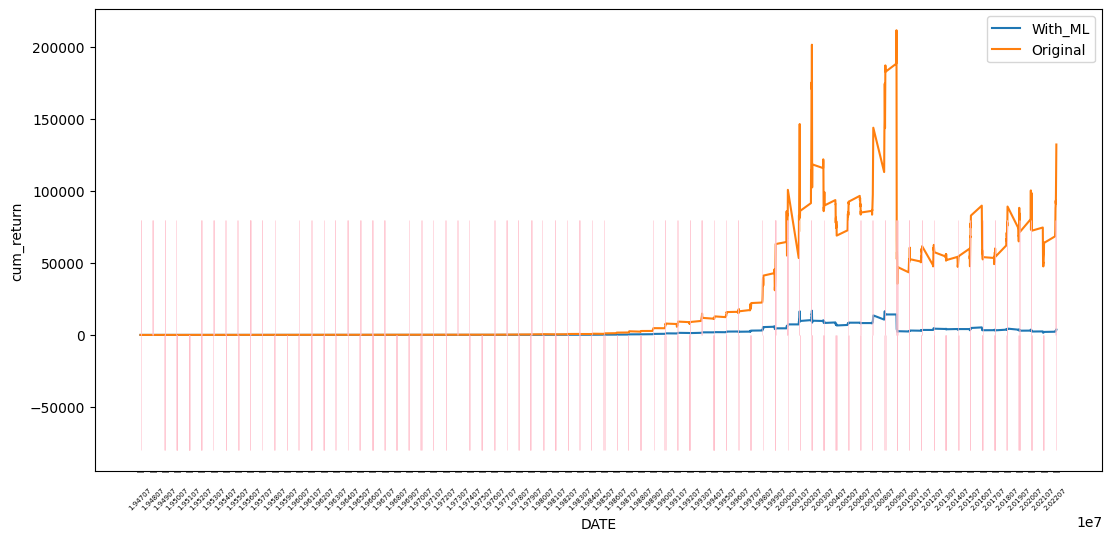

In [111]:
LGBM_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PRED_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

Sharpe Ratio : 0.74688

최근 누적 수익률

  2022년-12월 -> 3669.36
  2022년-11월 -> 3348.15
  2022년-10월 -> 3318.47
  2022년-09월 -> 3013.23
  2022년-08월 -> 2916.14

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 4888.03
  2등 : 2009년-02월 -> 4857.72
  3등 : 2009년-01월 -> 4620.06
  4등 : 2008년-11월 -> 4611.29
  5등 : 2008년-06월 -> 4568.46
  6등 : 2008년-12월 -> 4553.73
  7등 : 2008년-10월 -> 4466.81
  8등 : 2002년-07월 -> 4436.64
  9등 : 2002년-08월 -> 4325.07
  10등 : 2008년-09월 -> 4301.70



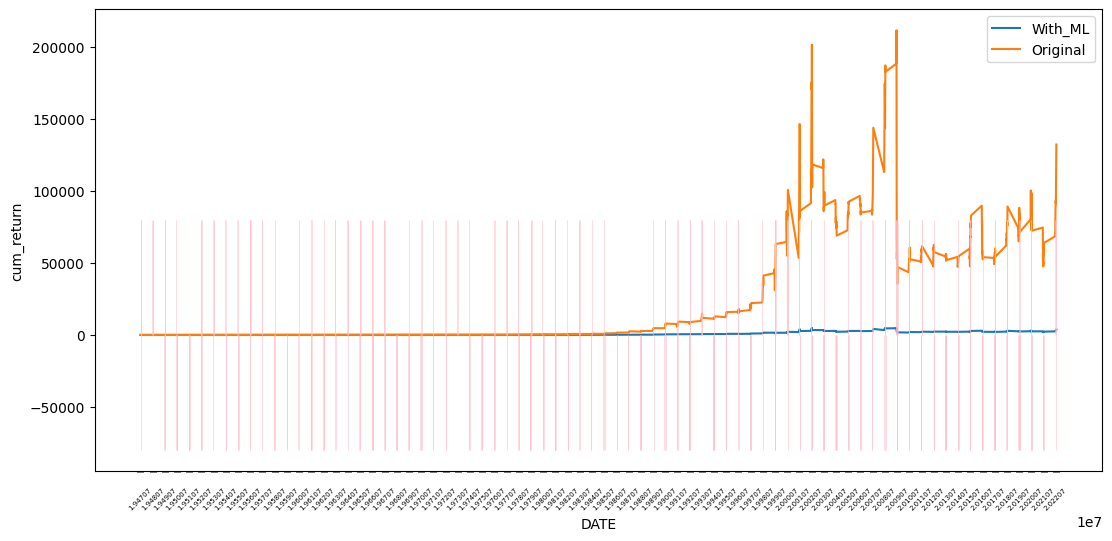

In [112]:
LGBM_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PROB_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

## Rolling Expanding Windows

### Random Forest

In [113]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

**************************************************

RDF Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.20      0.26       316
         1.0       0.66      0.82      0.73       590

    accuracy                           0.61       906
   macro avg       0.52      0.51      0.50       906
weighted avg       0.56      0.61      0.57       906


accuracy : 0.6059602649006622

precision : 0.6576454668470907

recall : 0.823728813559322

F1-Score : 0.7313769751693003



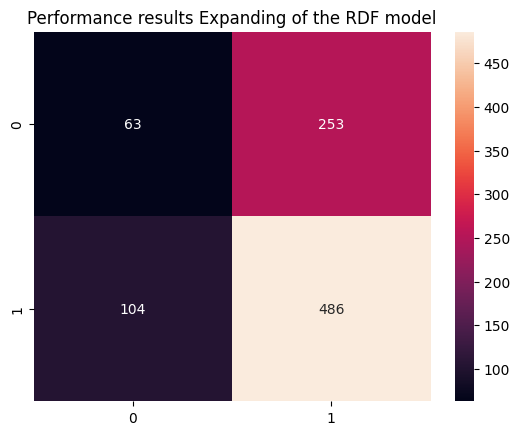


Feature Importance of the model



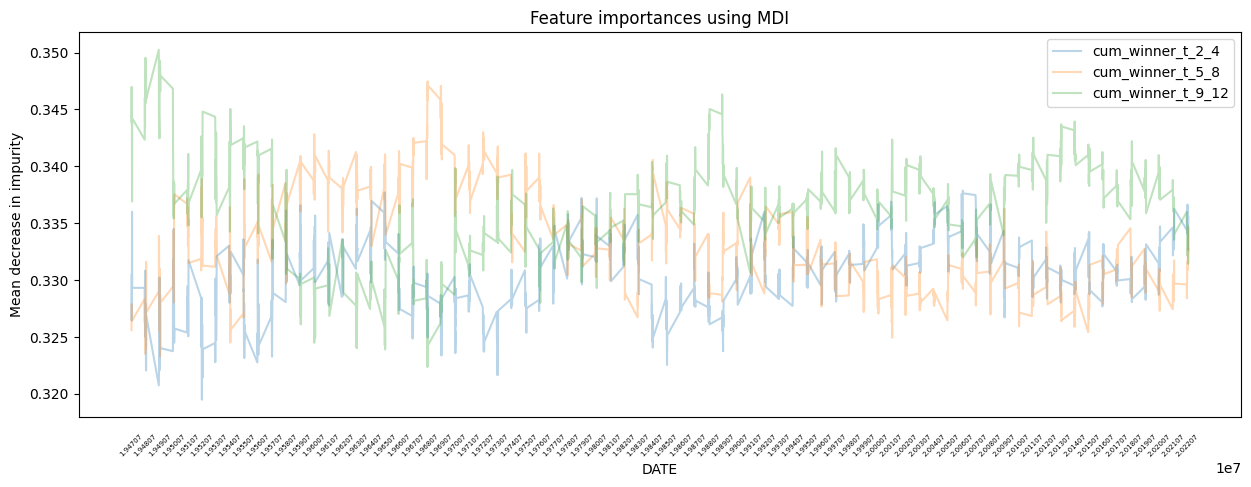

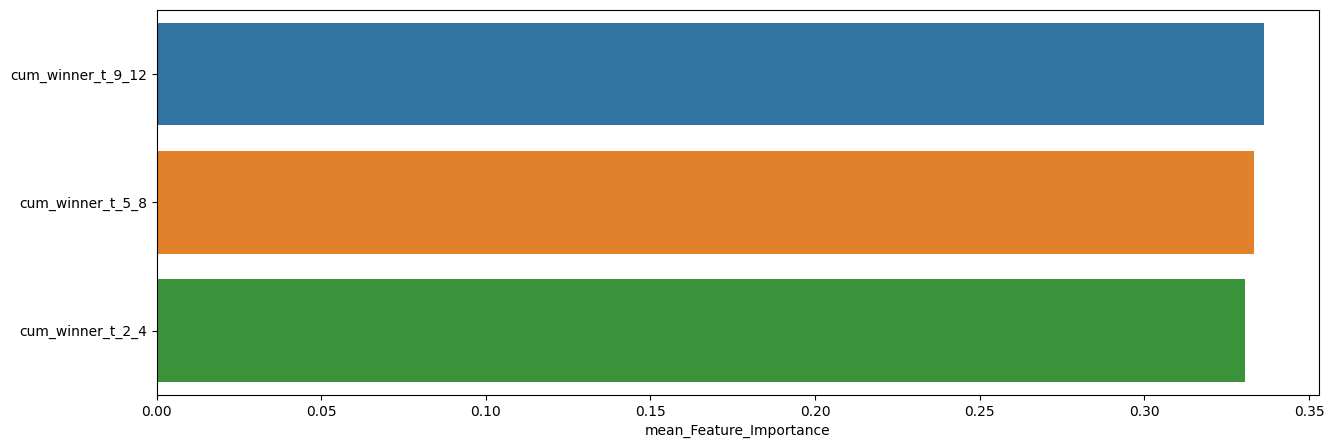

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12                 0.336252                0.350252   
cum_winner_t_5_8                  0.333332                0.347479   
cum_winner_t_2_4                  0.330416                0.337869   

                   min_Feature_Importance  
cum_winner_t_9_12                0.322351  
cum_winner_t_5_8                 0.323276  
cum_winner_t_2_4                 0.319480

In [114]:
Expanding_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                      window_size=240, # window size (훈련 데이터 셋 크기)
                                      method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                      model=RDF, # 사용할 모델
                                      model_name='RDF', # 사용한 모델 명
                                      plot=True, # 모델 성능 지표 시각화 여부
                                      plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.23      0.27        75
         1.0       0.67      0.78      0.72       151

    accuracy                           0.60       226
   macro avg       0.51      0.50      0.50       226
weighted avg       0.56      0.60      0.57       226


accuracy : 0.5973451327433629

precision : 0.6704545454545454

recall : 0.7814569536423841

F1-Score : 0.7217125382262998



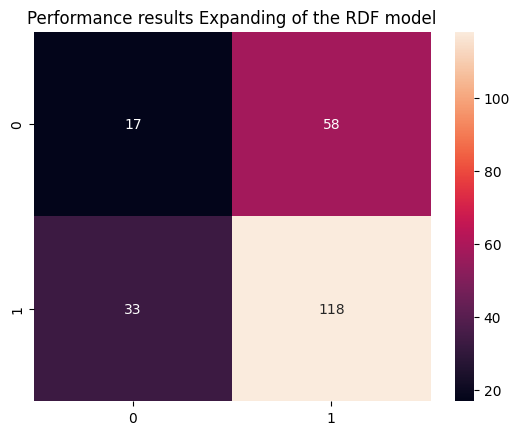


Feature Importance of the model



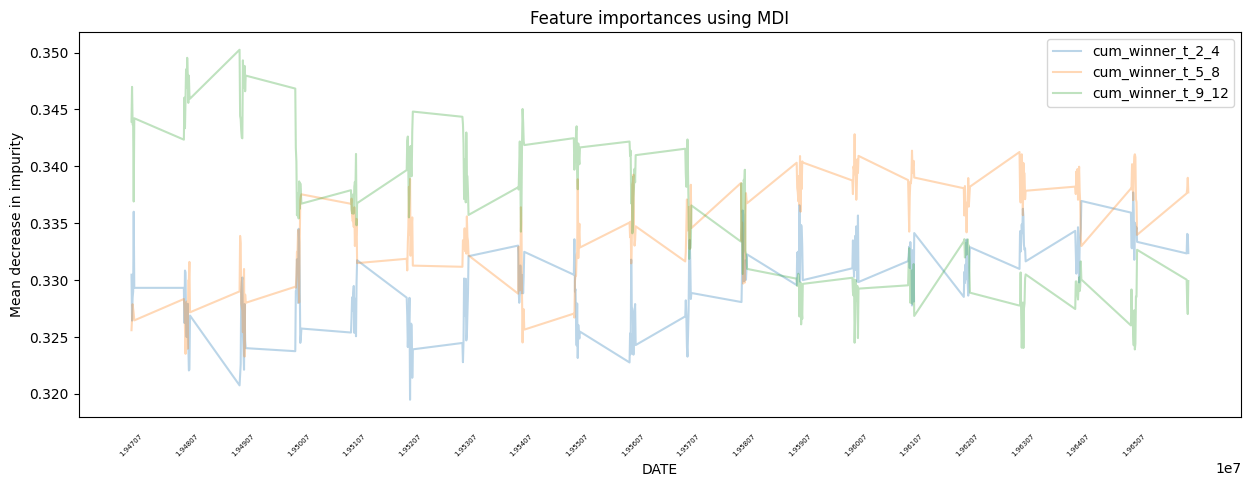

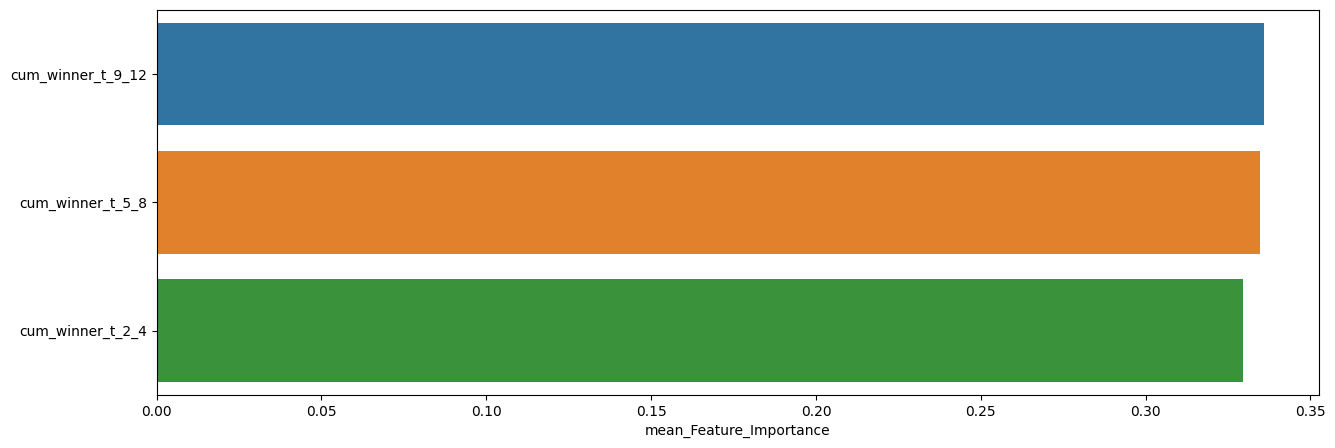

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12                 0.335829                0.350252   
cum_winner_t_5_8                  0.334582                0.342824   
cum_winner_t_2_4                  0.329589                0.337705   

                   min_Feature_Importance  
cum_winner_t_9_12                0.323901  
cum_winner_t_5_8                 0.323276  
cum_winner_t_2_4                 0.319480


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.29      0.19      0.23        75
         1.0       0.66      0.77      0.71       151

    accuracy                           0.58       226
   macro avg       0.47      0.48      0.47       226
weighted avg       0.54      0.58      0.55       226


accuracy : 0.5796460176991151

precision : 0.6573033707865169

recall : 0.7748344370860927

F1-Score : 0.7112462006079027



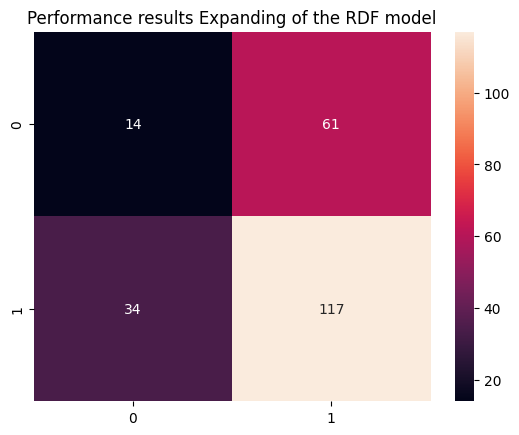


Feature Importance of the model



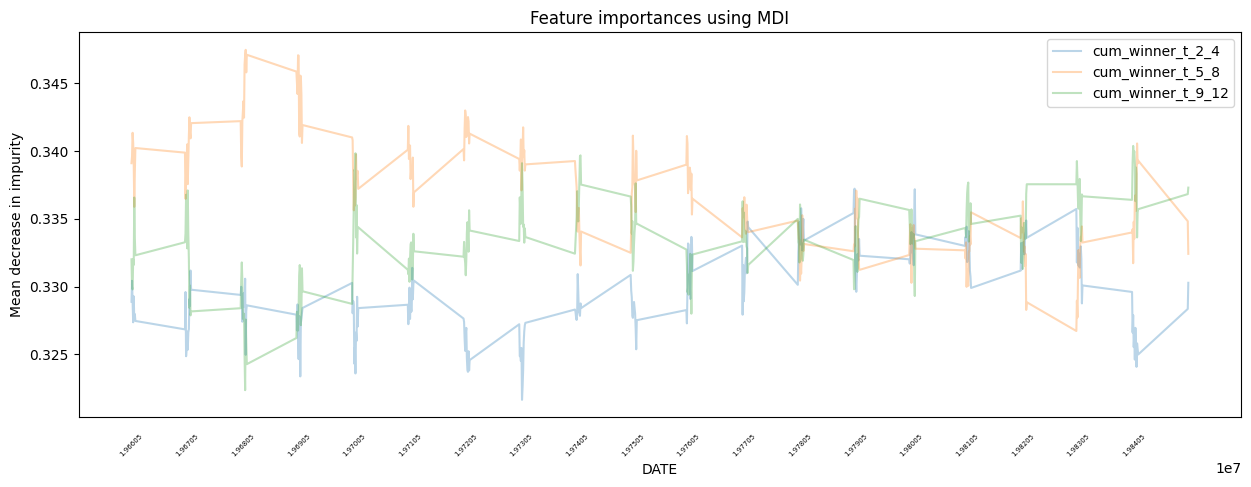

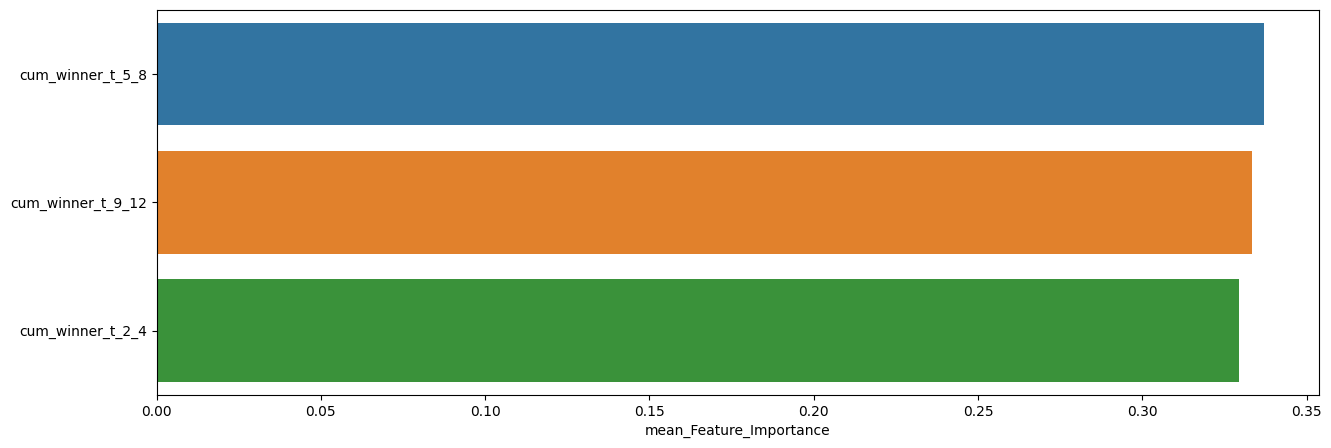

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                  0.336976                0.347479   
cum_winner_t_9_12                 0.333461                0.340384   
cum_winner_t_2_4                  0.329563                0.337226   

                   min_Feature_Importance  
cum_winner_t_5_8                 0.326720  
cum_winner_t_9_12                0.322351  
cum_winner_t_2_4                 0.321638


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.17      0.24        70
         1.0       0.70      0.87      0.78       156

    accuracy                           0.65       226
   macro avg       0.54      0.52      0.51       226
weighted avg       0.60      0.65      0.61       226


accuracy : 0.6548672566371682

precision : 0.7010309278350515

recall : 0.8717948717948718

F1-Score : 0.7771428571428571



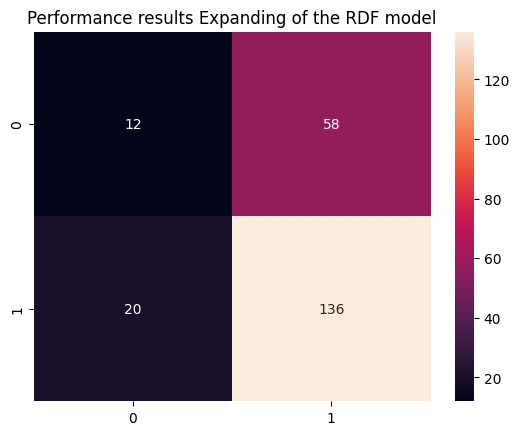


Feature Importance of the model



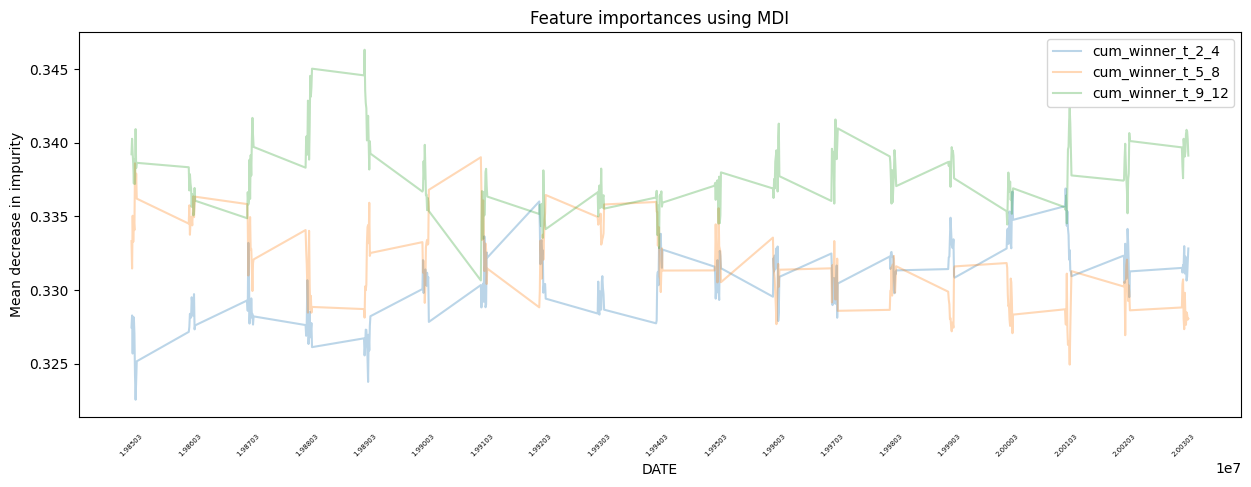

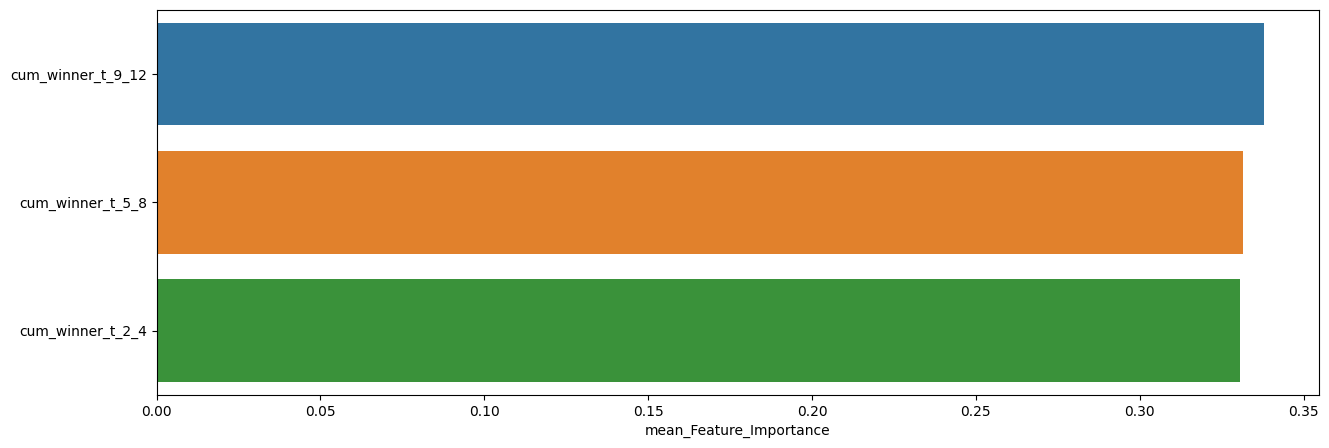

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12                 0.337866                0.346327   
cum_winner_t_5_8                  0.331601                0.339021   
cum_winner_t_2_4                  0.330533                0.336897   

                   min_Feature_Importance  
cum_winner_t_9_12                0.330646  
cum_winner_t_5_8                 0.324927  
cum_winner_t_2_4                 0.322539


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.54      0.21      0.30        96
         1.0       0.60      0.87      0.71       132

    accuracy                           0.59       228
   macro avg       0.57      0.54      0.51       228
weighted avg       0.58      0.59      0.54       228


accuracy : 0.5921052631578947

precision : 0.6020942408376964

recall : 0.8712121212121212

F1-Score : 0.7120743034055728



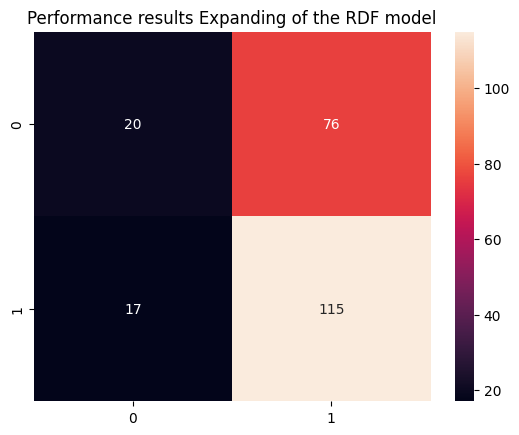


Feature Importance of the model



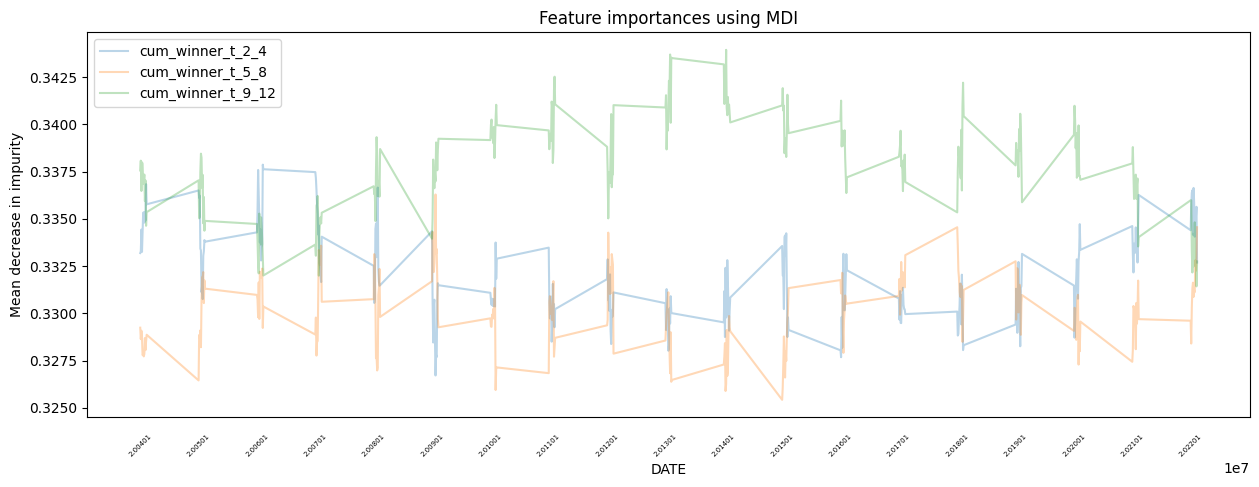

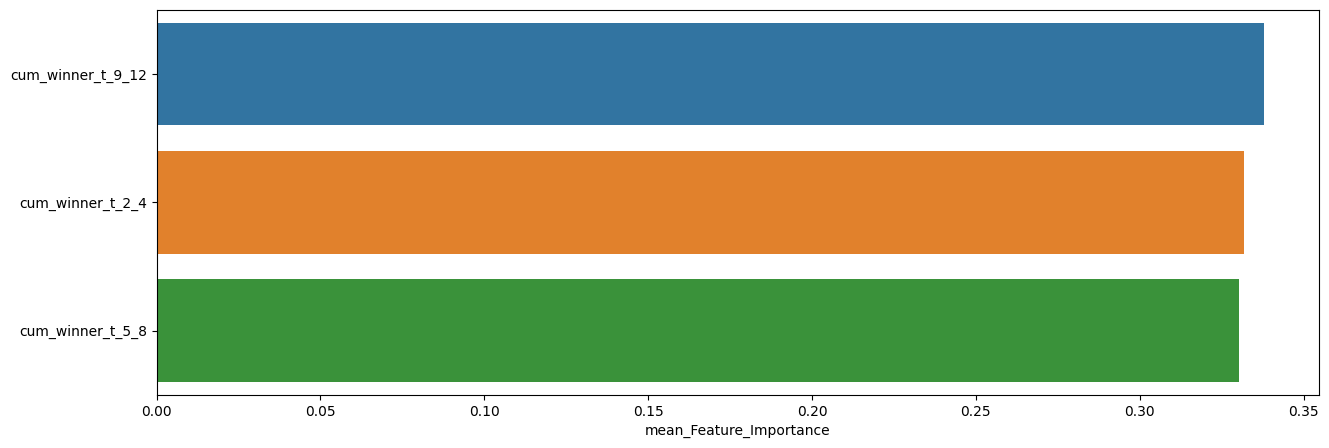

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12                 0.337837                0.343945   
cum_winner_t_2_4                  0.331965                0.337869   
cum_winner_t_5_8                  0.330198                0.336293   

                   min_Feature_Importance  
cum_winner_t_9_12                0.331431  
cum_winner_t_2_4                 0.326717  
cum_winner_t_5_8                 0.325428

In [115]:
slice_feature_importance(Expanding_RDF_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'RDF') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



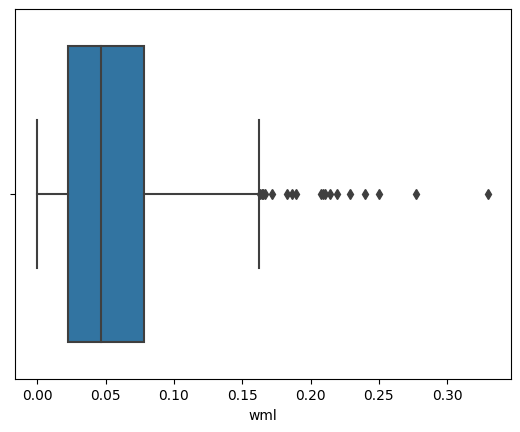

count      mean       std       min       25%       50%       75%  \
wml  486.0  0.056432  0.047445  0.000007  0.022088  0.046719  0.078348   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



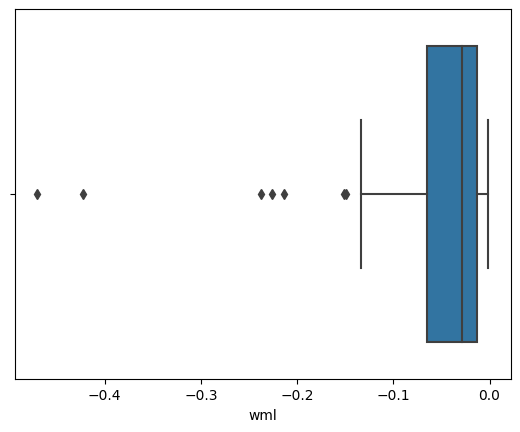

count      mean       std       min       25%       50%     75%      max
wml   63.0 -0.059944  0.088552 -0.469903 -0.065143 -0.028359 -0.0127 -0.00129


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



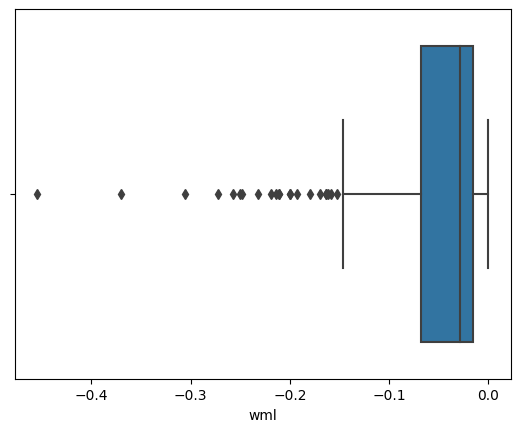

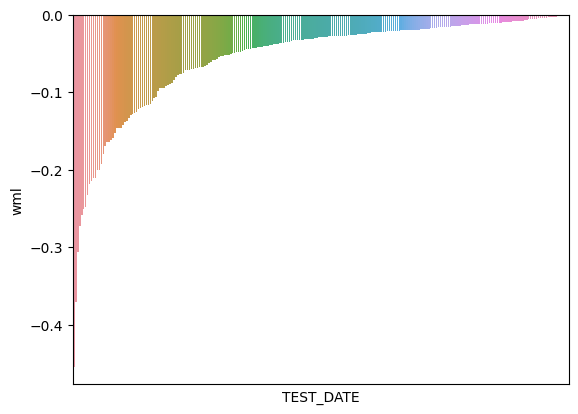

count      mean       std       min      25%       50%       75%  \
wml  253.0 -0.055406  0.066406 -0.454349 -0.06833 -0.028629 -0.015898   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



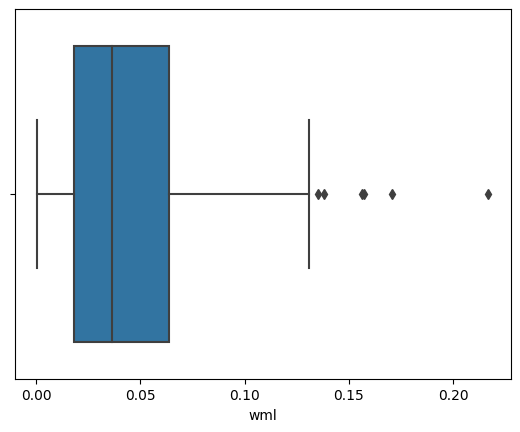

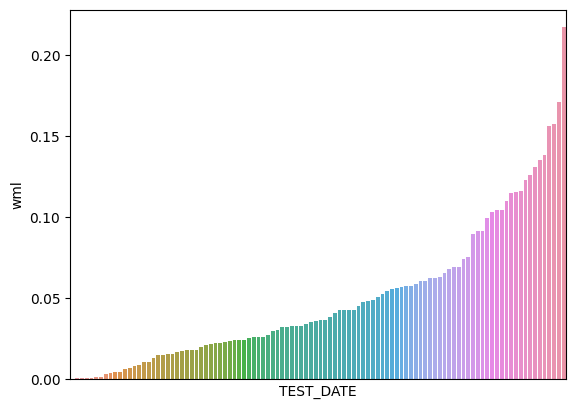

count      mean       std       min       25%      50%       75%  \
wml  104.0  0.049724  0.043516  0.000577  0.018333  0.03618  0.063696   

          max  
wml  0.216883

In [116]:
RDF_A0_P1, RDF_A1_P0 = What_Pred(Expanding_RDF_Result, WML, 'RDF')

Sharpe Ratio : 0.61262

최근 누적 수익률

  2022년-12월 -> 64493.32
  2022년-11월 -> 64493.32
  2022년-10월 -> 61346.72
  2022년-09월 -> 54321.62
  2022년-08월 -> 49386.35

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 64493.32
  2등 : 2022년-11월 -> 64493.32
  3등 : 2022년-10월 -> 61346.72
  4등 : 2020년-03월 -> 56325.57
  5등 : 2022년-09월 -> 54321.62
  6등 : 2022년-07월 -> 50489.86
  7등 : 2022년-08월 -> 49386.35
  8등 : 2020년-09월 -> 48933.95
  9등 : 2020년-10월 -> 48765.34
  10등 : 2020년-07월 -> 48497.47



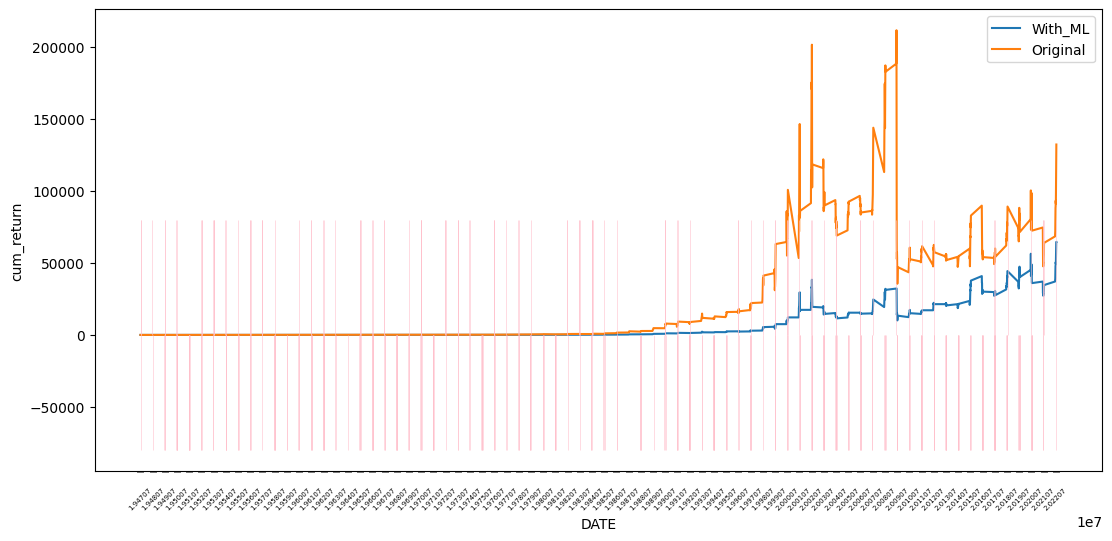

In [117]:
RDF_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_RDF_Result,
                                                 WML,
                                                 'RDF_PRED_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.70920

최근 누적 수익률

  2022년-12월 -> 8841.76
  2022년-11월 -> 8586.93
  2022년-10월 -> 8272.89
  2022년-09월 -> 7470.88
  2022년-08월 -> 7068.22

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 8841.76
  2등 : 2022년-11월 -> 8586.93
  3등 : 2022년-10월 -> 8272.89
  4등 : 2022년-09월 -> 7470.88
  5등 : 2022년-07월 -> 7197.22
  6등 : 2022년-08월 -> 7068.22
  7등 : 2022년-06월 -> 6992.40
  8등 : 2022년-05월 -> 6929.30
  9등 : 2022년-04월 -> 6694.66
  10등 : 2009년-02월 -> 6392.90



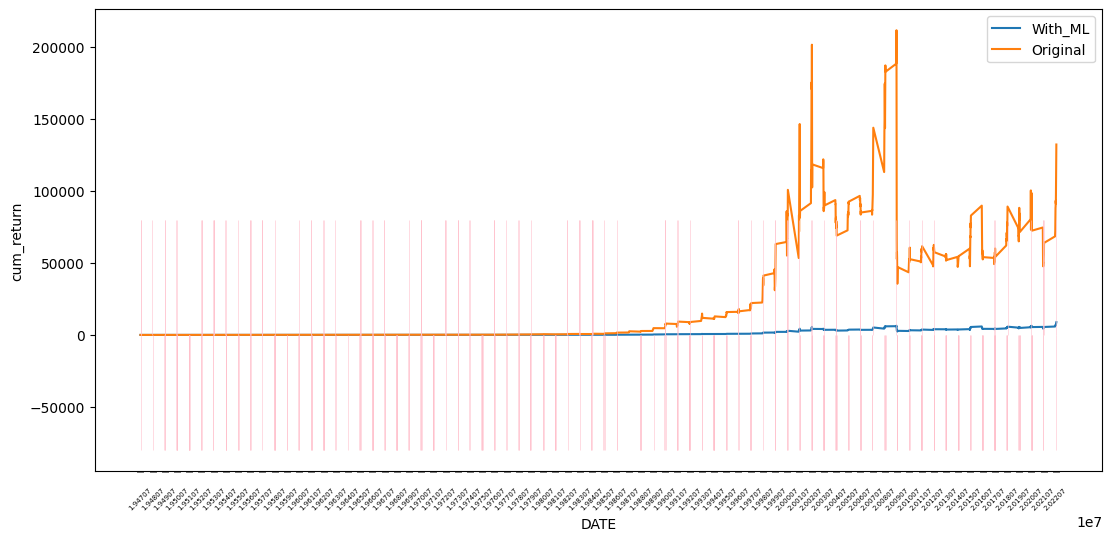

In [118]:
RDF_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_RDF_Result,
                                                 WML,
                                                 'RDF_PROB_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

### Grdient Boosting

In [119]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

**************************************************

GBC Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.13      0.18       316
         1.0       0.65      0.86      0.74       590

    accuracy                           0.60       906
   macro avg       0.49      0.49      0.46       906
weighted avg       0.54      0.60      0.55       906


accuracy : 0.6048565121412803

precision : 0.6479591836734694

recall : 0.8610169491525423

F1-Score : 0.7394468704512374



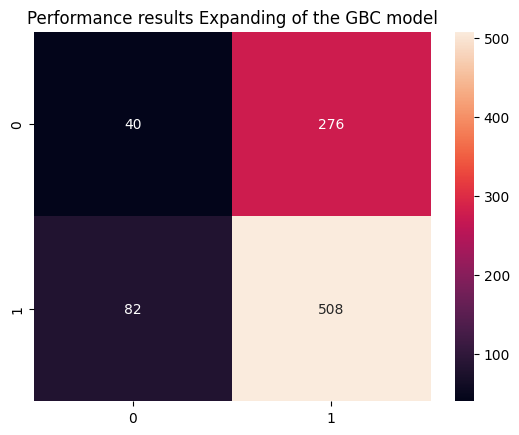


Feature Importance of the model



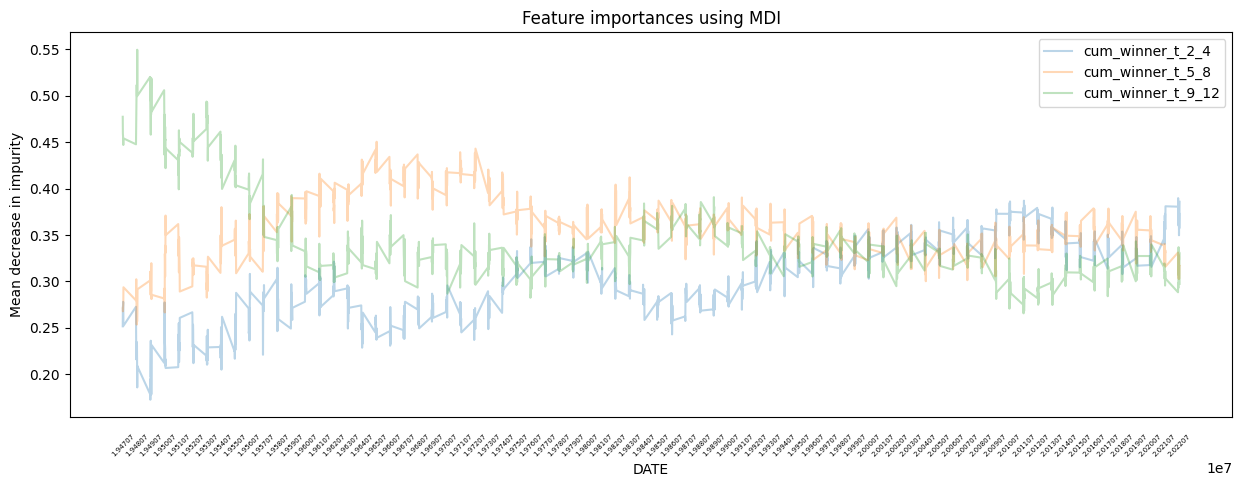

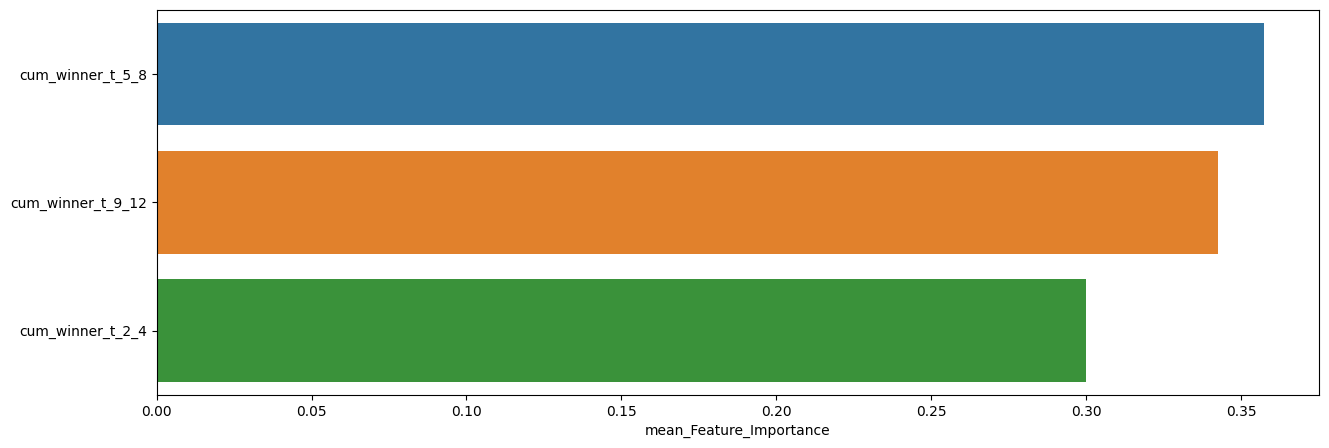

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                  0.357348                0.450545   
cum_winner_t_9_12                 0.342698                0.549737   
cum_winner_t_2_4                  0.299954                0.389760   

                   min_Feature_Importance  
cum_winner_t_5_8                 0.253453  
cum_winner_t_9_12                0.265596  
cum_winner_t_2_4                 0.172435

In [120]:
Expanding_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                      window_size=240, # window size (훈련 데이터 셋 크기)
                                      method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                      model=GBC, # 사용할 모델
                                      model_name='GBC', # 사용한 모델 명
                                      plot=True, # 모델 성능 지표 시각화 여부
                                      plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.20      0.25        75
         1.0       0.67      0.79      0.73       151

    accuracy                           0.60       226
   macro avg       0.50      0.50      0.49       226
weighted avg       0.55      0.60      0.57       226


accuracy : 0.5973451327433629

precision : 0.6666666666666666

recall : 0.7947019867549668

F1-Score : 0.7250755287009063



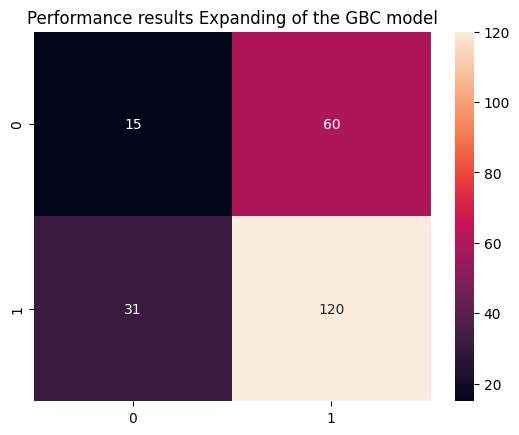


Feature Importance of the model



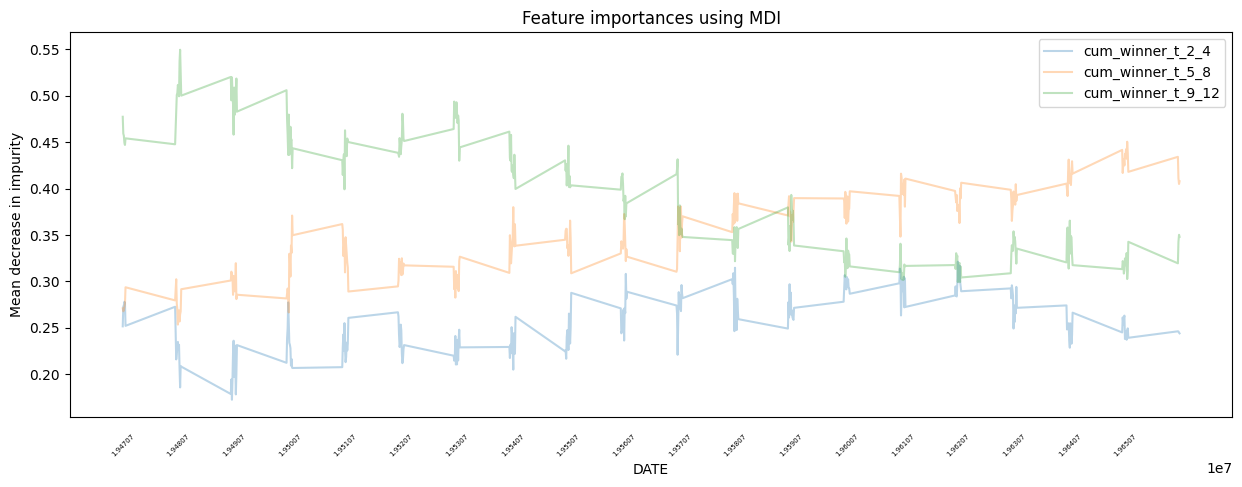

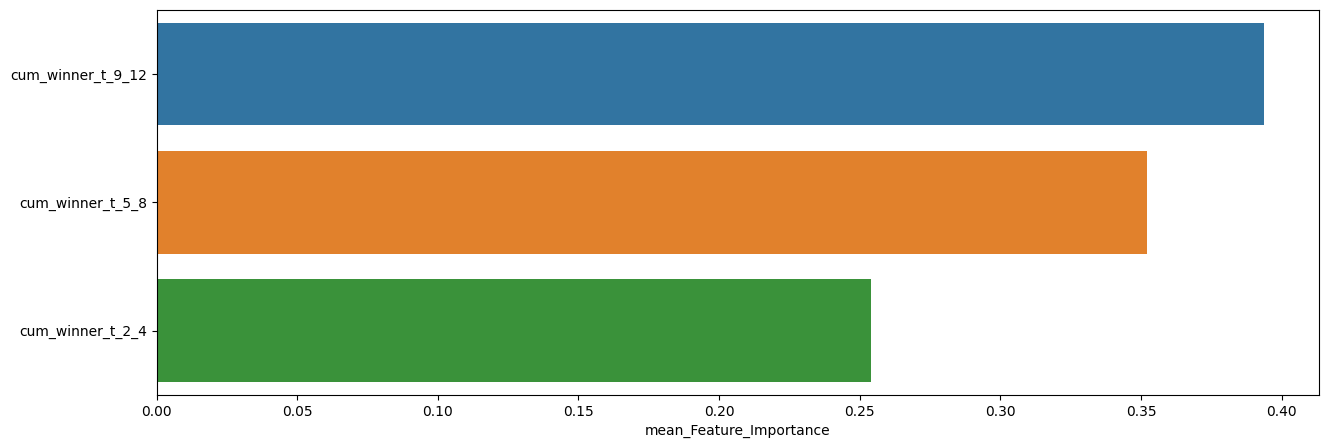

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12                 0.393638                0.549737   
cum_winner_t_5_8                  0.352242                0.450545   
cum_winner_t_2_4                  0.254120                0.321264   

                   min_Feature_Importance  
cum_winner_t_9_12                0.299331  
cum_winner_t_5_8                 0.253453  
cum_winner_t_2_4                 0.172435


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.17      0.23        75
         1.0       0.67      0.82      0.74       151

    accuracy                           0.61       226
   macro avg       0.50      0.50      0.48       226
weighted avg       0.55      0.61      0.57       226


accuracy : 0.6061946902654868

precision : 0.6666666666666666

recall : 0.8211920529801324

F1-Score : 0.7359050445103856



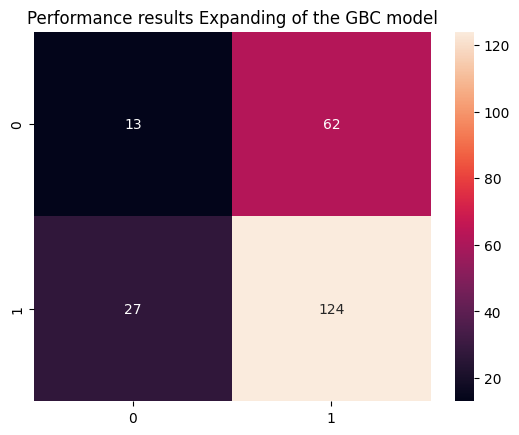


Feature Importance of the model



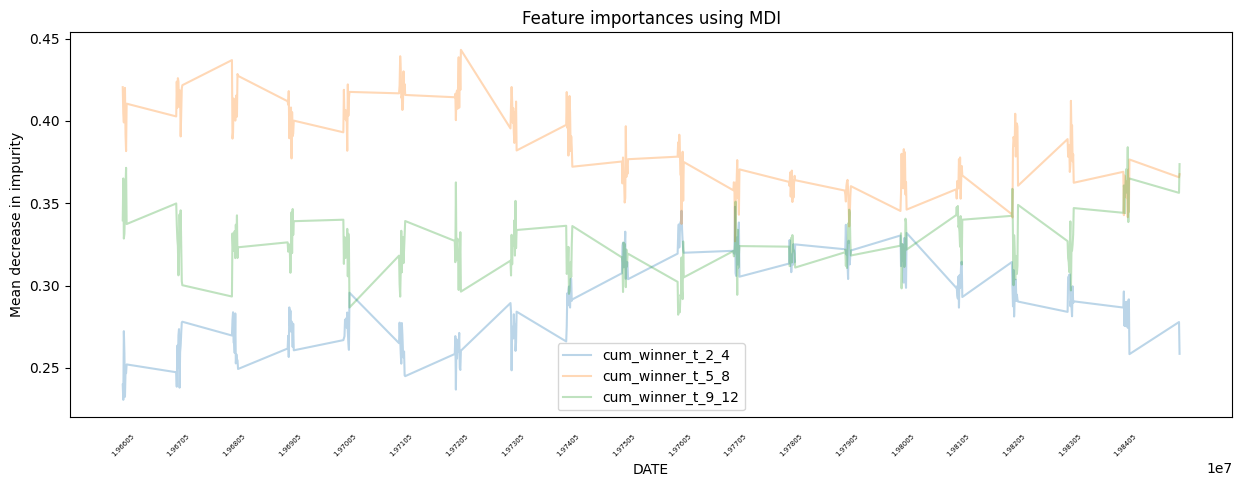

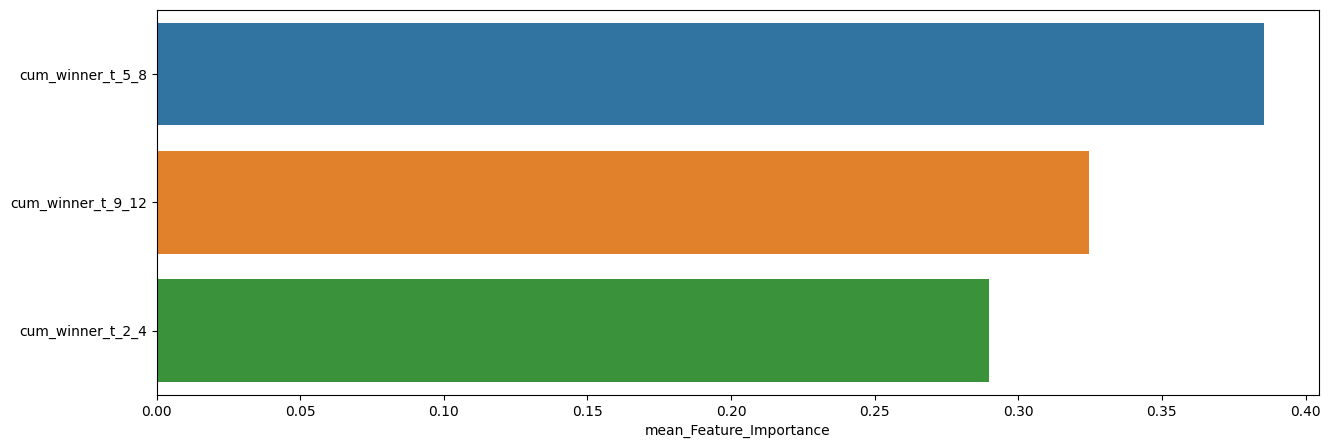

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                  0.385448                0.443135   
cum_winner_t_9_12                 0.324607                0.384032   
cum_winner_t_2_4                  0.289944                0.347847   

                   min_Feature_Importance  
cum_winner_t_5_8                 0.326930  
cum_winner_t_9_12                0.282346  
cum_winner_t_2_4                 0.230676


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.10      0.15        70
         1.0       0.69      0.90      0.78       156

    accuracy                           0.65       226
   macro avg       0.50      0.50      0.47       226
weighted avg       0.57      0.65      0.58       226


accuracy : 0.6504424778761062

precision : 0.6896551724137931

recall : 0.8974358974358975

F1-Score : 0.7799442896935934



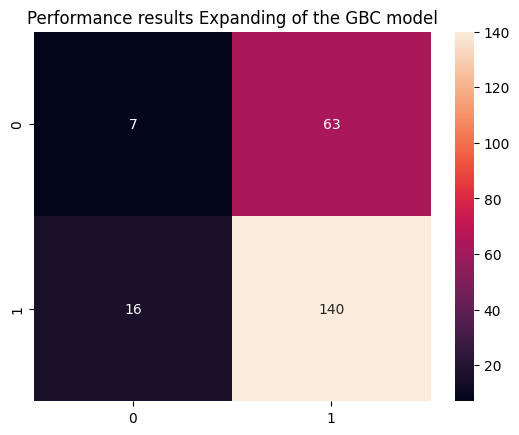


Feature Importance of the model



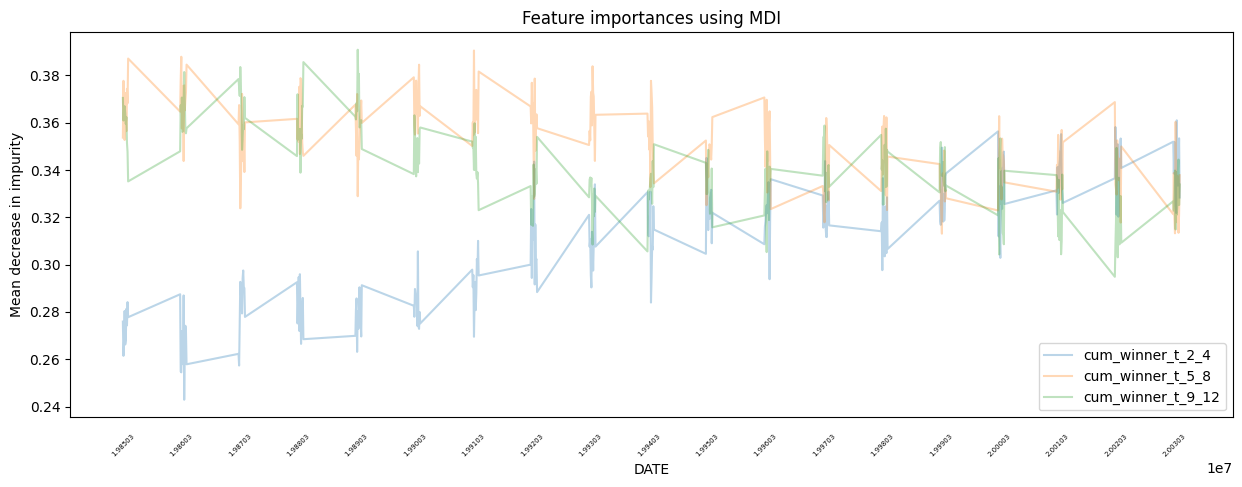

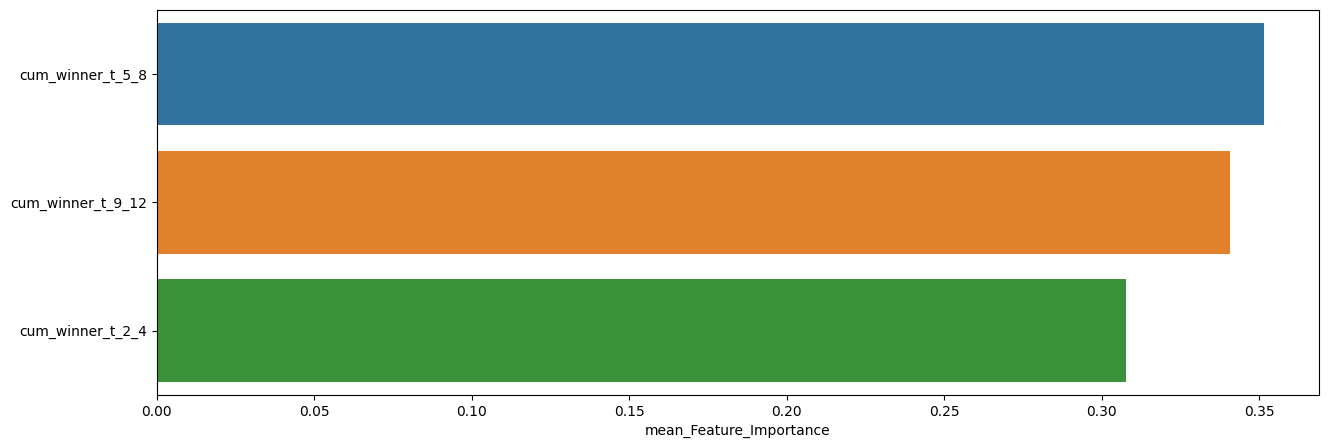

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                  0.351419                0.390478   
cum_winner_t_9_12                 0.340744                0.390811   
cum_winner_t_2_4                  0.307837                0.360986   

                   min_Feature_Importance  
cum_winner_t_5_8                 0.313063  
cum_winner_t_9_12                0.294839  
cum_winner_t_2_4                 0.242871


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.05      0.09        96
         1.0       0.58      0.94      0.71       132

    accuracy                           0.57       228
   macro avg       0.48      0.50      0.40       228
weighted avg       0.50      0.57      0.45       228


accuracy : 0.5657894736842105

precision : 0.5767441860465117

recall : 0.9393939393939394

F1-Score : 0.7146974063400577



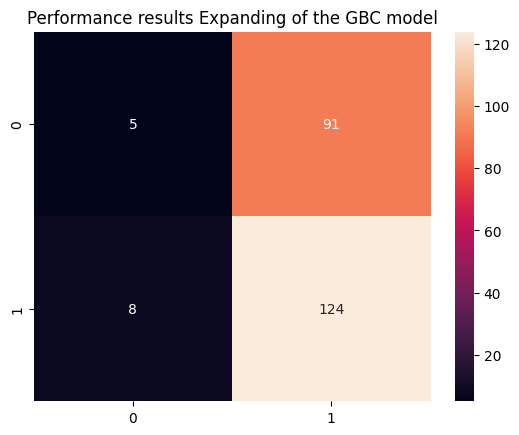


Feature Importance of the model



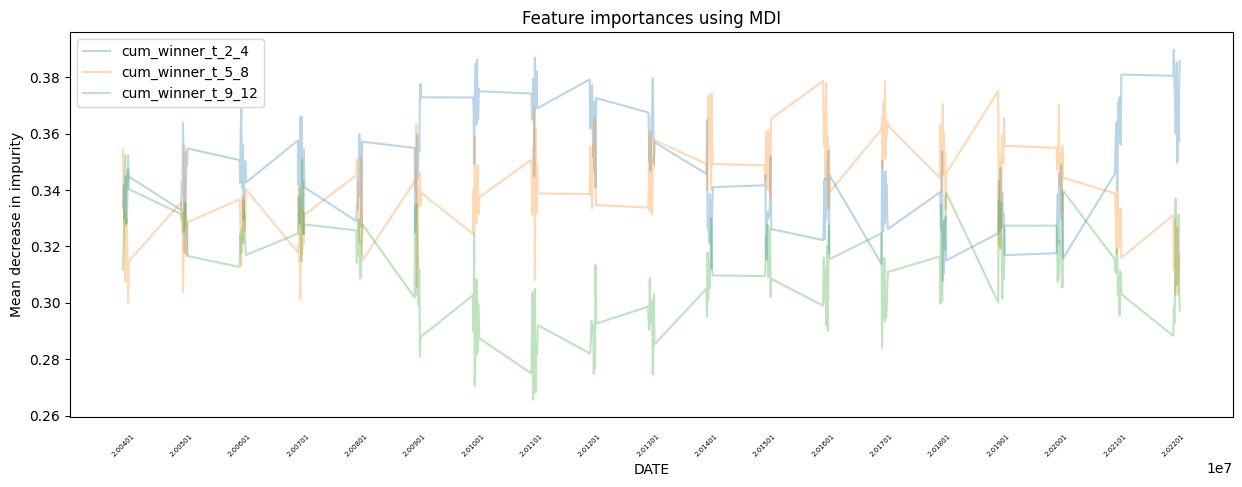

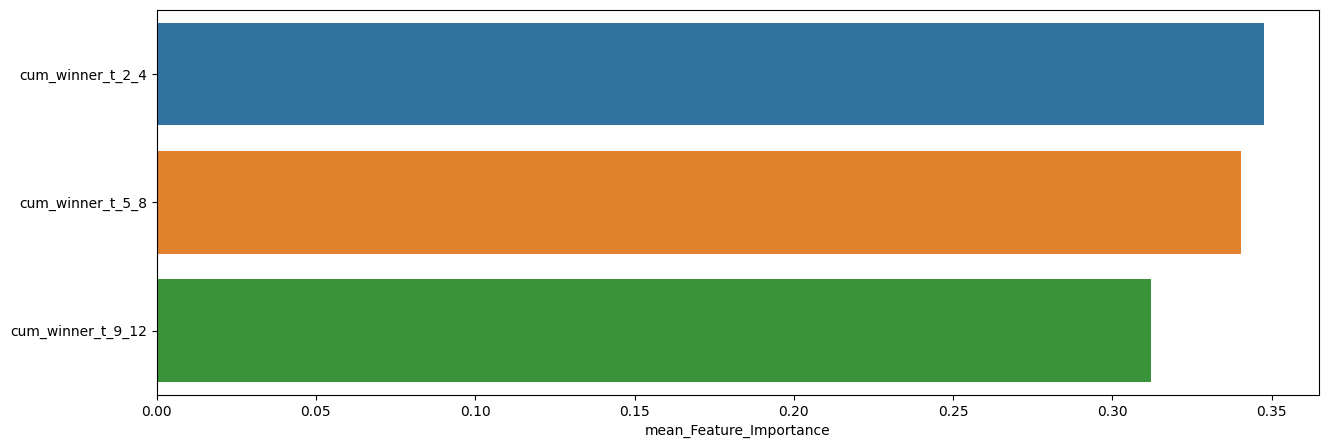

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_2_4                  0.347493                0.389760   
cum_winner_t_5_8                  0.340432                0.378725   
cum_winner_t_9_12                 0.312075                0.352358   

                   min_Feature_Importance  
cum_winner_t_2_4                 0.307840  
cum_winner_t_5_8                 0.300207  
cum_winner_t_9_12                0.265596

In [121]:
slice_feature_importance(Expanding_GBC_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'GBC') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



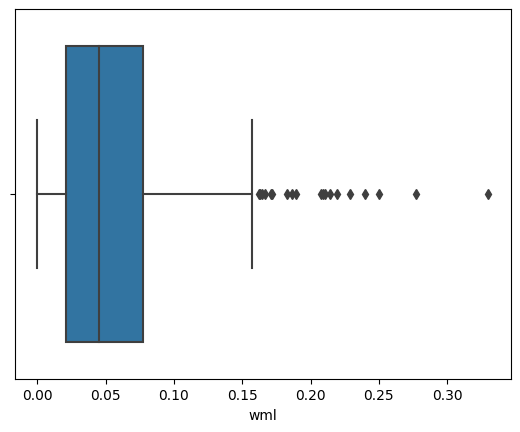

count     mean       std       min       25%      50%       75%       max
wml  508.0  0.05574  0.047157  0.000007  0.021166  0.04546  0.077301  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



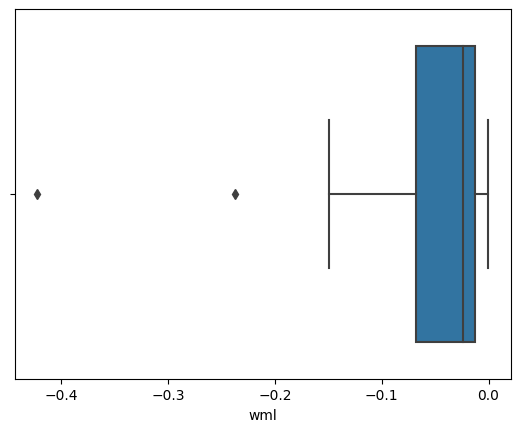

count      mean       std     min       25%       50%       75%       max
wml   40.0 -0.053547  0.078263 -0.4224 -0.067531 -0.023934 -0.012479 -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



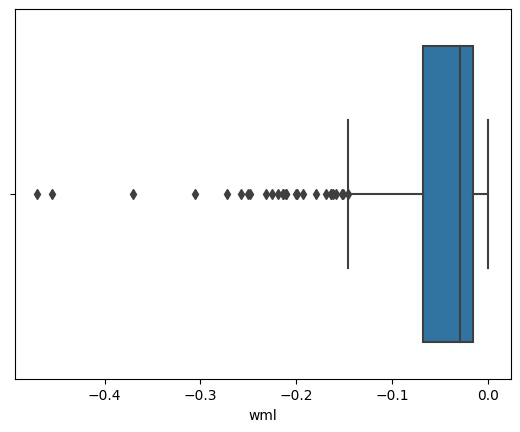

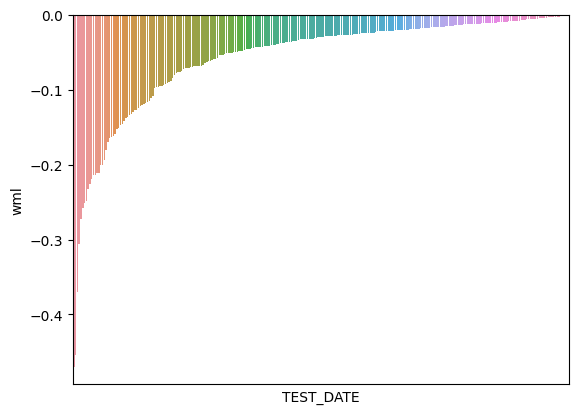

count      mean       std       min       25%     50%       75%       max
wml  276.0 -0.056712  0.070304 -0.469903 -0.067966 -0.0296 -0.015662 -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



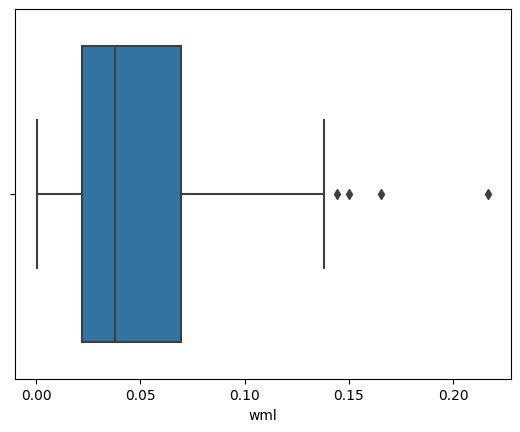

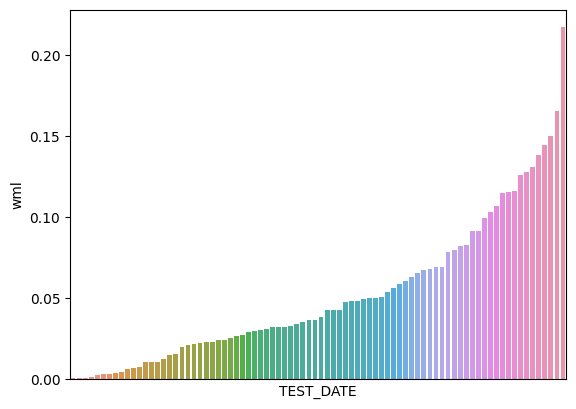

count      mean       std       min       25%       50%       75%  \
wml   82.0  0.052212  0.044768  0.000627  0.022127  0.037653  0.069293   

          max  
wml  0.216883

In [122]:
GBC_A0_P1, GBC_A1_P0 = What_Pred(Expanding_GBC_Result, WML, 'GBC')

Sharpe Ratio : 0.72083

최근 누적 수익률

  2022년-12월 -> 23272.25
  2022년-11월 -> 20967.79
  2022년-10월 -> 19944.74
  2022년-09월 -> 17660.70
  2022년-08월 -> 16056.12

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 23272.25
  2등 : 2022년-11월 -> 20967.79
  3등 : 2022년-10월 -> 19944.74
  4등 : 2002년-09월 -> 19853.44
  5등 : 2009년-02월 -> 19396.79
  6등 : 2009년-03월 -> 19396.79
  7등 : 2020년-03월 -> 18366.00
  8등 : 2022년-09월 -> 17660.70
  9등 : 2002년-07월 -> 17288.02
  10등 : 2009년-01월 -> 17271.44



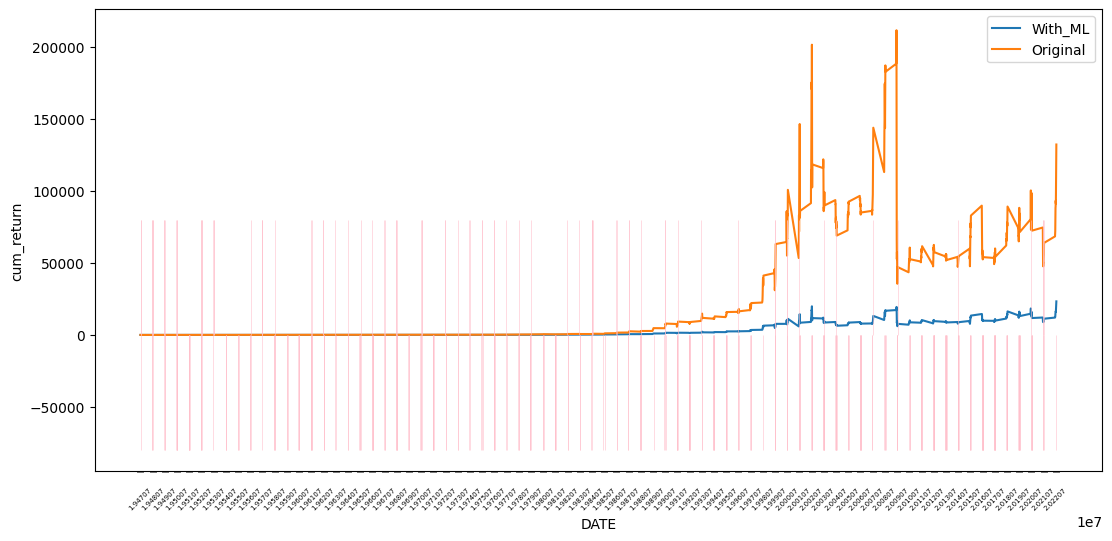

In [123]:
GBC_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_GBC_Result,
                                                 WML,
                                                 'GBC_PRED_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.75609

최근 누적 수익률

  2022년-12월 -> 5037.27
  2022년-11월 -> 4759.87
  2022년-10월 -> 4628.35
  2022년-09월 -> 4240.27
  2022년-08월 -> 3985.12

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 5037.27
  2등 : 2009년-02월 -> 4950.90
  3등 : 2022년-11월 -> 4759.87
  4등 : 2002년-09월 -> 4643.84
  5등 : 2022년-10월 -> 4628.35
  6등 : 2008년-11월 -> 4606.02
  7등 : 2009년-01월 -> 4600.37
  8등 : 2008년-12월 -> 4529.67
  9등 : 2008년-06월 -> 4346.83
  10등 : 2008년-10월 -> 4306.63



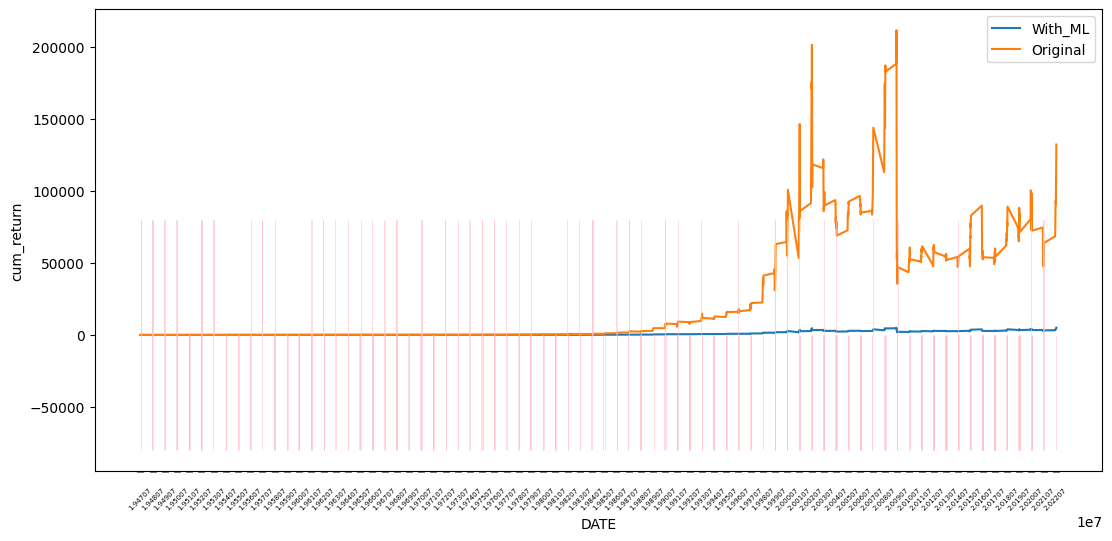

In [124]:
GBC_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_GBC_Result,
                                                  WML,
                                                  'GBC_PROB_POS_WML',
                                                  GBC_A0_P1,
                                                  GBC_A1_P0,
                                                  plot=True)

### XGB

In [125]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

**************************************************

XGB Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : No

  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.25      0.30       316
         1.0       0.65      0.75      0.70       590

    accuracy                           0.58       906
   macro avg       0.50      0.50      0.50       906
weighted avg       0.55      0.58      0.56       906


accuracy : 0.5783664459161147

precision : 0.6529411764705882

recall : 0.752542372881356

F1-Score : 0.6992125984251969



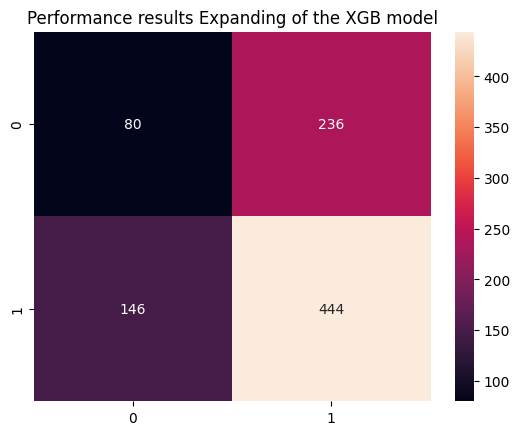


Feature Importance of the model



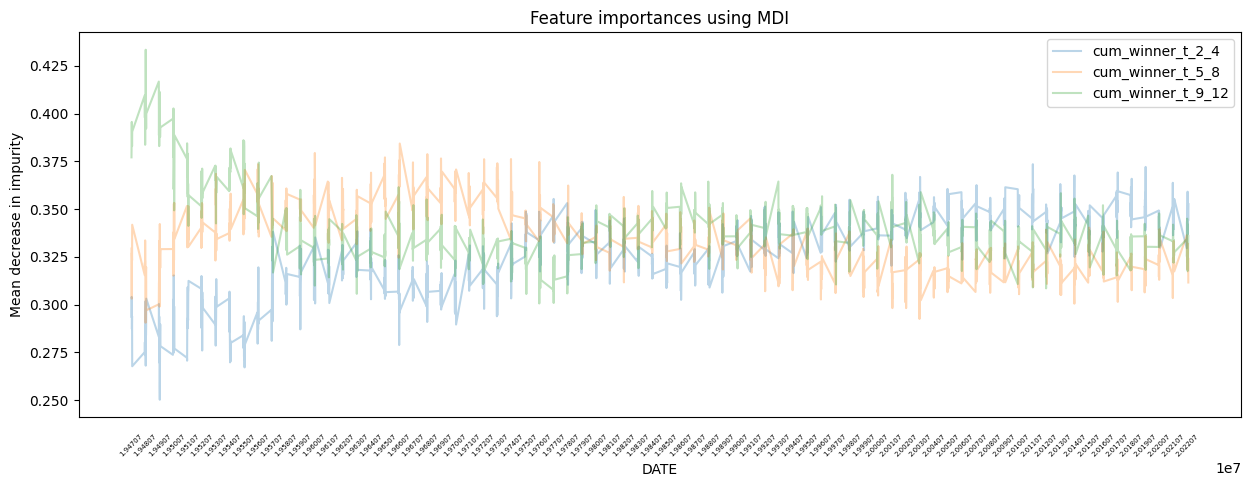

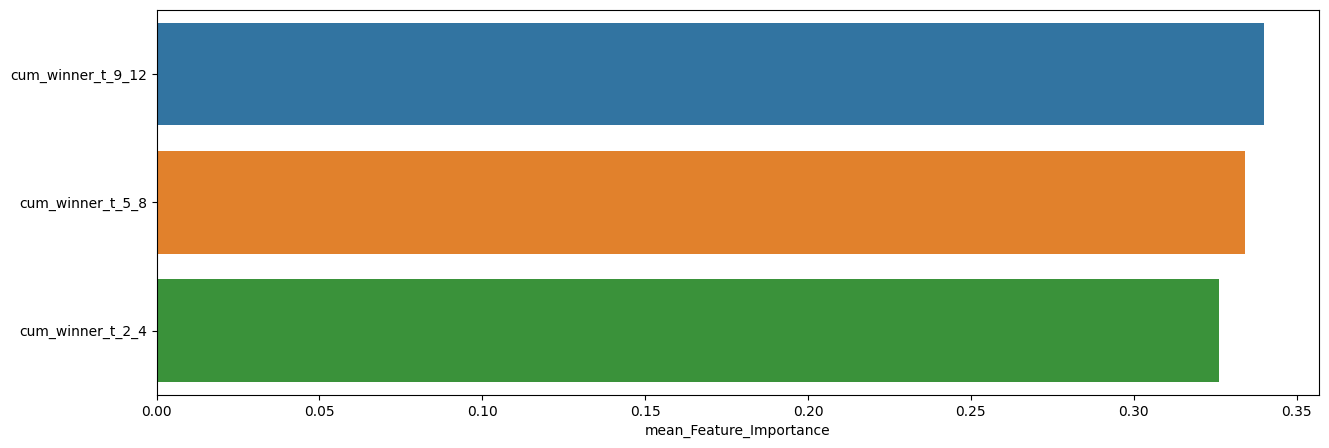

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12                 0.339910                0.433385   
cum_winner_t_5_8                  0.334026                0.384296   
cum_winner_t_2_4                  0.326064                0.373464   

                   min_Feature_Importance  
cum_winner_t_9_12                0.300579  
cum_winner_t_5_8                 0.290519  
cum_winner_t_2_4                 0.250184

In [126]:
Expanding_XGB_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                  model=XGB, # 사용할 모델
                                  model_name='XGB', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.27      0.29        75
         1.0       0.67      0.73      0.70       151

    accuracy                           0.58       226
   macro avg       0.50      0.50      0.50       226
weighted avg       0.55      0.58      0.56       226


accuracy : 0.5752212389380531

precision : 0.6666666666666666

recall : 0.7284768211920529

F1-Score : 0.6962025316455696



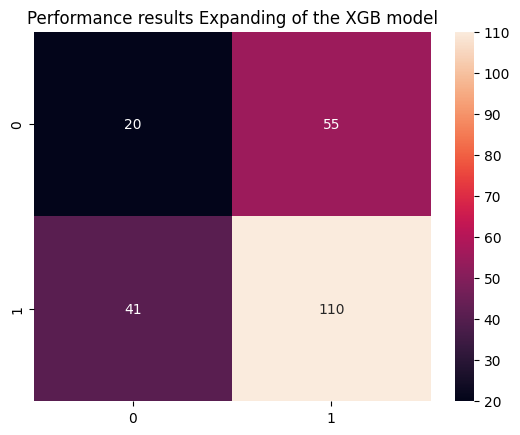


Feature Importance of the model



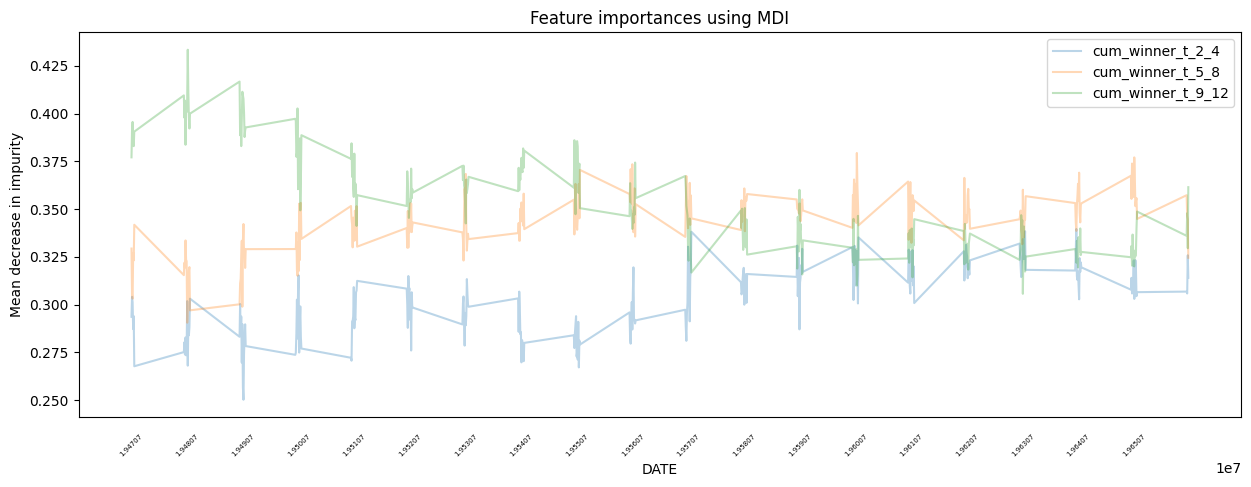

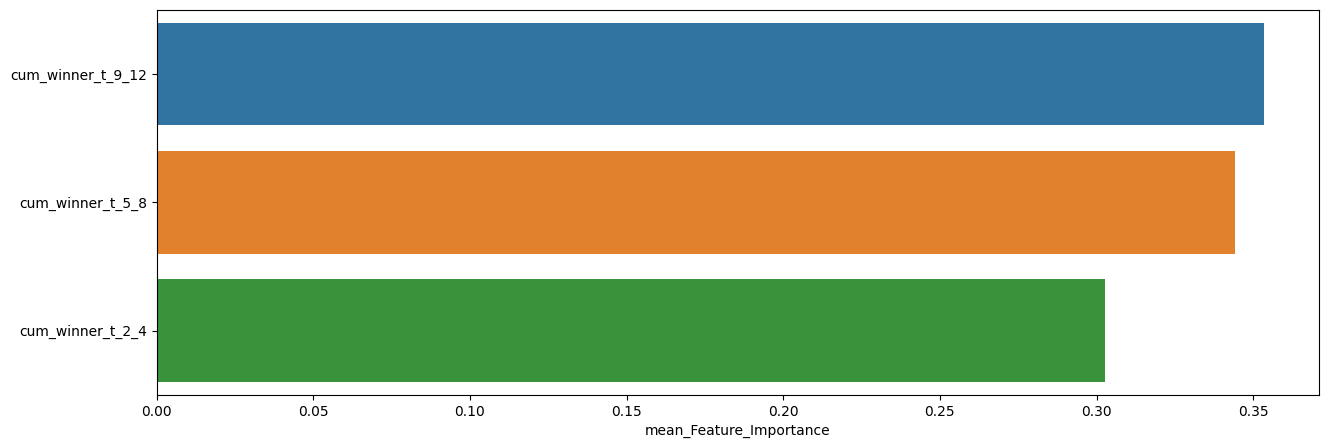

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12                 0.353350                0.433385   
cum_winner_t_5_8                  0.344029                0.379341   
cum_winner_t_2_4                  0.302621                0.339542   

                   min_Feature_Importance  
cum_winner_t_9_12                0.305630  
cum_winner_t_5_8                 0.290519  
cum_winner_t_2_4                 0.250184


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.25      0.27        75
         1.0       0.65      0.70      0.68       151

    accuracy                           0.55       226
   macro avg       0.48      0.48      0.48       226
weighted avg       0.54      0.55      0.54       226


accuracy : 0.5530973451327433

precision : 0.654320987654321

recall : 0.7019867549668874

F1-Score : 0.6773162939297125



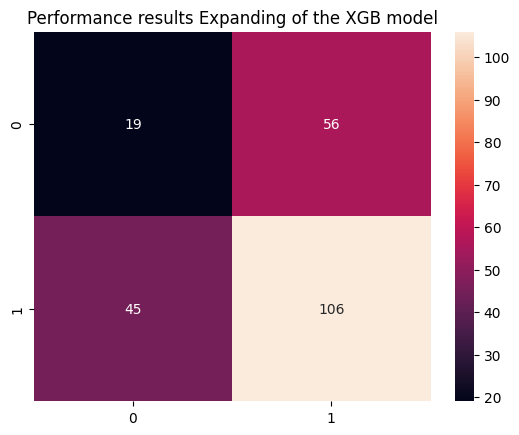


Feature Importance of the model



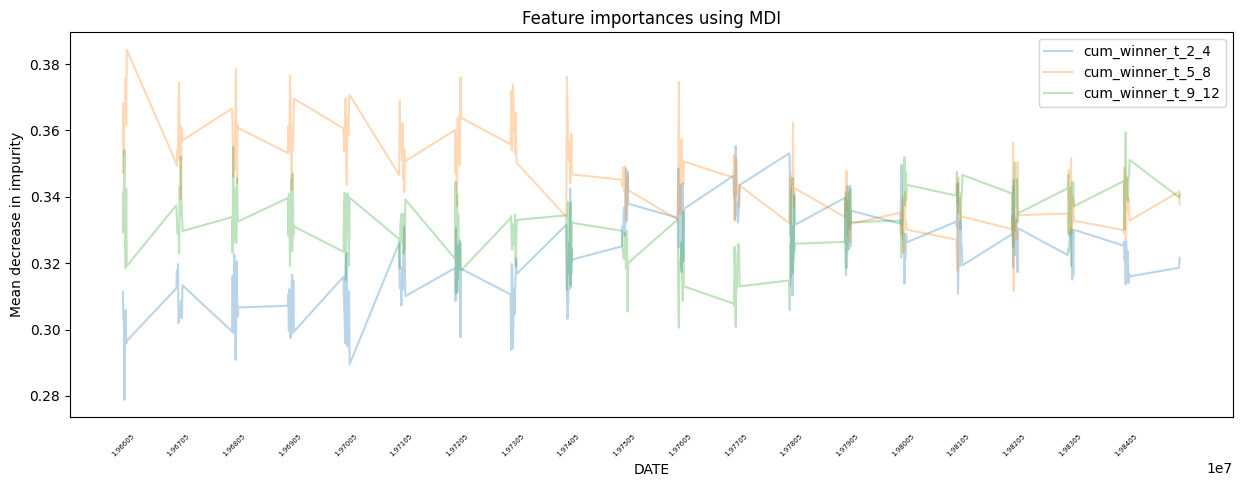

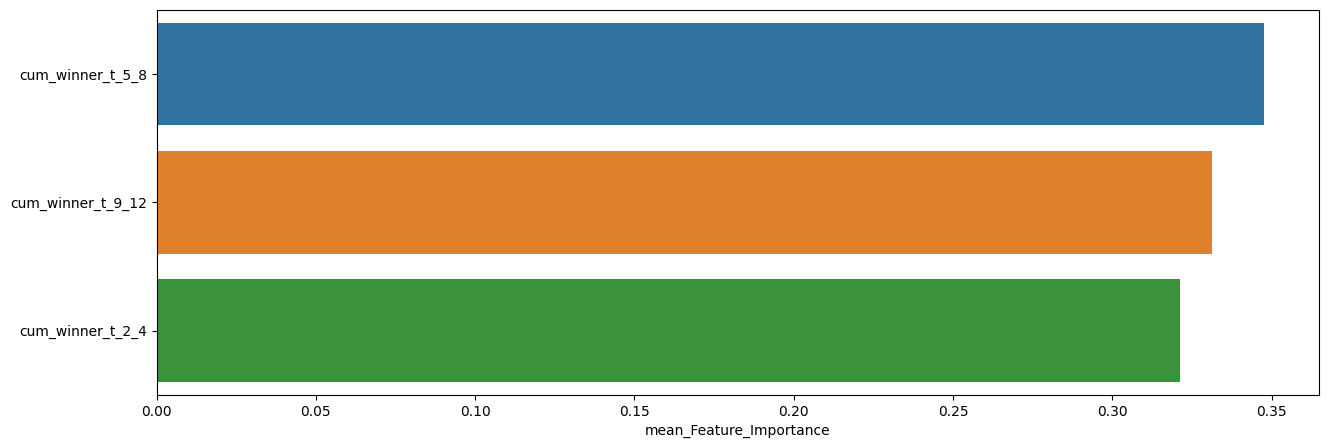

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_5_8                  0.347505                0.384296   
cum_winner_t_9_12                 0.331353                0.359450   
cum_winner_t_2_4                  0.321142                0.355306   

                   min_Feature_Importance  
cum_winner_t_5_8                 0.311615  
cum_winner_t_9_12                0.300579  
cum_winner_t_2_4                 0.278827


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.26      0.28        70
         1.0       0.69      0.75      0.72       156

    accuracy                           0.60       226
   macro avg       0.50      0.50      0.50       226
weighted avg       0.58      0.60      0.58       226


accuracy : 0.5973451327433629

precision : 0.6923076923076923

recall : 0.75

F1-Score : 0.7199999999999999



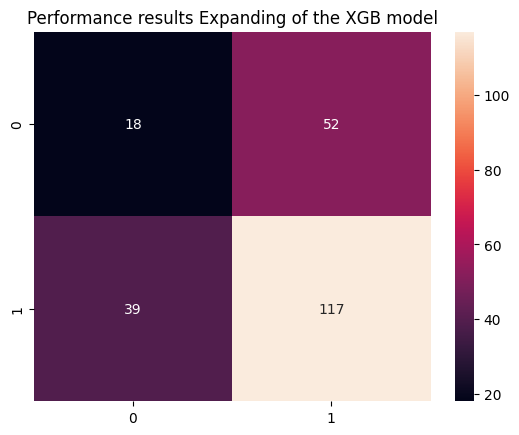


Feature Importance of the model



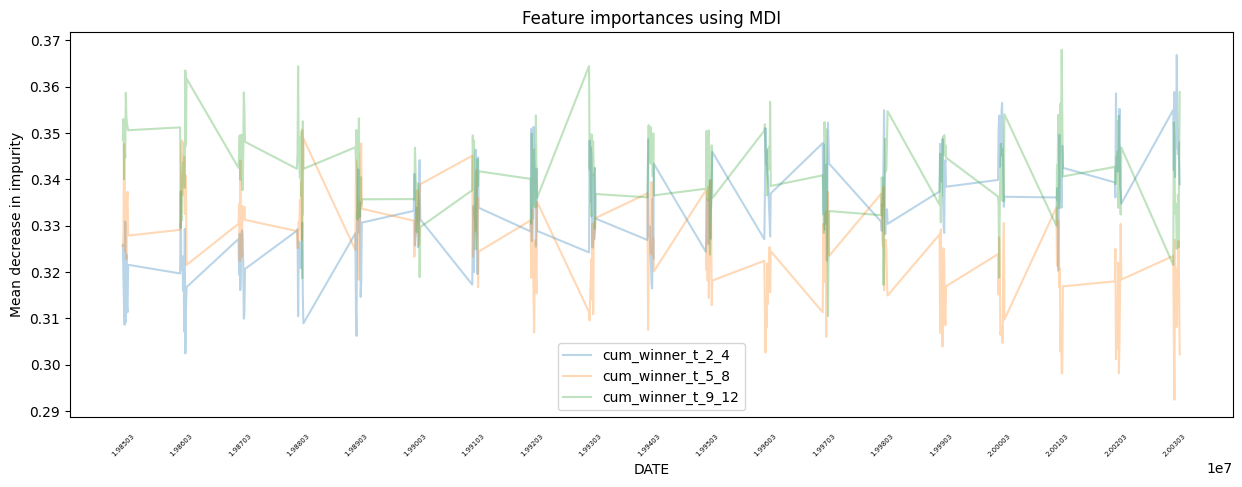

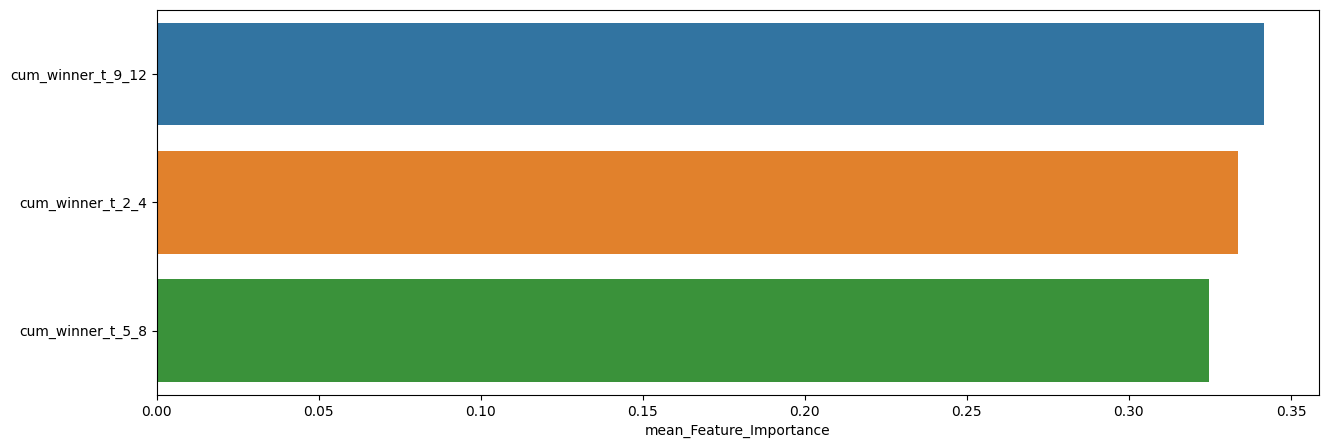

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12                 0.341605                0.367932   
cum_winner_t_2_4                  0.333578                0.366803   
cum_winner_t_5_8                  0.324816                0.350692   

                   min_Feature_Importance  
cum_winner_t_9_12                0.310521  
cum_winner_t_2_4                 0.302466  
cum_winner_t_5_8                 0.292468


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.52      0.24      0.33        96
         1.0       0.60      0.84      0.70       132

    accuracy                           0.59       228
   macro avg       0.56      0.54      0.52       228
weighted avg       0.57      0.59      0.55       228


accuracy : 0.5877192982456141

precision : 0.6032608695652174

recall : 0.8409090909090909

F1-Score : 0.7025316455696202



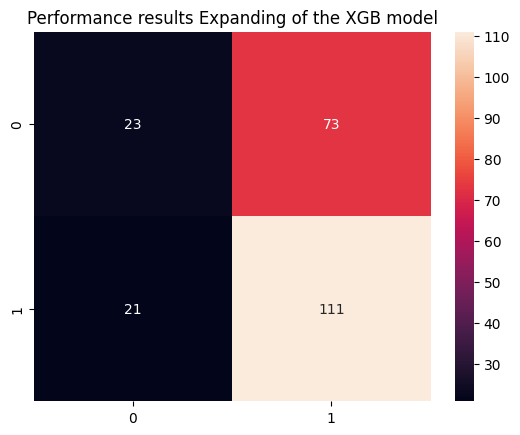


Feature Importance of the model



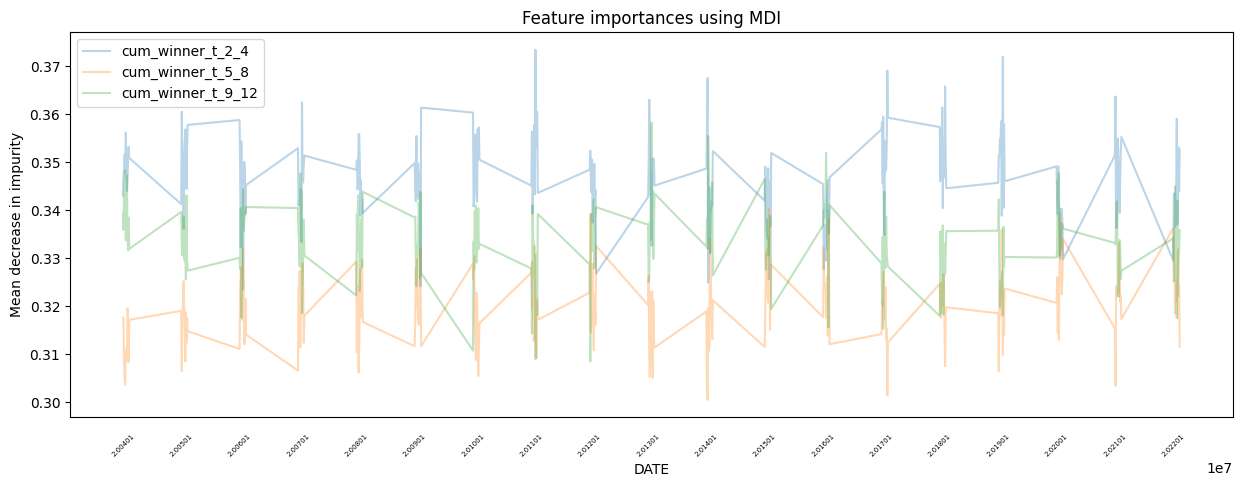

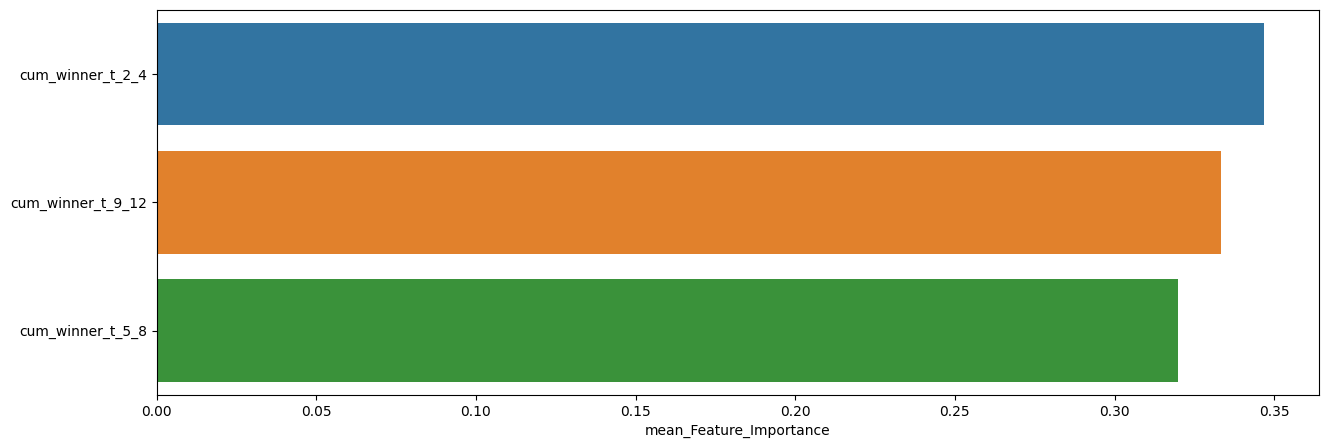

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_2_4                  0.346732                0.373464   
cum_winner_t_9_12                 0.333391                0.358279   
cum_winner_t_5_8                  0.319877                0.340250   

                   min_Feature_Importance  
cum_winner_t_2_4                 0.323481  
cum_winner_t_9_12                0.308480  
cum_winner_t_5_8                 0.300470

In [127]:
slice_feature_importance(Expanding_XGB_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'XGB') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



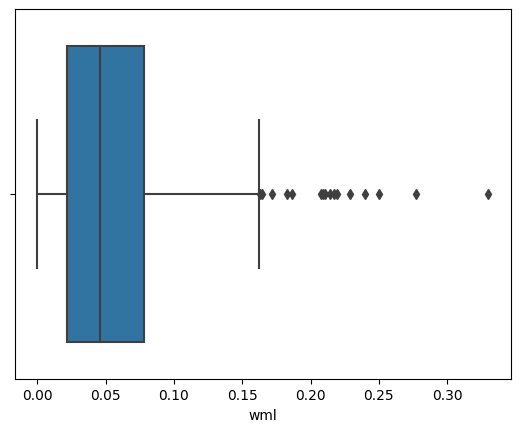

count      mean       std       min       25%       50%       75%  \
wml  444.0  0.056104  0.048135  0.000007  0.021722  0.045567  0.078041   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



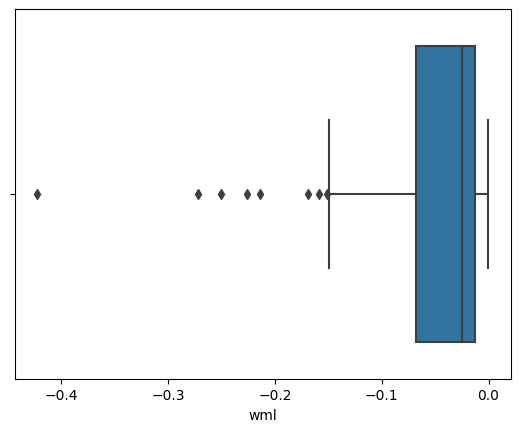

count      mean       std     min       25%       50%       75%       max
wml   80.0 -0.053562  0.073056 -0.4224 -0.067531 -0.024416 -0.012335 -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



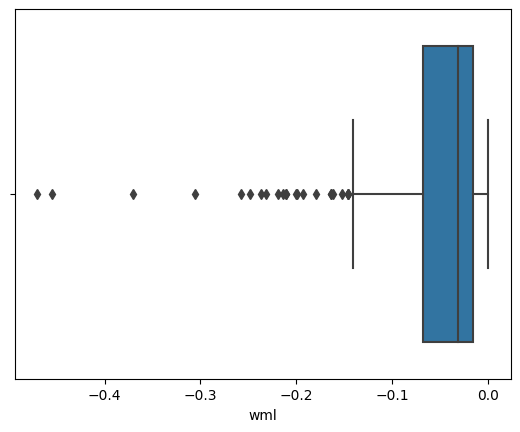

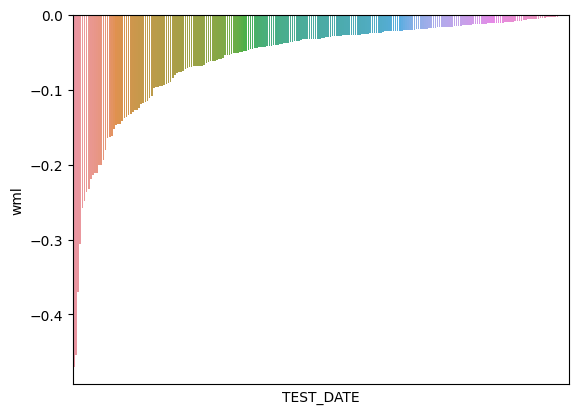

count      mean       std       min       25%       50%       75%  \
wml  236.0 -0.057243  0.070741 -0.469903 -0.067966 -0.031242 -0.016141   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



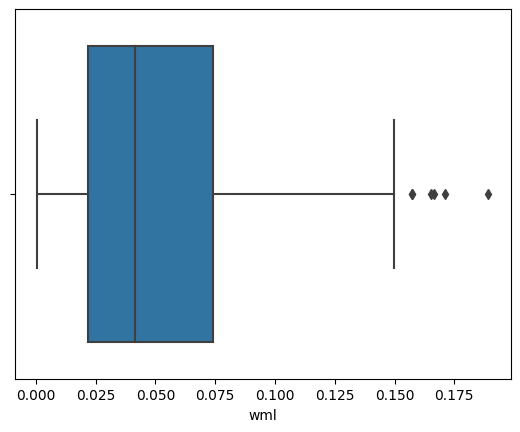

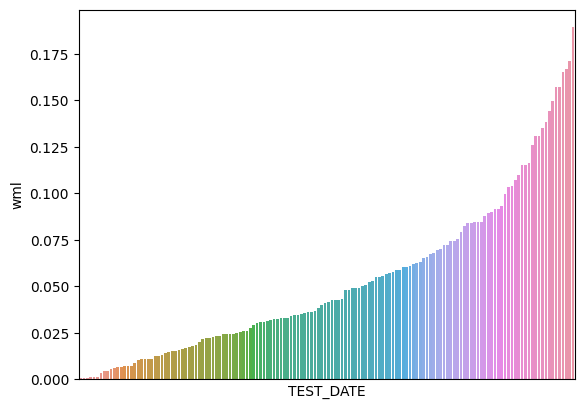

count      mean       std       min       25%       50%       75%  \
wml  146.0  0.052653  0.042582  0.000627  0.021621  0.041467  0.073888   

          max  
wml  0.189223

In [128]:
XGB_A0_P1, XGB_A1_P0 = What_Pred(Expanding_XGB_Result, WML, 'XGB')

Sharpe Ratio : 0.59029

최근 누적 수익률

  2022년-12월 -> 8923.22
  2022년-11월 -> 8923.22
  2022년-10월 -> 8487.81
  2022년-09월 -> 7515.74
  2022년-08월 -> 6832.83

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 8923.22
  2등 : 2022년-11월 -> 8923.22
  3등 : 2022년-10월 -> 8487.81
  4등 : 2022년-09월 -> 7515.74
  5등 : 2022년-07월 -> 6985.53
  6등 : 2022년-08월 -> 6832.83
  7등 : 2020년-09월 -> 6790.11
  8등 : 2020년-10월 -> 6766.71
  9등 : 2020년-07월 -> 6729.54
  10등 : 2020년-08월 -> 6729.54



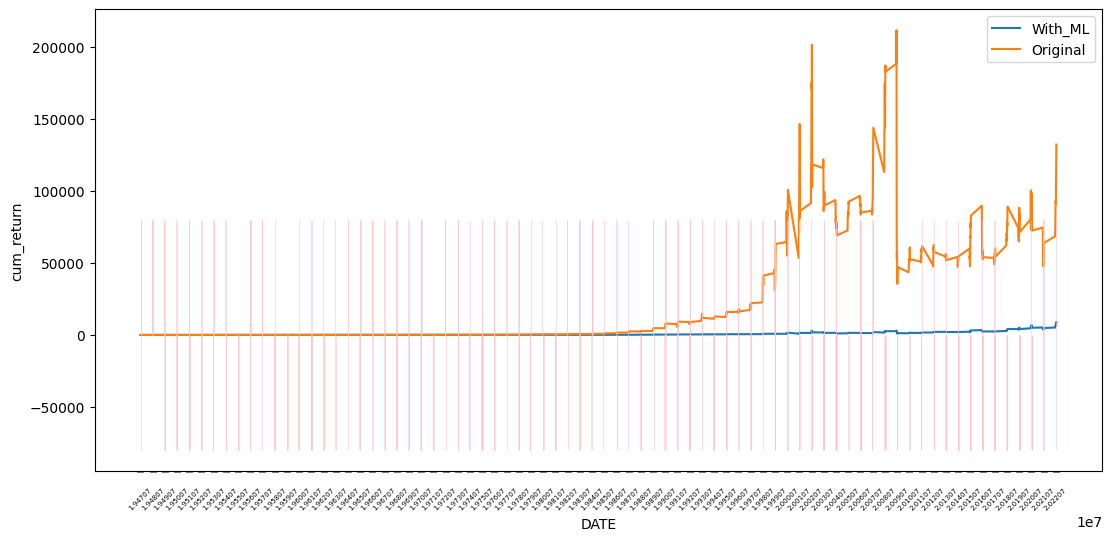

In [129]:
XGB_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_XGB_Result,
                                                 WML,
                                                 'XGB_PRED_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.70476

최근 누적 수익률

  2022년-12월 -> 6017.26
  2022년-11월 -> 5766.35
  2022년-10월 -> 5568.98
  2022년-09월 -> 4971.75
  2022년-08월 -> 4647.89

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 6017.26
  2등 : 2022년-11월 -> 5766.35
  3등 : 2022년-10월 -> 5568.98
  4등 : 2022년-09월 -> 4971.75
  5등 : 2022년-07월 -> 4741.42
  6등 : 2020년-09월 -> 4695.83
  7등 : 2020년-10월 -> 4685.31
  8등 : 2020년-08월 -> 4660.34
  9등 : 2022년-08월 -> 4647.89
  10등 : 2022년-06월 -> 4564.86



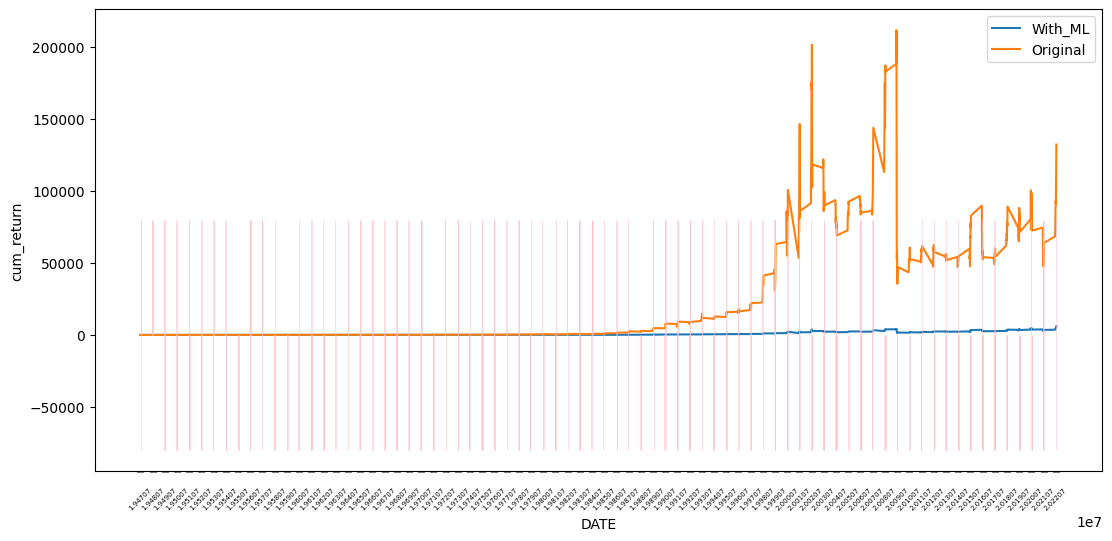

In [130]:
XGB_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_XGB_Result,
                                                 WML,
                                                 'XGB_PROB_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

### LGBM

In [131]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

**************************************************

LGBM Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.25      0.30       316
         1.0       0.66      0.77      0.71       590

    accuracy                           0.59       906
   macro avg       0.51      0.51      0.50       906
weighted avg       0.56      0.59      0.56       906


accuracy : 0.58719646799117

precision : 0.6565217391304348

recall : 0.7677966101694915

F1-Score : 0.7078125



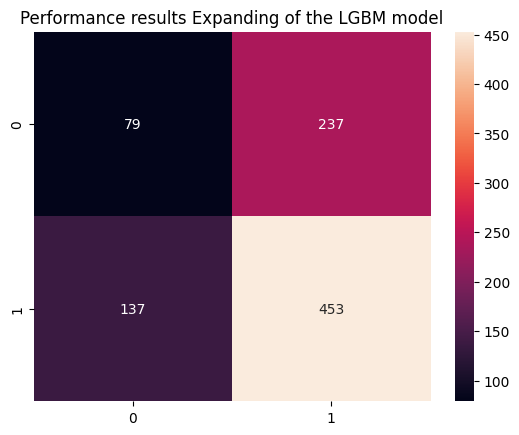


Feature Importance of the model



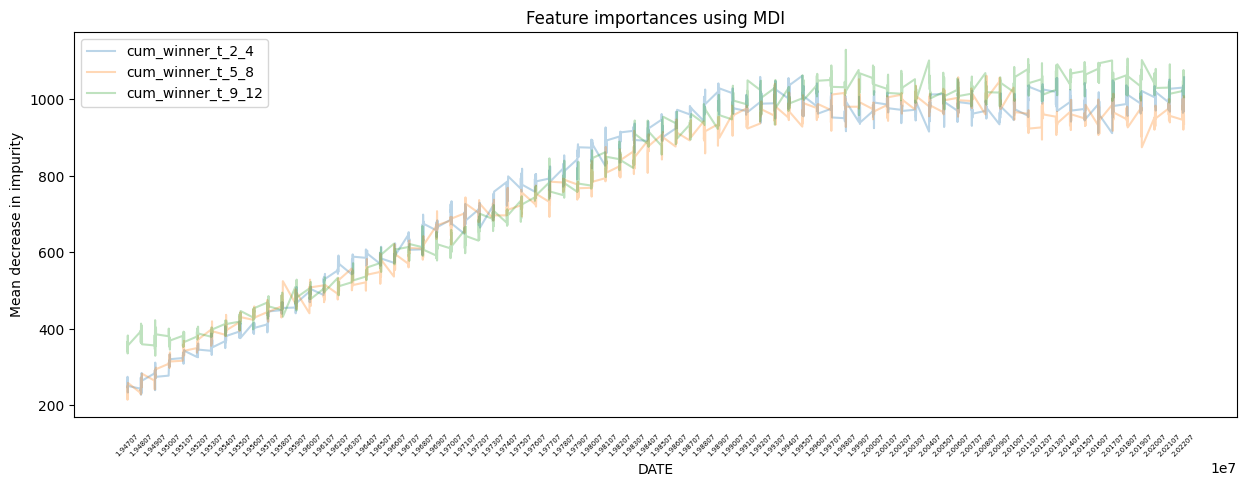

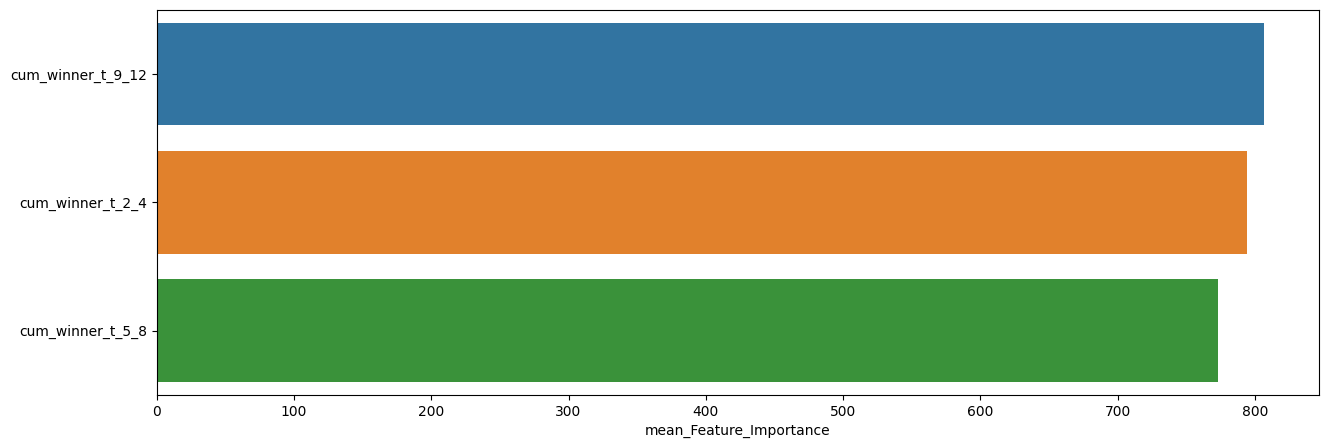

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12               806.316777                    1130   
cum_winner_t_2_4                793.855408                    1062   
cum_winner_t_5_8                772.813466                    1062   

                   min_Feature_Importance  
cum_winner_t_9_12                     330  
cum_winner_t_2_4                      228  
cum_winner_t_5_8                      215

In [132]:
Expanding_LGBM_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                    window_size=240, # window size (훈련 데이터 셋 크기)
                                    method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                    model=LGBM, # 사용할 모델
                                    model_name='LGBM', # 사용한 모델 명
                                    plot=True, # 모델 성능 지표 시각화 여부
                                    plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.28      0.32        75
         1.0       0.68      0.75      0.71       151

    accuracy                           0.60       226
   macro avg       0.52      0.52      0.52       226
weighted avg       0.57      0.60      0.58       226


accuracy : 0.5973451327433629

precision : 0.6785714285714286

recall : 0.7549668874172185

F1-Score : 0.7147335423197492



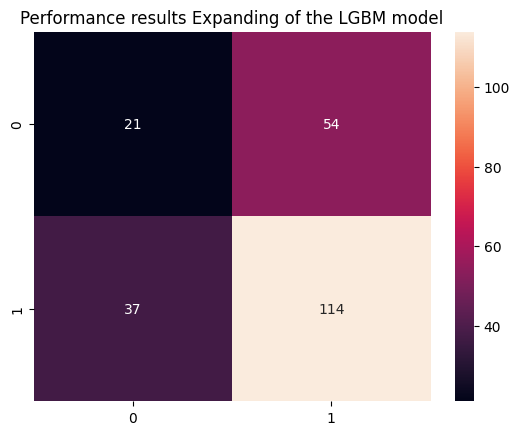


Feature Importance of the model



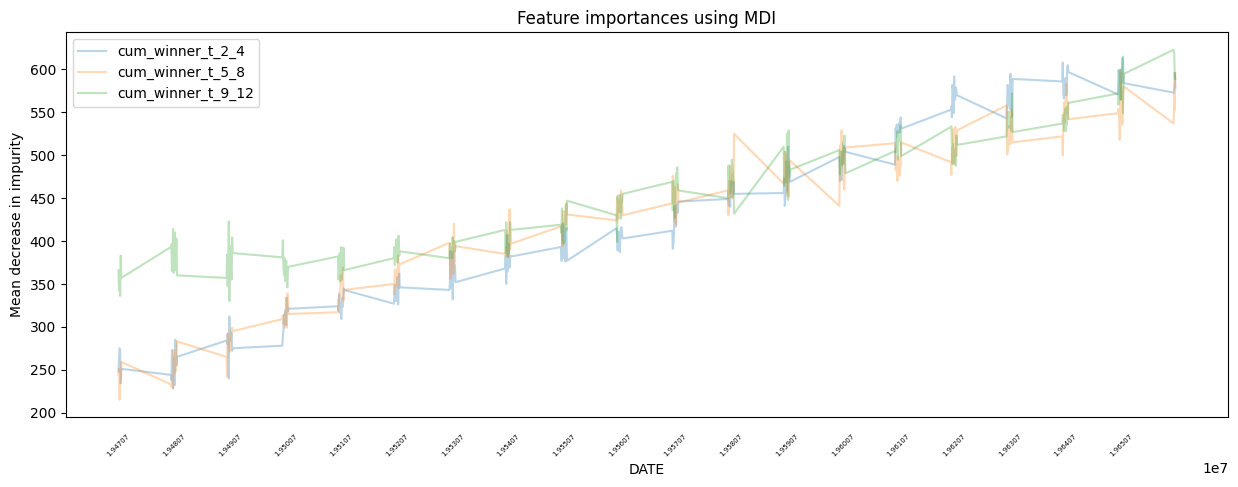

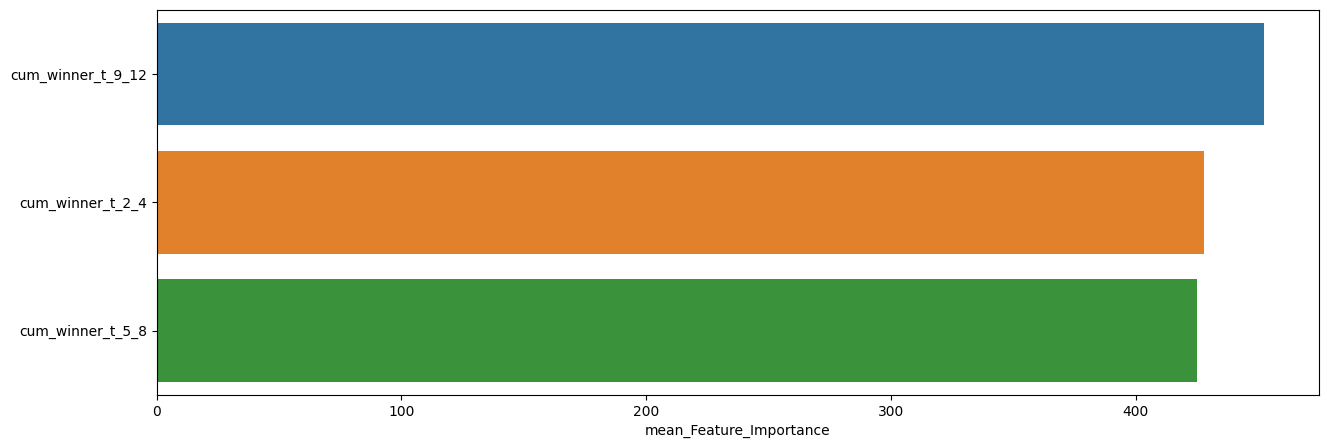

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12               452.305310                     623   
cum_winner_t_2_4                427.805310                     615   
cum_winner_t_5_8                425.234513                     597   

                   min_Feature_Importance  
cum_winner_t_9_12                     330  
cum_winner_t_2_4                      228  
cum_winner_t_5_8                      215


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.28      0.31        75
         1.0       0.67      0.74      0.71       151

    accuracy                           0.59       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.57      0.59      0.58       226


accuracy : 0.588495575221239

precision : 0.6746987951807228

recall : 0.7417218543046358

F1-Score : 0.7066246056782335



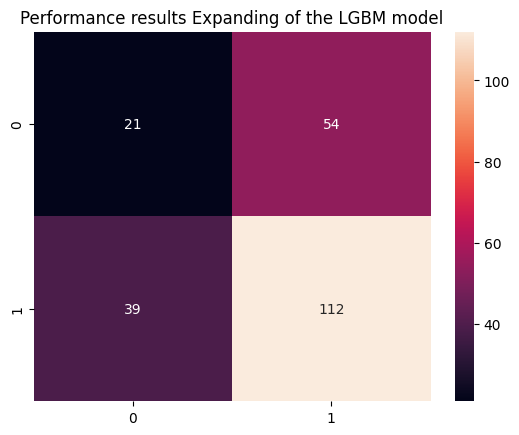


Feature Importance of the model



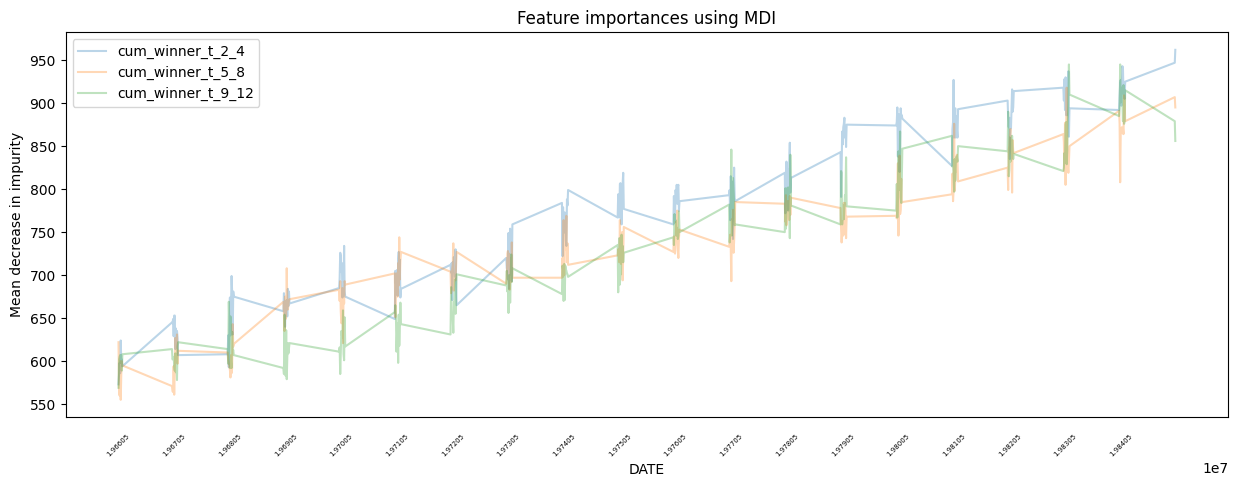

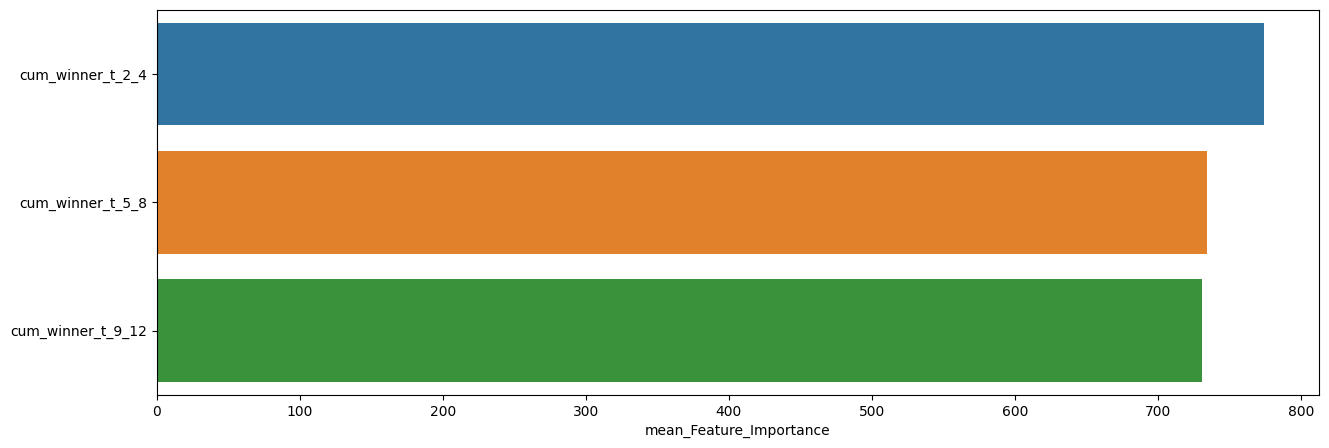

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_2_4                773.787611                     962   
cum_winner_t_5_8                734.402655                     918   
cum_winner_t_9_12               730.504425                     945   

                   min_Feature_Importance  
cum_winner_t_2_4                      573  
cum_winner_t_5_8                      555  
cum_winner_t_9_12                     569


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.31      0.24      0.27        70
         1.0       0.69      0.76      0.72       156

    accuracy                           0.60       226
   macro avg       0.50      0.50      0.50       226
weighted avg       0.57      0.60      0.58       226


accuracy : 0.5973451327433629

precision : 0.6900584795321637

recall : 0.7564102564102564

F1-Score : 0.7217125382262997



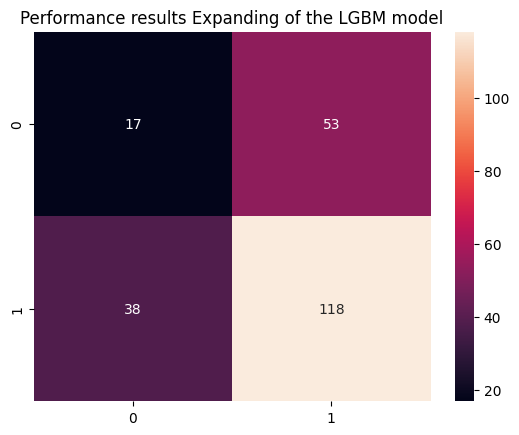


Feature Importance of the model



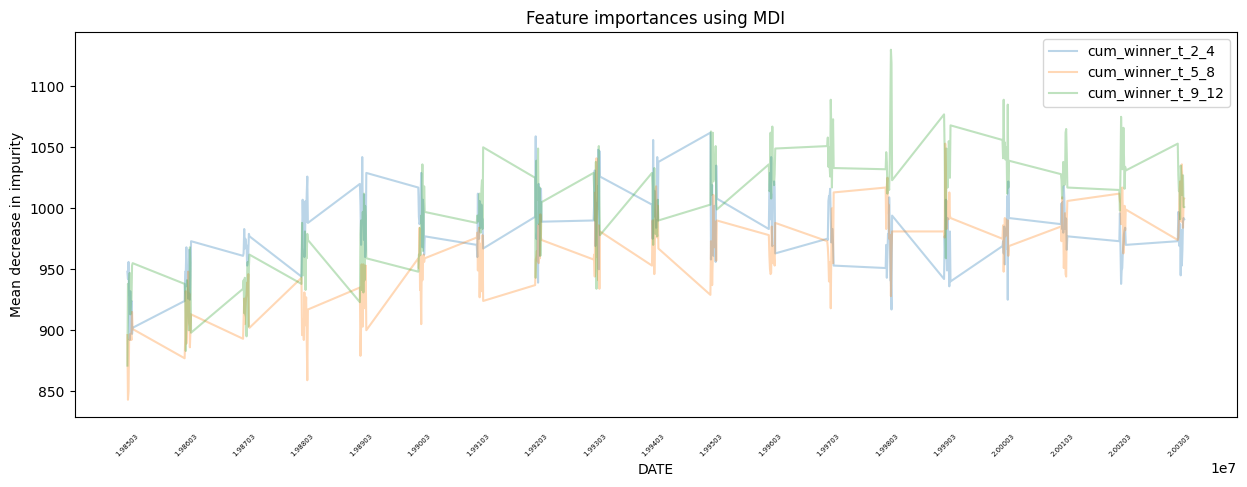

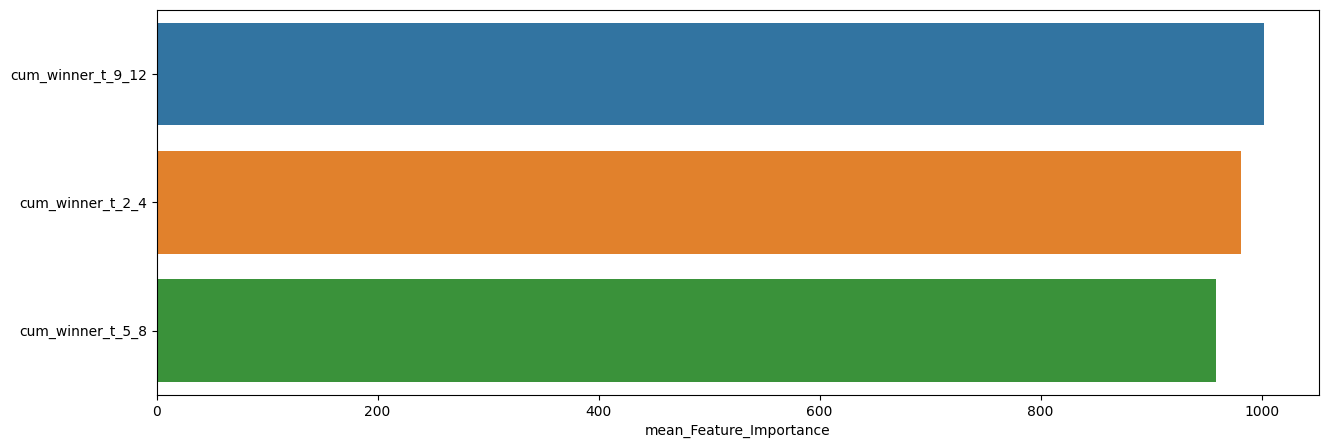

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12              1001.858407                    1130   
cum_winner_t_2_4                981.446903                    1062   
cum_winner_t_5_8                959.048673                    1053   

                   min_Feature_Importance  
cum_winner_t_9_12                     871  
cum_winner_t_2_4                      892  
cum_winner_t_5_8                      843


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.47      0.21      0.29        96
         1.0       0.59      0.83      0.69       132

    accuracy                           0.57       228
   macro avg       0.53      0.52      0.49       228
weighted avg       0.54      0.57      0.52       228


accuracy : 0.5657894736842105

precision : 0.5891891891891892

recall : 0.8257575757575758

F1-Score : 0.6876971608832807



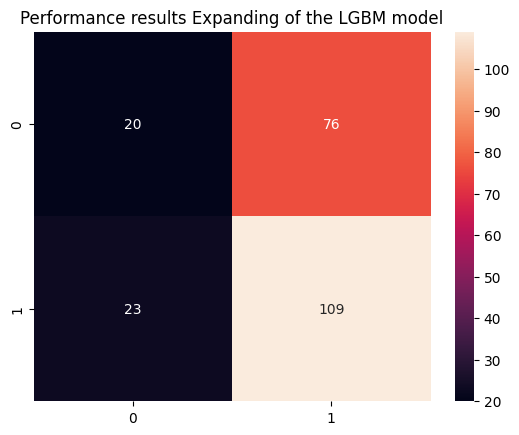


Feature Importance of the model



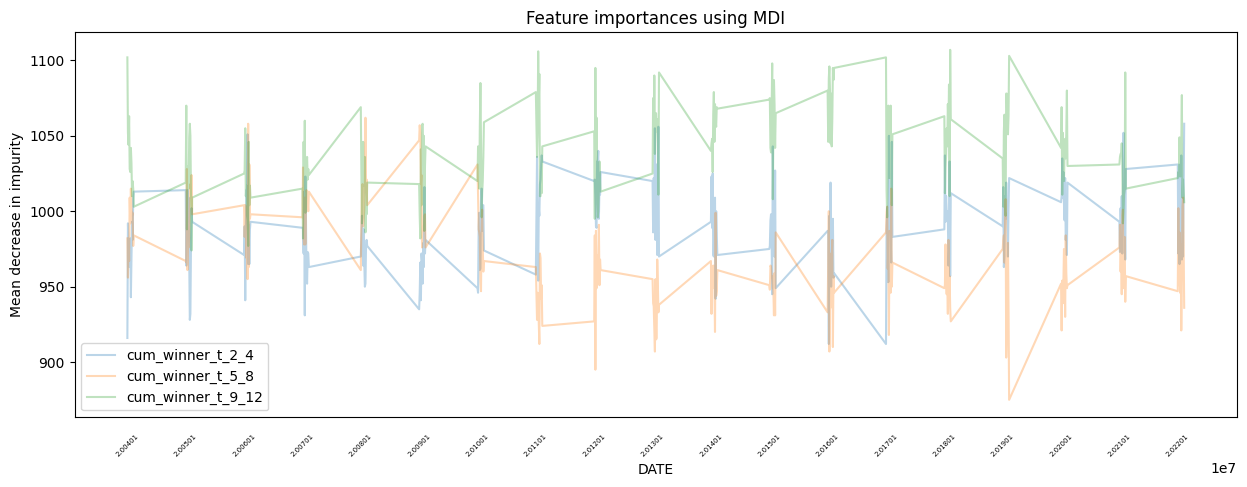

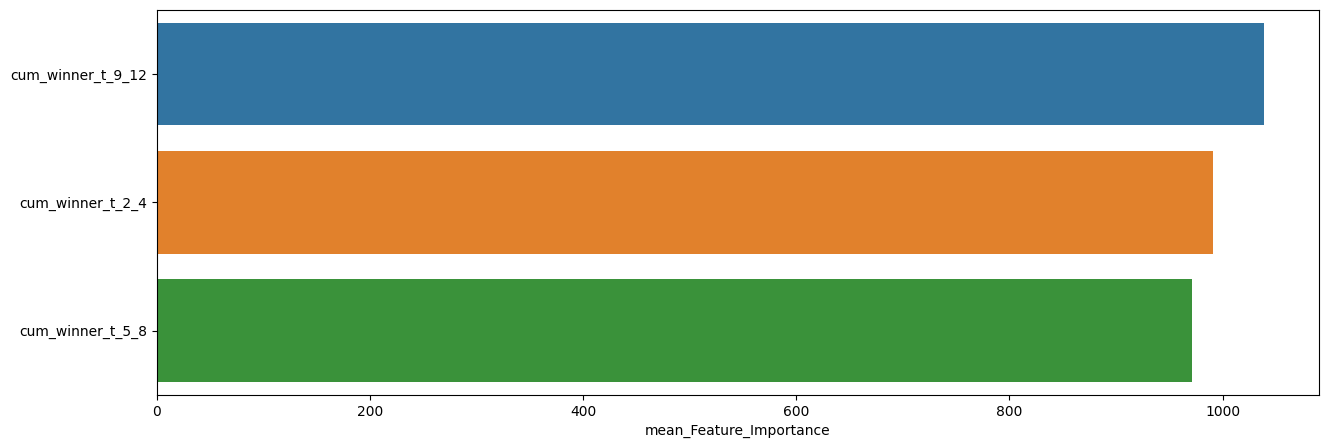

mean_Feature_Importance  max_Feature_Importance  \
cum_winner_t_9_12              1038.543860                    1107   
cum_winner_t_2_4                990.640351                    1058   
cum_winner_t_5_8                970.815789                    1062   

                   min_Feature_Importance  
cum_winner_t_9_12                     974  
cum_winner_t_2_4                      912  
cum_winner_t_5_8                      875

In [133]:
slice_feature_importance(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                        4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                        'Expanding', # Rolling Windows Method
                        'LGBM') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



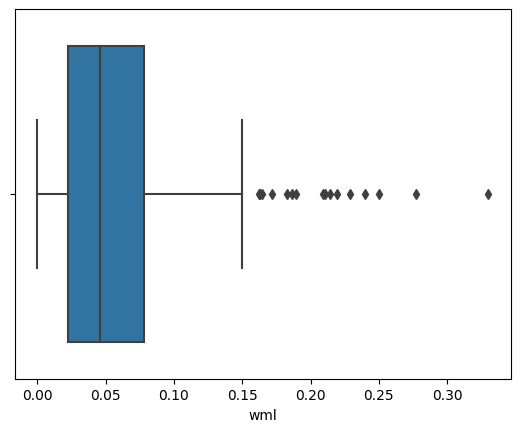

count      mean       std       min       25%       50%       75%  \
wml  453.0  0.056311  0.047441  0.000007  0.022327  0.045577  0.078158   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



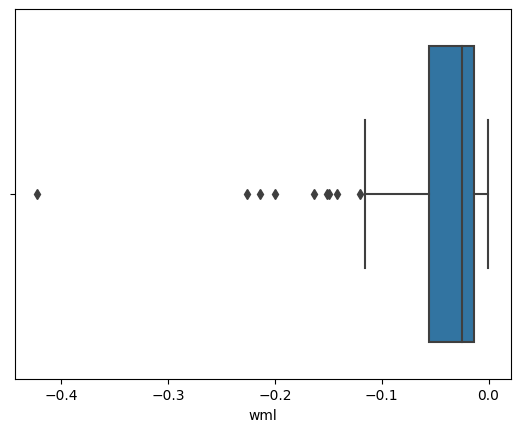

count      mean       std     min       25%       50%       75%       max
wml   79.0 -0.049737  0.065547 -0.4224 -0.055881 -0.025151 -0.013722 -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



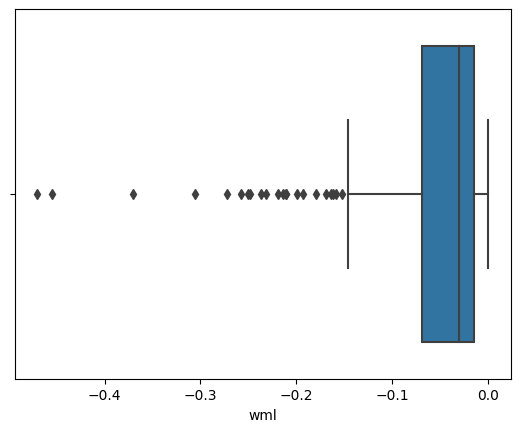

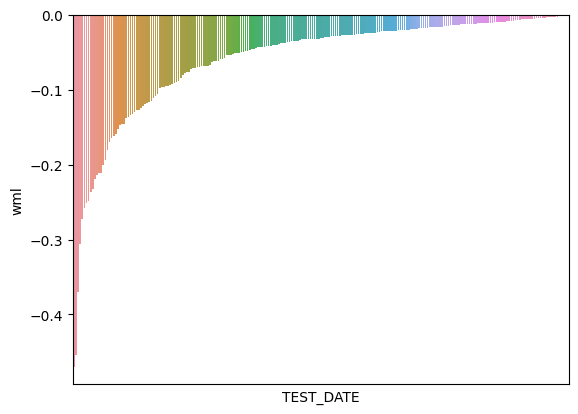

count      mean       std       min       25%       50%       75%  \
wml  237.0 -0.058502  0.073033 -0.469903 -0.069483 -0.030902 -0.015289   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



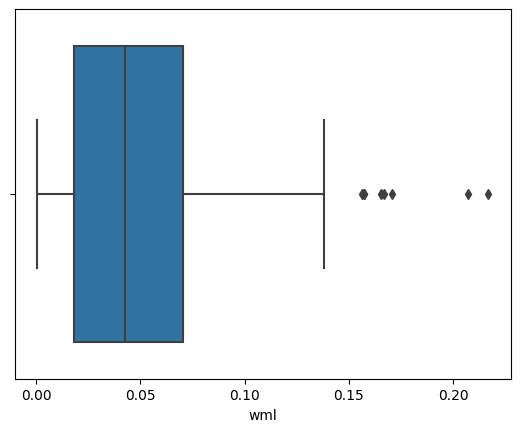

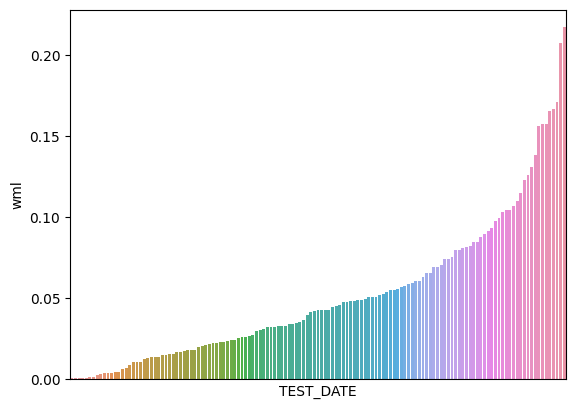

count     mean       std       min       25%       50%      75%       max
wml  137.0  0.05174  0.044654  0.000627  0.018192  0.042611  0.07036  0.216883

In [134]:
LGBM_A0_P1, LGBM_A1_P0 = What_Pred(Expanding_LGBM_Result,
                                   WML,
                                   'LGBM')

Sharpe Ratio : 0.75142

최근 누적 수익률

  2022년-12월 -> 10408.36
  2022년-11월 -> 10408.36
  2022년-10월 -> 9900.50
  2022년-09월 -> 8766.65
  2022년-08월 -> 7970.10

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 10408.36
  2등 : 2022년-11월 -> 10408.36
  3등 : 2022년-10월 -> 9900.50
  4등 : 2002년-09월 -> 9755.70
  5등 : 2022년-09월 -> 8766.65
  6등 : 2020년-03월 -> 8595.90
  7등 : 2002년-07월 -> 8495.02
  8등 : 2002년-08월 -> 8248.88
  9등 : 2000년-12월 -> 8158.21
  10등 : 2022년-07월 -> 8148.21



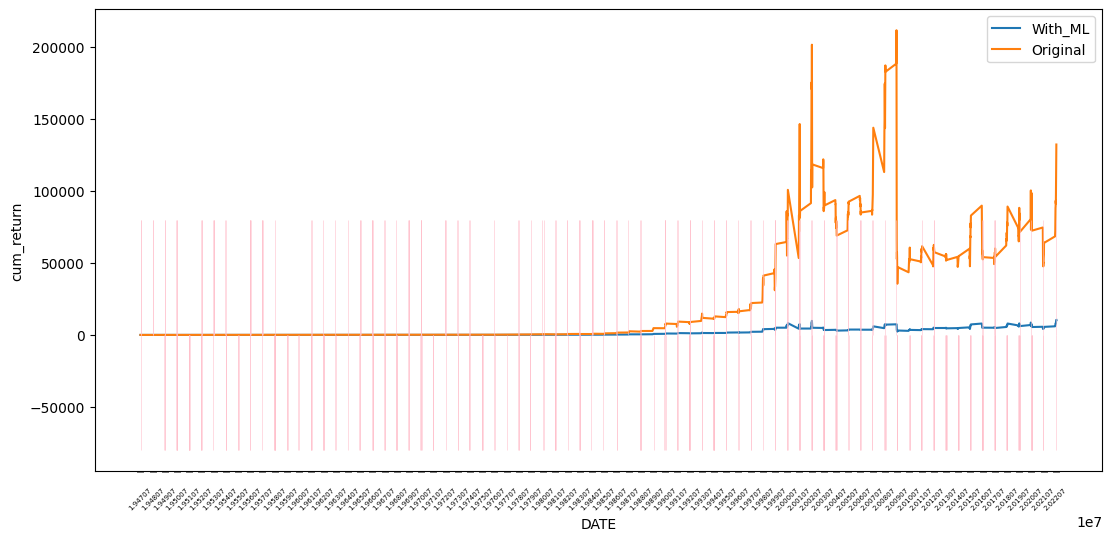

In [135]:
LGBM_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PRED_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

Sharpe Ratio : 0.72897

최근 누적 수익률

  2022년-12월 -> 8380.14
  2022년-11월 -> 8065.96
  2022년-10월 -> 7838.91
  2022년-09월 -> 7005.94
  2022년-08월 -> 6655.83

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 8380.14
  2등 : 2022년-11월 -> 8065.96
  3등 : 2022년-10월 -> 7838.91
  4등 : 2022년-09월 -> 7005.94
  5등 : 2002년-09월 -> 6863.51
  6등 : 2022년-07월 -> 6794.27
  7등 : 2022년-08월 -> 6655.83
  8등 : 2009년-02월 -> 6613.73
  9등 : 2022년-06월 -> 6588.05
  10등 : 2022년-05월 -> 6510.45



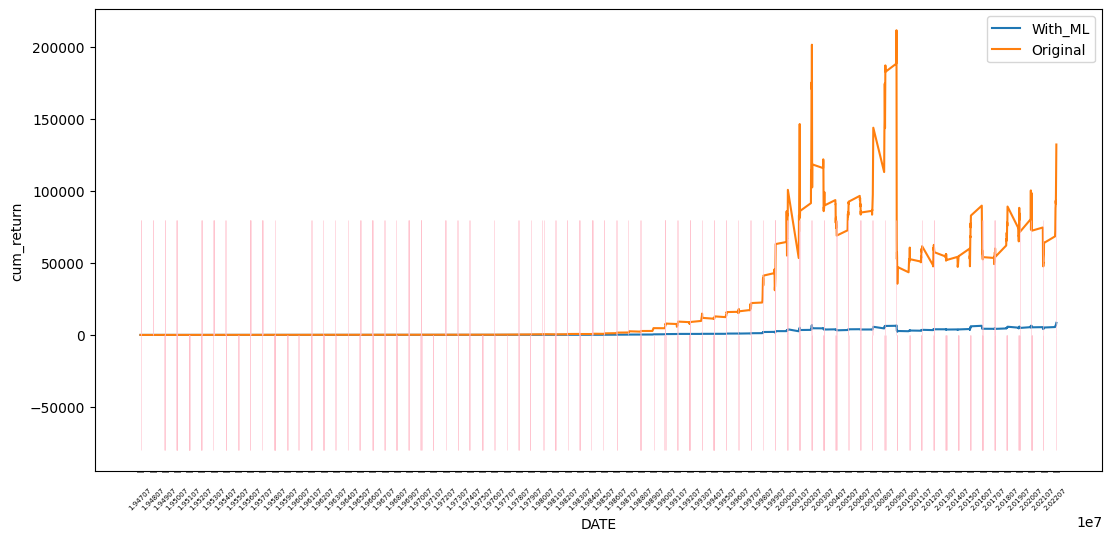

In [136]:
LGBM_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PROB_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

# Performance

## F1 - Score

RDF의 F1-Score : 0.7189642041127189
GBC의 F1-Score : 0.7127496159754225
XGB의 F1-Score : 0.7020933977455717
LGBM의 F1-Score : 0.7104851330203442



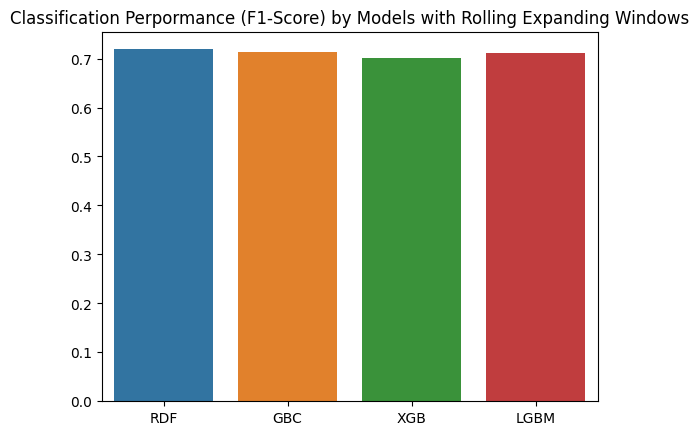

In [137]:
list_model = ['RDF', 'GBC', 'XGB', 'LGBM']
list_result = [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result]

list_f1 = []

for model, data in zip(list_model, list_result):
  F1 = f1_score(data['Actual_POS_WML'], data[f'{model}_PRED_POS_WML'])
  print(f'{model}의 F1-Score : {F1}')
  list_f1.append(F1)
print()

sns.barplot(x=list_model, y=list_f1)
plt.title('Classification Perpormance (F1-Score) by Models with Rolling Expanding Windows')
plt.show()

RDF의 F1-Score : 0.7313769751693003
GBC의 F1-Score : 0.7394468704512374
XGB의 F1-Score : 0.6992125984251969
LGBM의 F1-Score : 0.7078125



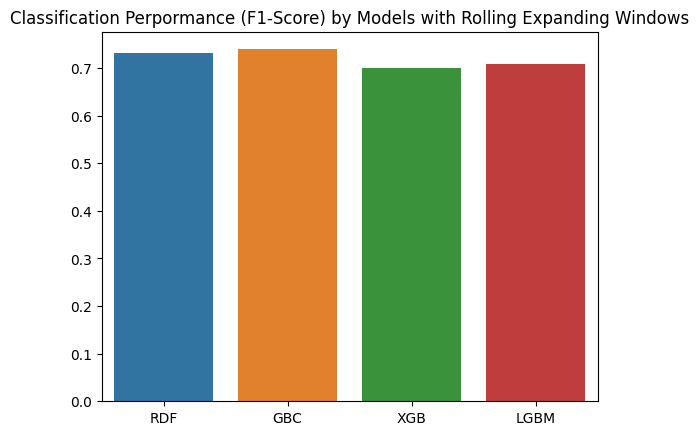

In [138]:
list_model = ['RDF', 'GBC', 'XGB', 'LGBM']
list_result = [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result]

list_f1 = []

for model, data in zip(list_model, list_result):
  F1 = f1_score(data['Actual_POS_WML'], data[f'{model}_PRED_POS_WML'])
  print(f'{model}의 F1-Score : {F1}')
  list_f1.append(F1)
print()

sns.barplot(x=list_model, y=list_f1)
plt.title('Classification Perpormance (F1-Score) by Models with Rolling Expanding Windows')
plt.show()

## Cum Return & Sharpe Ratio

In [139]:
R_WML = WML.loc[19470731:].copy()
CUM_WML = WML.loc[19470731:].copy()

CUM_WML['wml'] = (1 + CUM_WML.wml).cumprod() - 1
CUM_WML.columns = ['cum_return'] 

last_r = CUM_WML['cum_return'].values[-1]
w_S = (R_WML['wml'].mean()/R_WML['wml'].std()) * math.sqrt(12)

In [140]:
def compare_sharpe_ratio(list_model, list_result, list_cum, dynamic=True):

  print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format('ORG', w_S, last_r))

  for model, data, cum in zip(list_model, list_result, list_cum):
    data['wml'] = WML.loc[19470731:]['wml']

    if dynamic == True:

      data[f'{model}_PROB_WML'] = data['wml'] * data[f'{model}_PROB_POS_WML']
      S = (data[f'{model}_PROB_WML'].mean()/data[f'{model}_PROB_WML'].std())*math.sqrt(12)

      C = list(cum['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))

      sns.lineplot(data=cum, x=data.index, y='cum_return', alpha=0.7, label=model)

    else:

      data[f'{model}_PRED_WML'] = data['wml'] * data[f'{model}_PRED_POS_WML']
      S = (data[f'{model}_PRED_WML'].mean()/data[f'{model}_PRED_WML'].std())*math.sqrt(12)

      C = list(cum['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))
      
      sns.lineplot(data=cum, x=data.index, y='cum_return', alpha=0.7, label=model)

  sns.lineplot(data=CUM_WML, x=CUM_WML.index, y='cum_return', alpha=0.7, label='ORG')
  plt.title('Sharpe Ratio & Cum Return by Model')
  plt.xticks([CUM_WML.index[i] for i in range(0,len(CUM_WML.index), 12)])
  plt.tick_params(axis='x',
                    direction='out',
                    labelrotation=45,
                    length=1,
                    pad=10,
                    labelsize=1,
                    width=0.1)
  plt.show()

### Rolling Fixed Windows

#### Static

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.6418  최종 누적 수익률 : 10290.100176155865
GBC Sharpe Ratio : 0.7237  최종 누적 수익률 : 33234.68056565774
XGB Sharpe Ratio : 0.6657  최종 누적 수익률 : 10264.451416355467
LGBM Sharpe Ratio : 0.5929  최종 누적 수익률 : 3658.811746637374


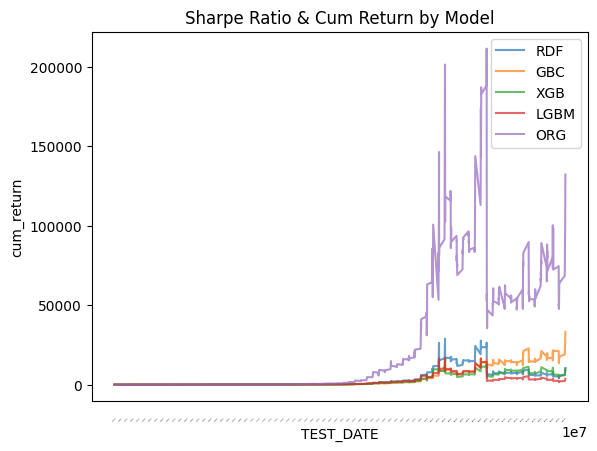

In [141]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result],
                     [RDF_F_CUM_RETURN_static, GBC_F_CUM_RETURN_static, XGB_F_CUM_RETURN_static, LGBM_F_CUM_RETURN_static],
                     dynamic=False)

#### Dynamic

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.7522  최종 누적 수익률 : 6216.899331054997
GBC Sharpe Ratio : 0.7308  최종 누적 수익률 : 7121.331065075383
XGB Sharpe Ratio : 0.7299  최종 누적 수익률 : 9486.433681479117
LGBM Sharpe Ratio : 0.6855  최종 누적 수익률 : 3669.360469379297


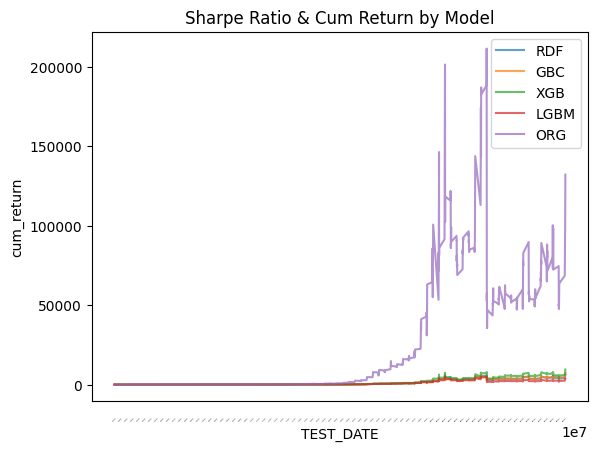

In [142]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result],
                     [RDF_F_CUM_RETURN_dynamic, GBC_F_CUM_RETURN_dynamic, XGB_F_CUM_RETURN_dynamic, LGBM_F_CUM_RETURN_dynamic],
                     dynamic=True)

### Rolling Expanding Windows

#### Static

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.7413  최종 누적 수익률 : 64493.32395225134
GBC Sharpe Ratio : 0.6665  최종 누적 수익률 : 23272.246503325317
XGB Sharpe Ratio : 0.6376  최종 누적 수익률 : 8923.21667454029
LGBM Sharpe Ratio : 0.6404  최종 누적 수익률 : 10408.360757789496


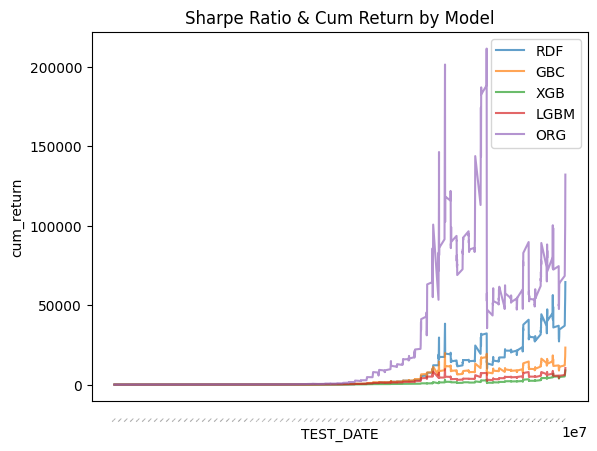

In [143]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result],
                     [RDF_E_CUM_RETURN_static, GBC_E_CUM_RETURN_static, XGB_E_CUM_RETURN_static, LGBM_E_CUM_RETURN_static],
                     dynamic=False)

#### Dynamic

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.7796  최종 누적 수익률 : 8841.755553597673
GBC Sharpe Ratio : 0.7254  최종 누적 수익률 : 5037.2720194893545
XGB Sharpe Ratio : 0.6811  최종 누적 수익률 : 6017.2588910292025
LGBM Sharpe Ratio : 0.7216  최종 누적 수익률 : 8380.140163557571


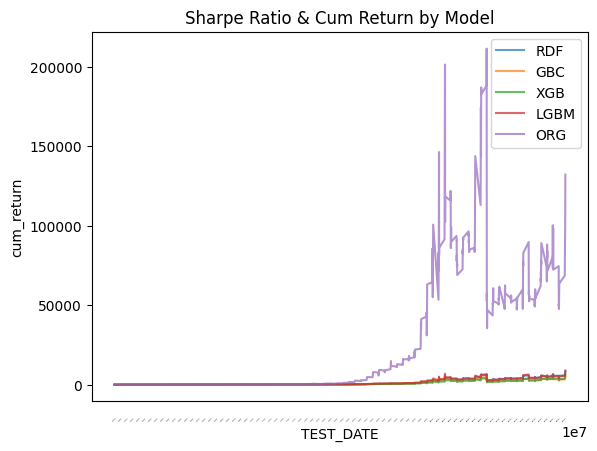

In [144]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result],
                     [RDF_E_CUM_RETURN_dynamic, GBC_E_CUM_RETURN_dynamic, XGB_E_CUM_RETURN_dynamic, LGBM_E_CUM_RETURN_dynamic],
                     dynamic=True)